In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import sys
from pymatgen.ext.matproj import MPRester
from pymatgen.core.structure import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher
from ase import Atoms
from ase.io import write
from ase.visualize import view
from ase.visualize.ngl import view_ngl
from ase import Atoms
from ase.io import read, write
from ase.visualize.plot import plot_atoms
from ase.visualize import view
from ase.visualize.ngl import view_ngl,NGLDisplay
from pymatgen.io.ase import AseAtomsAdaptor
import qmpy_rester as qr
# import nglview as ng
import copy
from pymatgen.core.structure import Structure
from pymatgen.analysis.chemenv.coordination_environments.coordination_geometry_finder import LocalGeometryFinder,AbstractGeometry
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies import SimplestChemenvStrategy
from pymatgen.analysis.chemenv.coordination_environments.structure_environments import LightStructureEnvironments
from pymatgen.analysis.chemenv.coordination_environments.structure_environments import StructureEnvironments
from tqdm import tqdm

In [2]:
def plot_csm(struct_list,file_str_list=[]):
    
    ce_list = []
    isite_list = []
    isite = 0
    for i in tqdm(struct_list):
#         print(file_str_list[struct_list.index(i)])
        lgf = LocalGeometryFinder()
        lgf.setup_structure(structure=i)
        if lgf!=[]:
#             se = lgf.compute_structure_environments(maximum_distance_factor=2,only_cations=True)
#             strategy = SimplestChemenvStrategy(distance_cutoff=1.4, angle_cutoff=0.3)
# #             print(se.structure)
#             lse = LightStructureEnvironments.from_structure_environments(strategy=strategy, structure_environments=se)
            m_specie_temp = ''
            num_anion = 0
            flag = 0
            for m in i:
                if str(m.specie) in ['Cl','O','S','F','Br','I','H']:
                    num_anion = num_anion+1
    #                 if m.specie!=anion_elements:
    #                     print(struct_list.index(i))
    #                     flag = 1
            volume = i.volume/num_anion
    #         if lse.coordination_environments[0] is not None:
            Li_list = []
#             print(i)
            for j in i:
                if str(j.specie) == 'Li':
                    isite = i.index(j)
                    Li_list.append(isite)
            se = lgf.compute_structure_environments(maximum_distance_factor=2,only_cations=True,only_indices=Li_list)
            strategy = SimplestChemenvStrategy(distance_cutoff=1.4, angle_cutoff=0.3)
            lse = LightStructureEnvironments.from_structure_environments(strategy=strategy, structure_environments=se)
            for idx in Li_list:
                print(lse.coordination_environments[idx])
                if lse.coordination_environments[idx] is not None:
                    if len(lse.coordination_environments[idx])>0:
                        csm_T_4 = se.get_csms(isite,'T:4')
                        csm_O_6 = se.get_csms(isite,'O:6')
                        if csm_T_4 != []:
                            lse.coordination_environments[idx][0]['ce_symbol_I'] = 'T:4'
    #                            print(csm_T_4)
                            lse.coordination_environments[idx][0]['ce_csm_I'] = csm_T_4[0]['symmetry_measure']
                        else:
                            lse.coordination_environments[idx][0]['ce_symbol_I'] = 'T:4'
    #                            print(csm_T_4)
                            lse.coordination_environments[idx][0]['ce_csm_I'] = None
                        if csm_O_6 != []:
                            lse.coordination_environments[idx][0]['ce_symbol_T'] = 'O:6'
    #                            print(csm_O_6)
                            lse.coordination_environments[idx][0]['ce_csm_T'] = csm_O_6[0]['symmetry_measure']
                        else:
                            lse.coordination_environments[idx][0]['ce_symbol_T'] = 'O:6'
    #                            print(csm_T_4)
                            lse.coordination_environments[idx][0]['ce_csm_T'] = None
    #                        if lse.coordination_environments[isite][0]['ce_symbol'] == 'T:4' or lse.coordination_environments[isite][0]['ce_symbol'] == 'O:6':
                        ce_list.append([lse.coordination_environments[idx][0],volume,i.formula])
                    else:
                        pass
#                     if lse.coordination_environments[isite] is not None:
#                         if len(lse.coordination_environments[isite])>0:
#                             csm_T_4 = se.get_csms(isite,'T:4')
#                             csm_O_6 = se.get_csms(isite,'O:6')
#                             if csm_T_4 != []:
#                                 lse.coordination_environments[isite][0]['ce_symbol_I'] = 'T:4'
#     #                             print(csm_T_4)
#                                 lse.coordination_environments[isite][0]['ce_csm_I'] = csm_T_4[0]['symmetry_measure']
#                             else:
#                                 lse.coordination_environments[isite][0]['ce_symbol_I'] = 'T:4'
#     #                             print(csm_T_4)
#                                 lse.coordination_environments[isite][0]['ce_csm_I'] = None
#                             if csm_O_6 != []:
#                                 lse.coordination_environments[isite][0]['ce_symbol_T'] = 'O:6'
#     #                             print(csm_O_6)
#                                 lse.coordination_environments[isite][0]['ce_csm_T'] = csm_O_6[0]['symmetry_measure']
#                             else:
#                                 lse.coordination_environments[isite][0]['ce_symbol_T'] = 'O:6'
#     #                             print(csm_T_4)
#                                 lse.coordination_environments[isite][0]['ce_csm_T'] = None
#     #                         if lse.coordination_environments[isite][0]['ce_symbol'] == 'T:4' or lse.coordination_environments[isite][0]['ce_symbol'] == 'O:6':
#                             ce_list.append([lse.coordination_environments[isite][0],volume,i.formula])
#                     else:
#                         pass
    return ce_list


In [3]:
from pymatgen.core.periodic_table import get_el_sp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
# from pymatgen import Structure
# from qmpy import Entry
import pandas as pd
import numpy as np
import re
def run_one(a):
    """
    Take one OQMD 'Entry' object, search all the calculations associated and take the best calculation
    in order to insert its data into the PyChemia Database

    :param a: OQMD Entry object
    :return:
    """
    #print('Entry: %6d  Number of Calculations: %3d ' % (a.id, a.calculation_set.count()))
    #print('Entry: %6d  Number of Calculations: %3d  Energies: %s' % (a.id, a.calculation_set.count(),
    #                                                                 str([c.energy for c in a.calculation_set.all()])))
#     energy = 1E10
#     try:
#       select=a.c['static']
#       if len(select.errors)>0: select=None
#     except:
#       select = None
      
#     if select is None:
#         return None, None
    
    band_gap = a['band_gap']
#     if band_gap is None:
#        return None, None

#     iscd_id = a['icsd_id']
    structure_id = a['icsd_id']
    entry_id = a['entry_id']
    calculation_id = a['calculation_id']
    elements_list = []
#    energy_pa = select.energy_pa
    energy_id = a['formationenergy_id']
    volume = a['volume']
    cell = a['unit_cell']
    elements = a['composition'].split(" ")
    natoms = int(a['natoms'])
    num_1 = 0
    for j in elements:
        num = re.findall(r'\D+', j)
        num1 = re.findall(r'\d+', j)
        for i in range(0,eval(num1[0])):
#             elements_list.append(num[0])
            num_1 = num_1+1
#     print(num_1)
    expand = int(natoms/num_1)
#     print(expand)
    for j in elements:
        num = re.findall(r'\D+', j)
        num1 = re.findall(r'\d+', j)
        for i in range(0,eval(num1[0])*expand):
            elements_list.append(num[0])
#     print(elements_list)
    
#     reduced = a['sites']
    reduced = [(re.sub(r'\w+ @', "", i).strip().split(" ")) for i in a['sites']]
    reduced = [np.array([eval(i[0]),eval(i[1]),eval(i[2])]) for i in reduced]
#     for j in reduced
#     print(reduced)
    structure = Structure(cell,elements_list,reduced)
#     print(structure)
# #    settings = select.settings
    try:
        spacegroup = a['spacegroup']
    except ValueError:
        spacegroup_number = None

#     symm = SpacegroupAnalyzer(structure)
#     sym2 = symm.get_space_group_number()
    
    
    properties = {'oqmd': {'structure_id': structure_id,
                           'entry_id': entry_id,
                           'calculation_id': calculation_id,
                           'energy_id': energy_id,
                           'band_gap': band_gap,
                           'volume':volume,
#                           'settings': settings,
                           'spacegroup': spacegroup}}
#     print(structure)
    return {'structure':structure, 'prop':properties}

In [5]:
def que_structure(x):
    with MPRester('niwEwLelQWb0kPBFE') as m:
        m_data = m.query(criteria = x, properties = ["unit_cell_formula",'e_above_hull', "pretty_formula","spacegroup","final_structure","band_gap",'elasticity'])       
    return m_data

In [10]:
element_ion = ['Li',]
element_anion = ['O','S'] #,'O','S','F','Br','I'
element_trans_metal = [
    'Sc',
    'Ti',
    'V','Cr','Mn','Fe','Co','Ni',
                        'Cu','Zn','Sr','Y','Zr','Er','In','Sn','Nb','Mo','La','Ce','Eu',
                       'Hf','Ta','Pb','Mg','Sn',
    'Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Pr','Nd','Pm','Sm','Gd','Tb','Dy','Ho','P','Mg','Ca','Tm','Yb','Lu','W','Re','Os','Ir','Pt','Au','Hg','Tl']
# 'Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Pr','Nd','Pm','Sm','Gd','Tb','Dy','Ho','P','Mg','Ca','Tm','Yb','Lu','W','Re','Os','Ir','Pt','Au','Hg','Tl',
struct_list = []
struct_dict = []
str_list = ""
for j in element_trans_metal:
#     print(j)
    str_list = str_list+str(j)+" OR"
#         struct_list.append(j)
# m_data = []
# print(str_list)
with qr.QMPYRester() as q:
    kwargs = {
        "element_set": f"Li,(O-S)",      # composition include (Fe OR Mn) AND O
        "stability": "0",            # hull distance smaller than -0.1 eV
        "natom": "<50",
        "ntype":"<4",
        "limit":"800"# number of atoms less than 10
        }
    list_of_data = q.get_oqmd_phases(**kwargs)

Your filters are:
    limit=800
    filter=element_set=Li,(O-S) AND stability=0


Proceed? [Y/n]: n


In [43]:
element_ion = ['Li',]
element_anion = ['O','S'] #,'O','S','F','Br','I'
element_trans_metal = [
    'Sc',
    'Ti',
    'V','Cr','Mn','Fe','Co','Ni',
                        'Cu','Zn','Sr','Y','Zr','Er','In','Sn','Nb','Mo','La','Ce','Eu',
                       'Hf','Ta','Pb','Mg','Sn',
    'Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Pr','Nd','Pm','Sm','Gd','Tb','Dy','Ho','P','Mg','Ca','Tm','Yb','Lu','W','Re','Os','Ir','Pt','Au','Hg','Tl']
# 'Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Pr','Nd','Pm','Sm','Gd','Tb','Dy','Ho','P','Mg','Ca','Tm','Yb','Lu','W','Re','Os','Ir','Pt','Au','Hg','Tl',
struct_list = []
struct_dict = []
structure1_list = []
m_d = que_structure({"elements":{"$in":['Li'], "$all": ['Li','S',]}, "nelements":2})
for j in m_d:
    if (j['unit_cell_formula']['S']/j['unit_cell_formula']['Li']==0.5): 
#     and (j['unit_cell_formula']['S']/j['unit_cell_formula']['Ge']==4):
        structure1_list.append(j['final_structure'])

In [44]:
# # structure1_list
# import re
# a_list = []
# d_list = []
# j_list = []
# for i in structure_list:
#     c = i.formula
#     a = re.findall(r'\D+', i.formula)
#     d = [d.strip() for d in a]
# #     print(a)
#     d_list.append(d)
#     for j in d:
#         j_list.append(j)
#         if j in element_trans_metal:
#             i.remove_species([j])

# volume_list = []
# for i in structure_list:
#     c = i.formula
#     a = re.findall(r'\d+', i.formula)
# #     print(a)
#     anion_num = int(a[1])
#     volume_list.append(i.volume/anion_num)




    
ce_list = plot_csm(structure1_list,'ss')
ce_list_1 = []
for i in tqdm(ce_list):
    if i[0]['csm']:
        ce_list_1.append(i)
a = []
b = []
c = []
d = []
e = []
f = []
x = []
for i in tqdm(ce_list_1):
#     print(i[0])
    a.append(i[0]['ce_symbol_I'])
    b.append(i[0]['ce_csm_I'])
    c.append(i[0]['ce_symbol_T'])
    d.append(i[0]['ce_csm_T'])
    e.append(i[1])
    f.append(i[2])
#     x.append(i[3])

dataframe = pd.DataFrame({'ce_symbol_I':a,'ce_csm_I':b,'ce_symbol_T':c,'ce_csm_T':d,'volume':e,'formula':f})

 25%|███████████▎                                 | 1/4 [00:09<00:27,  9.17s/it]

[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 15.563873069240072, 'permutation': [3, 1, 6, 2, 5, 8, 4, 9, 7, 0]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 15.428981725884233, 'permutation': [7, 9, 2, 6, 3, 5, 0, 8, 4, 1]}]
[{'ce_symbol': 'C:8', 'ce_fraction': 1.0, 'csm': 0.6197442050532543, 'permutation': [1, 2, 4, 6, 3, 7, 0, 5]}]
[{'ce_symbol': 'C:8', 'ce_fraction': 1.0, 'csm': 0.6292894857586286, 'permutation': [6, 5, 0, 7, 3, 4, 1, 2]}]
[{'ce_symbol': 'DI:11', 'ce_fraction': 1.0, 'csm': 14.780490299343002, 'permutation': [7, 6, 0, 1, 8, 10, 4, 2, 3, 9, 5]}]
[{'ce_symbol': 'DI:11', 'ce_fraction': 1.0, 'csm': 14.593571265988286, 'permutation': [5, 1, 6, 7, 0, 3, 8, 10, 2, 9, 4]}]
[{'ce_symbol': 'SBSA:10', 'ce_fraction': 1.0, 'csm': 7.452778669420988, 'permutation': [1, 5, 0, 4, 2, 8, 7, 3, 9, 6]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 15.729765062609443, 'permutation': [4, 2, 9, 3, 7, 5, 1, 8, 0, 6]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'cs

 50%|██████████████████████▌                      | 2/4 [00:11<00:10,  5.01s/it]

[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 3.8976776695797763, 'permutation': [1, 7, 2, 4, 3, 5, 0, 6]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 3.8976776695797772, 'permutation': [0, 5, 1, 6, 3, 7, 2, 4]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 3.8976776695797786, 'permutation': [1, 3, 0, 6, 2, 5, 4, 7]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 3.8976776695797763, 'permutation': [1, 2, 3, 7, 5, 6, 0, 4]}]


 75%|█████████████████████████████████▊           | 3/4 [00:20<00:06,  6.83s/it]

[{'ce_symbol': 'C:12', 'ce_fraction': 1.0, 'csm': 2.3467963429004066, 'permutation': [1, 5, 8, 6, 10, 0, 7, 3, 4, 11, 2, 9]}]
[{'ce_symbol': 'C:12', 'ce_fraction': 1.0, 'csm': 2.3467963429004075, 'permutation': [5, 1, 6, 7, 10, 4, 3, 0, 9, 11, 2, 8]}]
[{'ce_symbol': 'C:12', 'ce_fraction': 1.0, 'csm': 2.346796342900409, 'permutation': [7, 0, 10, 3, 9, 11, 1, 5, 4, 2, 8, 6]}]
[{'ce_symbol': 'C:12', 'ce_fraction': 1.0, 'csm': 2.3467963429004053, 'permutation': [2, 4, 1, 7, 0, 3, 9, 8, 5, 11, 6, 10]}]
[{'ce_symbol': 'SH:13', 'ce_fraction': 1.0, 'csm': 11.417070827116852, 'permutation': [10, 4, 5, 11, 6, 8, 3, 2, 1, 12, 7, 0, 9]}]
[{'ce_symbol': 'SH:13', 'ce_fraction': 1.0, 'csm': 11.417070827116852, 'permutation': [0, 3, 1, 11, 7, 10, 4, 2, 8, 5, 6, 12, 9]}]
[{'ce_symbol': 'SH:13', 'ce_fraction': 1.0, 'csm': 11.417070827116849, 'permutation': [1, 7, 4, 2, 0, 10, 8, 9, 3, 6, 12, 5, 11]}]
[{'ce_symbol': 'SH:13', 'ce_fraction': 1.0, 'csm': 11.417070827116854, 'permutation': [2, 1, 0, 6, 7, 8,

100%|█████████████████████████████████████████████| 4/4 [00:20<00:00,  5.19s/it]


[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 15.78019192031857, 'permutation': [0, 8, 5, 3, 9, 7, 6, 1, 2, 4]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 15.780191920318575, 'permutation': [6, 8, 7, 1, 9, 4, 0, 3, 2, 5]}]


100%|████████████████████████████████████████| 36/36 [00:00<00:00, 86978.65it/s]


In [ ]:
{'LiCoO2':0.410060,'Li2MnO3':0.6565,'P-LiTiS2':0.55544,'R-LiTiS2':0.33146,'Li2MnO4':0.533568,'Li4Ti5O12':0.1718,'Li3PO4':0.6074,'Li3PS4':1.7264,'Li4GeS4':0.753055}

In [70]:
structure_list = []
for i in list_of_data['data']:
    c = run_one(i)
    structure_list.append(c['structure'])

TypeError: 'NoneType' object is not subscriptable

In [40]:
print(len(structure_list))

800


In [41]:
import re
a_list = []
d_list = []
j_list = []
for i in structure_list:
    c = i.formula
    a = re.findall(r'\D+', i.formula)
    d = [d.strip() for d in a]
#     print(a)
    d_list.append(d)
    for j in d:
        j_list.append(j)
        if j in element_trans_metal:
            i.remove_species([j])

volume_list = []
for i in structure_list:
    c = i.formula
    a = re.findall(r'\d+', i.formula)
#     print(a)
    anion_num = int(a[1])
    volume_list.append(i.volume/anion_num)




    
ce_list = plot_csm(structure_list,'ss')
ce_list_1 = []
for i in tqdm(ce_list):
    if i[0]['csm']:
        ce_list_1.append(i)
a = []
b = []
c = []
d = []
e = []
f = []
x = []
for i in tqdm(ce_list_1):
#     print(i[0])
    a.append(i[0]['ce_symbol_I'])
    b.append(i[0]['ce_csm_I'])
    c.append(i[0]['ce_symbol_T'])
    d.append(i[0]['ce_csm_T'])
    e.append(i[1])
    f.append(i[2])
#     x.append(i[3])

dataframe = pd.DataFrame({'ce_symbol_I':a,'ce_csm_I':b,'ce_symbol_T':c,'ce_csm_T':d,'volume':e,'formula':f})

  0%|                                                                                          | 0/800 [00:00<?, ?it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  0%|                                                                                  | 1/800 [00:00<07:48,  1.70it/s]

[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 1.5491269502899074, 'permutation': [1, 3, 0, 5, 6, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  0%|▏                                                                                 | 2/800 [00:00<06:27,  2.06it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11671847401686962, 'permutation': [1, 2, 4, 0, 5, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.08259090440111003, 'permutation': [0, 5, 3, 2, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides

  0%|▍                                                                                 | 4/800 [00:01<05:09,  2.57it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4778323687673912, 'permutation': [1, 3, 5, 0, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.0003101594974497482, 'permutation': [5, 1, 4, 0, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxide

  1%|▌                                                                                 | 6/800 [00:01<04:14,  3.12it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5179651692176477, 'permutation': [0, 3, 5, 2, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  1%|▋                                                                                 | 7/800 [00:01<04:03,  3.25it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7519758180149415, 'permutation': [1, 4, 3, 0, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  1%|▊                                                                                 | 8/800 [00:02<04:58,  2.66it/s]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 4.0466903951174675, 'permutation': [4, 3, 6, 0, 2, 1, 5]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 4.0466903951174675, 'permutation': [1, 0, 4, 2, 5, 6, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  1%|▉                                                                                 | 9/800 [00:03<08:38,  1.52it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.457085113951995, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.4570851139519987, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  1%|█                                                                                | 10/800 [00:04<07:41,  1.71it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7279707150742176, 'permutation': [3, 2, 4, 0, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7260451906483921, 'permutation': [5, 1, 2, 0, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  1%|█                                                                                | 11/800 [00:05<11:14,  1.17it/s]

[{'ce_symbol': 'C:12', 'ce_fraction': 1.0, 'csm': 3.156197972330817, 'permutation': [4, 10, 2, 8, 6, 3, 7, 11, 0, 1, 5, 9]}]
[{'ce_symbol': 'C:12', 'ce_fraction': 1.0, 'csm': 3.1561979723308173, 'permutation': [11, 3, 10, 1, 5, 8, 7, 2, 6, 9, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  2%|█▏                                                                               | 12/800 [00:08<19:17,  1.47s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.1751900345940345, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.175190034594033, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  2%|█▎                                                                               | 13/800 [00:09<18:59,  1.45s/it]

[{'ce_symbol': 'C:12', 'ce_fraction': 1.0, 'csm': 1.794204797462699, 'permutation': [0, 9, 11, 2, 3, 5, 1, 8, 7, 10, 6, 4]}]
[{'ce_symbol': 'C:12', 'ce_fraction': 1.0, 'csm': 1.794204797462699, 'permutation': [11, 8, 3, 0, 2, 10, 1, 7, 5, 4, 6, 9]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  2%|█▍                                                                               | 14/800 [00:10<14:27,  1.10s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7401246397461565, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  2%|█▌                                                                               | 15/800 [00:10<11:29,  1.14it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8831982949723667, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  2%|█▌                                                                               | 16/800 [00:12<16:05,  1.23s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.332975929075156, 'permutation': [3, 2, 4, 0, 5, 1]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 9.172244354729592, 'permutation': [0, 1, 5, 3, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3329759290751556, 'permutation': [0, 4, 1, 5, 2, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 9.17224435472961, 'permutation': [2, 0, 1, 3, 5, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  2%|█▋                                                                               | 17/800 [00:13<15:21,  1.18s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.70352374250838, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.7035237425083825, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  2%|█▊                                                                               | 18/800 [00:14<13:42,  1.05s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.4771393585836976, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  2%|█▉                                                                               | 19/800 [00:14<10:53,  1.19it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0001756257093743068, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  2%|██                                                                               | 20/800 [00:15<09:24,  1.38it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6836822695515659, 'permutation': [2, 4, 5, 3, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6836822695515671, 'permutation': [5, 2, 4, 1, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  3%|██▏                                                                              | 22/800 [00:15<06:34,  1.97it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4139209436331621, 'permutation': [3, 1, 2, 0, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4139209436331618, 'permutation': [2, 0, 4, 3, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.02840990865583558, 'permutation': [2, 5, 3, 4, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.02840990865583616, 'permutation': [4, 1, 5, 0, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco 

  3%|██▎                                                                              | 23/800 [00:16<06:59,  1.85it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.31109114543975325, 'permutation': [2, 5, 4, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3107562238595974, 'permutation': [2, 4, 0, 1, 5, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  3%|██▍                                                                              | 24/800 [00:16<05:46,  2.24it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.047157794260517444, 'permutation': [2, 5, 4, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.14151467095805642, 'permutation': [0, 4, 5, 1, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.14151467095805642, 'permutation': [0, 4, 1, 3, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  3%|██▌                                                                              | 25/800 [00:17<08:35,  1.50it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8209602793368818, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8209602793368833, 'permutation': [1, 0, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  3%|██▋                                                                              | 26/800 [00:19<11:22,  1.13it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.7892198806616644, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.7892198806616615, 'permutation': [2, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  3%|██▋                                                                              | 27/800 [00:20<12:04,  1.07it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.79883722505406, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9887480525002514, 'permutation': [4, 2, 5, 1, 3, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7988372250540487, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  4%|██▊                                                                              | 28/800 [00:25<27:02,  2.10s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3837131156124113, 'permutation': [2, 3, 1, 5, 0, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3493853493403503, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3493853493403558, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.349385349340349, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3493853493403614, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.031894005611889, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0309503704001313, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3928105531876649, 'permutation': [2, 1, 4, 3, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.39408132707299925, 'permutation': [0, 5, 3, 1, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3884026468887625, 'permutation': [1, 0, 5

  4%|██▉                                                                              | 29/800 [00:26<23:13,  1.81s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3075295380347616, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3075295380347596, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.307529538034756, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3059169770585008, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3059169770585037, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.305916977058499, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3059169770585013, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.305916977058499, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel,

  4%|███                                                                              | 30/800 [00:27<21:08,  1.65s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.481427634272927, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4814276342729285, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4814276342729267, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4814276342729271, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.481427634272929, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4814276342729273, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4814276342729285, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4814276342729304, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel

  4%|███▏                                                                             | 31/800 [00:28<18:48,  1.47s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.288633839339066, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2886338393390655, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2886338393390628, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2886338393390648, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2886338393390624, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.283355314009019, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2833553140090104, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2833553140090161, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel

  4%|███▏                                                                             | 32/800 [00:29<17:14,  1.35s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4445013615534419, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4445013615534341, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4445013615534383, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.44450136155344, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4445013615534366, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4445013615534414, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4445013615534394, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4445013615534372, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel

  4%|███▎                                                                             | 33/800 [00:30<15:50,  1.24s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4995457978899365, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4995457978899391, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4995457978899362, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4995457978899356, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4995457978899414, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.499545797889937, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4995457978899411, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4995457978899376, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebe

  4%|███▍                                                                             | 34/800 [00:31<15:20,  1.20s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6410240229224242, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6410240229224284, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6410240229224264, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.641024022922427, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.64102402292243, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6410240229224264, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.64102402292243, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.641024022922429, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, St

  4%|███▍                                                                           | 35/800 [00:47<1:13:05,  5.73s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.423042474760045, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.4153728910415984, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.4153728910415886, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.4151466162795177, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.5603121115872165, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.5489874167701676, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.550854786437907, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.5491252328446548, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6659629334425194, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6749751004321677, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol

  4%|███▌                                                                           | 36/800 [00:50<1:00:54,  4.78s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1868551214010596, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1891391566451965, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1893201266735967, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.182795827811468, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1893201266735987, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1827958278114694, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.186855121401069, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.189139156645199, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel,

  5%|███▋                                                                             | 37/800 [00:54<55:51,  4.39s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5705580200912321, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5716185008892944, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5723379621590488, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5723379621590435, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5723379621590435, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.572337962159047, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5705580200912281, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5716185008892937, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebe

  5%|███▊                                                                           | 38/800 [01:00<1:04:14,  5.06s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 5.30799892837829, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 5.307680721899406, 'permutation': [1, 0, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 5.305452288750398, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 5.315007337639307, 'permutation': [2, 0, 1, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 5.31500733763931, 'permutation': [1, 0, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 5.298420209586354, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 5.307680721899412, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 5.315007337639307, 'permutation': [1, 0, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel

  5%|███▉                                                                             | 39/800 [01:01<46:55,  3.70s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.708861971062259, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.7041306349902525, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.703543998109979, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.707024694375061, 'permutation': [1, 2, 4, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  5%|███▉                                                                           | 40/800 [01:11<1:12:44,  5.74s/it]

[{'ce_symbol': 'SBT:8', 'ce_fraction': 1.0, 'csm': 2.9662046572585337, 'permutation': [3, 1, 5, 2, 4, 6, 7, 0]}]
[{'ce_symbol': 'SBT:8', 'ce_fraction': 1.0, 'csm': 2.9661679888219403, 'permutation': [3, 4, 5, 7, 2, 1, 6, 0]}]
[{'ce_symbol': 'SBT:8', 'ce_fraction': 1.0, 'csm': 2.965207252126382, 'permutation': [5, 3, 6, 0, 4, 2, 7, 1]}]
[{'ce_symbol': 'SBT:8', 'ce_fraction': 1.0, 'csm': 2.9663043177634107, 'permutation': [2, 3, 5, 0, 4, 1, 7, 6]}]
[{'ce_symbol': 'SBT:8', 'ce_fraction': 1.0, 'csm': 2.9652072521263793, 'permutation': [0, 3, 4, 1, 5, 2, 6, 7]}]
[{'ce_symbol': 'SBT:8', 'ce_fraction': 1.0, 'csm': 2.9652430879796925, 'permutation': [3, 7, 6, 0, 5, 4, 2, 1]}]
[{'ce_symbol': 'SBT:8', 'ce_fraction': 1.0, 'csm': 2.96630431776341, 'permutation': [1, 5, 4, 2, 3, 6, 0, 7]}]
[{'ce_symbol': 'SBT:8', 'ce_fraction': 1.0, 'csm': 2.9652072521263824, 'permutation': [0, 4, 6, 3, 1, 2, 5, 7]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :

  5%|████                                                                           | 41/800 [01:19<1:20:04,  6.33s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 5.915587161121053, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 5.911929652482185, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 5.913531311812985, 'permutation': [0, 3, 2, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 5.913531311812982, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3711350154700444, 'permutation': [4, 2, 3, 1, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.36995986973329864, 'permutation': [3, 2, 5, 0, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), 

  5%|████▎                                                                            | 42/800 [01:20<58:36,  4.64s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.599253448980562, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.61399084490965, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  5%|████▎                                                                            | 43/800 [01:21<44:52,  3.56s/it]

[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 1.0228389879649382, 'permutation': [0, 3, 1, 2]}]
[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 1.011418602802618, 'permutation': [0, 2, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4540605092773888, 'permutation': [0, 4, 1, 3, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.45406050927738706, 'permutation': [1, 0, 2, 5, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  6%|████▍                                                                            | 44/800 [01:21<33:34,  2.66s/it]

[{'ce_symbol': 'PB:7', 'ce_fraction': 1.0, 'csm': 1.6822285835515962, 'permutation': [6, 0, 1, 4, 2, 5, 3]}]
[{'ce_symbol': 'PB:7', 'ce_fraction': 1.0, 'csm': 1.6794698928249154, 'permutation': [6, 1, 0, 2, 4, 5, 3]}]
[{'ce_symbol': 'PB:7', 'ce_fraction': 1.0, 'csm': 1.6849957275606195, 'permutation': [4, 5, 2, 3, 0, 6, 1]}]
[{'ce_symbol': 'PB:7', 'ce_fraction': 1.0, 'csm': 1.6789888415832985, 'permutation': [6, 3, 1, 0, 5, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  6%|████▌                                                                            | 45/800 [01:22<25:27,  2.02s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.955954387868048, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.9706307921535546, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.955954387868054, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.9559543878680503, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.9706307921535604, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.970630792153569, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.963612914885932, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.9688425247315715, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.9636129148859305, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.9636129148859327, 'permutation': [0

  6%|████▋                                                                            | 46/800 [01:24<26:41,  2.12s/it]

[{'ce_symbol': 'PP:10', 'ce_fraction': 1.0, 'csm': 12.253195597308988, 'permutation': [8, 0, 3, 2, 4, 6, 7, 1, 5, 9]}]
[{'ce_symbol': 'PP:10', 'ce_fraction': 1.0, 'csm': 12.286939568165566, 'permutation': [2, 4, 5, 3, 7, 0, 1, 8, 9, 6]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  6%|████▋                                                                          | 47/800 [01:44<1:34:18,  7.51s/it]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.140652315825017, 'permutation': [5, 4, 3, 2, 0, 1, 6]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.11465913626149, 'permutation': [3, 0, 6, 2, 1, 4, 5]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.120406918989719, 'permutation': [4, 1, 0, 3, 5, 6, 2]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.120406918989717, 'permutation': [4, 1, 2, 6, 0, 5, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.114659136261489, 'permutation': [4, 5, 1, 3, 2, 0, 6]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.140652315825017, 'permutation': [6, 3, 0, 1, 5, 4, 2]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.12040691898971, 'permutation': [3, 1, 0, 2, 6, 5, 4]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.120406918989724, 'permutation': [6, 5, 4, 1, 0, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.682563526784306, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fracti

  6%|████▋                                                                          | 48/800 [01:44<1:06:57,  5.34s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.6710162468127203, 'permutation': [3, 4, 2, 1, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  6%|████▉                                                                            | 49/800 [01:45<47:37,  3.81s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3732528825351704, 'permutation': [0, 5, 1, 4, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3698536554478538, 'permutation': [2, 1, 3, 4, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  6%|█████▏                                                                           | 51/800 [01:46<26:52,  2.15s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.805991902438438, 'permutation': [0, 5, 2, 3, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.8059919024384388, 'permutation': [0, 5, 2, 4, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.003534875881847044, 'permutation': [0, 3, 5, 2, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.002987088154514218, 'permutation': [4, 2, 3, 0, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco

  6%|█████▎                                                                           | 52/800 [01:47<21:59,  1.76s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2040568831507411, 'permutation': [1, 4, 2, 3, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20405919785325788, 'permutation': [3, 2, 5, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2040568931305971, 'permutation': [4, 5, 3, 1, 0, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2040568931305974, 'permutation': [4, 2, 5, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  7%|█████▎                                                                           | 53/800 [01:47<17:07,  1.38s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21353012516583236, 'permutation': [0, 5, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21354093878048014, 'permutation': [2, 4, 5, 3, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21351214976023236, 'permutation': [2, 0, 5, 1, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21352082910402614, 'permutation': [0, 5, 1, 3, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  7%|█████▌                                                                           | 55/800 [01:49<11:53,  1.04it/s]

[{'ce_symbol': 'L:2', 'ce_fraction': 1.0, 'csm': 0.0028035441786006233, 'permutation': [0, 1]}]
[{'ce_symbol': 'L:2', 'ce_fraction': 1.0, 'csm': 0.00159791237450526, 'permutation': [0, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3628946406998577, 'permutation': [4, 3, 5, 0, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3628946406998577, 'permutation': [0, 1, 2, 5, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Wel

  7%|█████▋                                                                           | 56/800 [01:49<10:14,  1.21it/s]

[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 15.698217344884805, 'permutation': [1, 6, 4, 2, 8, 9, 7, 0, 5, 3]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 15.698217344884805, 'permutation': [1, 5, 6, 2, 9, 4, 8, 0, 3, 7]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  7%|█████▊                                                                           | 57/800 [01:50<08:49,  1.40it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.10067981634587161, 'permutation': [1, 0, 2, 4, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.10067981634587062, 'permutation': [0, 3, 1, 5, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  7%|█████▊                                                                           | 58/800 [01:50<07:04,  1.75it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 8.65500380744649, 'permutation': [1, 4, 3, 2, 5, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  7%|█████▉                                                                           | 59/800 [01:50<06:02,  2.04it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 7.443715904443062, 'permutation': [1, 3, 2, 4, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  8%|██████                                                                           | 60/800 [01:52<11:40,  1.06it/s]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.0005045403575712, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.030915135335386, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 0.24672938584679058, 'permutation': [0, 3, 1, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.030915135335388, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.000504540357573, 'permutation': [0, 2, 1, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  8%|██████▏                                                                          | 61/800 [01:54<16:25,  1.33s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5662720953385524, 'permutation': [0, 3, 2, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.6653916857118144, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 0.17338929291691493, 'permutation': [0, 2, 1, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.7189008555303471, 'permutation': [0, 4, 1, 3, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5580649439844667, 'permutation': [1, 4, 2, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  8%|██████▎                                                                          | 62/800 [01:56<17:09,  1.39s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4605435886609911, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46196722284203817, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45613041973322127, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4663823372931068, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  8%|██████▍                                                                          | 63/800 [01:59<23:23,  1.90s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8229447018988976, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8203499740340058, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8229447018988988, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8203499740340032, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  8%|██████▍                                                                          | 64/800 [02:00<20:28,  1.67s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.44329429473450976, 'permutation': [4, 3, 5, 2, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5332545860348337, 'permutation': [1, 4, 2, 3, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4276042239745016, 'permutation': [2, 4, 3, 0, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5332545860348336, 'permutation': [4, 1, 2, 3, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.44329429473450926, 'permutation': [3, 4, 5, 2, 0, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  8%|██████▌                                                                          | 65/800 [02:02<21:52,  1.79s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5089050373844409, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5089050373844421, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  8%|██████▋                                                                          | 66/800 [02:02<16:15,  1.33s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.045497594455351856, 'permutation': [2, 3, 4, 1, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.03885769993912998, 'permutation': [5, 2, 4, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.03880373729058331, 'permutation': [3, 2, 5, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.045232158330811637, 'permutation': [0, 3, 4, 2, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  8%|██████▊                                                                          | 67/800 [02:04<17:25,  1.43s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.76736562030668, 'permutation': [1, 0, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.7673656203066868, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.7673656203066814, 'permutation': [2, 0, 1, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.767365620306682, 'permutation': [0, 2, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  8%|██████▉                                                                          | 68/800 [02:05<14:01,  1.15s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2732900498263613, 'permutation': [2, 4, 3, 1, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2732900498263619, 'permutation': [4, 3, 2, 0, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2732900498263614, 'permutation': [1, 3, 4, 2, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.27329004982636224, 'permutation': [1, 4, 2, 3, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  9%|██████▉                                                                          | 69/800 [02:09<27:39,  2.27s/it]

[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.33215119006446, 'permutation': [1, 0, 5, 8, 7, 9, 2, 6, 3, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 17.166778013349777, 'permutation': [1, 4, 6, 3, 5, 2, 0, 7]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 17.17937166104773, 'permutation': [5, 3, 1, 4, 2, 7, 6, 0]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 17.16067968243447, 'permutation': [0, 5, 3, 6, 2, 7, 1, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 17.173271250693688, 'permutation': [3, 4, 7, 1, 0, 2, 6, 5]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.335324728162721, 'permutation': [8, 7, 6, 2, 1, 0, 9, 4, 3, 5]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.332149814809341, 'permutation': [7, 8, 9, 3, 5, 2, 6, 1, 0, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 17.157553824822468, 'permutation': [3, 2, 4, 6, 5, 0, 7, 1]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 17.1514558339143, 

  9%|███████                                                                          | 70/800 [02:10<20:10,  1.66s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.03486353557285199, 'permutation': [5, 0, 4, 2, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.033112474510320816, 'permutation': [2, 3, 5, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.03568913923658364, 'permutation': [0, 4, 5, 2, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.03311247451032084, 'permutation': [3, 2, 5, 0, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  9%|███████▏                                                                         | 71/800 [02:10<16:16,  1.34s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2714921405644256, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.26625789596907756, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.271492059792023, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.26625797665816925, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  9%|███████▎                                                                         | 72/800 [02:14<23:30,  1.94s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2448914682651813, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2482536656266374, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2482536656266359, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2486416312129882, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  9%|███████▍                                                                         | 73/800 [02:18<32:01,  2.64s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 20.0618580800091, 'permutation': [7, 3, 2, 4, 5, 0, 6, 1]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 20.061216679788732, 'permutation': [3, 4, 0, 5, 7, 6, 2, 1]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 11.06869332962063, 'permutation': [0, 1, 5, 8, 7, 4, 6, 3, 2]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 11.06810547416859, 'permutation': [7, 4, 5, 6, 2, 8, 1, 0, 3]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 11.068988133556203, 'permutation': [1, 5, 6, 0, 4, 7, 2, 3, 8]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 11.06928283246046, 'permutation': [7, 5, 8, 2, 0, 6, 4, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical ana

  9%|███████▍                                                                         | 74/800 [02:19<27:00,  2.23s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5220622857677555, 'permutation': [5, 2, 3, 1, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6674596262726149, 'permutation': [1, 3, 0, 5, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6674596262726138, 'permutation': [2, 4, 3, 1, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.647279076410859, 'permutation': [0, 5, 2, 3, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



  9%|███████▌                                                                         | 75/800 [02:25<39:01,  3.23s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.8158329086342028, 'permutation': [0, 4, 1, 3, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.8158330751986631, 'permutation': [0, 2, 1, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.8130426969846822, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.815832820363294, 'permutation': [0, 3, 1, 2, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.8130429494363964, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.8130427836007426, 'permutation': [0, 4, 2, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8

 10%|███████▋                                                                         | 76/800 [02:26<32:16,  2.67s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31944213792278253, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.12165828704553, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.12165828704553096, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31944213792277953, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.12165828704553158, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1216582870455307, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 

 10%|███████▊                                                                         | 77/800 [02:27<27:32,  2.29s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.575396222982347, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11860092652799434, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1186009265279933, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.575396222982352, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11860092652799453, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11860092652799552, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 1

 10%|███████▉                                                                         | 78/800 [02:28<22:20,  1.86s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.09148296542056532, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.09127804375436224, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.09012792056883523, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.09152318901533174, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 10%|███████▉                                                                         | 79/800 [02:30<20:43,  1.73s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3143742524471245, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.07064807213410451, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0706480721341047, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31437425244712364, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.07064807213410387, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.07064807213410412, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI

 10%|████████                                                                         | 80/800 [02:37<40:17,  3.36s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.2162946752789483, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.2209245648788785, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.216294675278951, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.220924564878882, 'permutation': [0, 1, 3, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 10%|████████▏                                                                        | 81/800 [02:39<34:12,  2.86s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.708533194095654, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.70750702463869, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7075070246386925, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7108012558284993, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 10%|████████▎                                                                        | 82/800 [02:45<45:04,  3.77s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5461922661180619, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.546192266118058, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 10.740784691935149, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 10.740784691935144, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5468902867636278, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5468902867636278, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 10.73952117371114, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 10.739521173711138, 'permutation': [0, 3, 4, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Mi

 10%|████████▍                                                                        | 83/800 [02:51<55:00,  4.60s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0756676673889423, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.1830743481066381, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.2476061711296642, 'permutation': [0, 3, 1, 2, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.0235769315910384, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.0221130181761495, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.2467071359757254, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.1830743481066393, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0723824486969409, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,


 10%|████████▌                                                                        | 84/800 [02:53<46:31,  3.90s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5423521167446231, 'permutation': [0, 5, 4, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6150755684694305, 'permutation': [3, 1, 4, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5603436148324796, 'permutation': [5, 1, 3, 0, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4860535051094216, 'permutation': [0, 3, 5, 2, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6123014588913595, 'permutation': [1, 5, 2, 4, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4862874300163105, 'permutation': [0, 1, 2, 4, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.56054017049613, 'permutation': [1, 4, 3, 2, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6140730705568244, 'permutation': [2, 4, 5, 1, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin 

 11%|████████▌                                                                        | 85/800 [03:01<58:17,  4.89s/it]

[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.384099981891316, 'permutation': [8, 0, 7, 5, 4, 9, 3, 6, 1, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.93065643197708, 'permutation': [5, 3, 4, 1, 2, 6, 7, 0]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.92867593400776, 'permutation': [2, 4, 7, 0, 5, 1, 6, 3]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.931924405855963, 'permutation': [2, 7, 1, 6, 4, 3, 0, 5]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.929943965349857, 'permutation': [3, 7, 4, 6, 1, 5, 2, 0]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.384543038638716, 'permutation': [0, 8, 2, 3, 4, 6, 1, 7, 9, 5]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.384099981891316, 'permutation': [4, 3, 9, 5, 6, 2, 8, 0, 1, 7]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.923052245896482, 'permutation': [7, 0, 3, 6, 2, 5, 1, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.92432020405209

 11%|████████▋                                                                        | 86/800 [03:02<46:32,  3.91s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11989482910482198, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11679226552990044, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.12043288847690485, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11972836841550988, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 11%|████████▊                                                                        | 87/800 [03:08<51:42,  4.35s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7200918385372316, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7200918385372334, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2560148091270897, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2560148091270915, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.72341588056057, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7234158805605705, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.259267919786765, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2592679197867716, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel,

 11%|████████▉                                                                        | 88/800 [03:10<44:36,  3.76s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4284167773556301, 'permutation': [1, 5, 4, 0, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7230343887051235, 'permutation': [0, 4, 5, 1, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.44724887851424, 'permutation': [5, 4, 2, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4473062875562584, 'permutation': [0, 3, 2, 5, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7210299435606276, 'permutation': [5, 4, 2, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4277224948215198, 'permutation': [2, 4, 0, 1, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 20

 11%|█████████                                                                        | 89/800 [03:12<37:46,  3.19s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5092066993960873, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5092066993960878, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.504196386510599, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5092066993960844, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 11%|████████▉                                                                      | 90/800 [03:24<1:09:10,  5.85s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.3011413894207415, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.3011413894207386, 'permutation': [2, 0, 1, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.2967844386109273, 'permutation': [2, 0, 1, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.2967844386109295, 'permutation': [1, 0, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 11%|████████▉                                                                      | 91/800 [03:32<1:15:57,  6.43s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5925466801078436, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5925466801078446, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 10.359262835638113, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 10.359262835638106, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5898985990111741, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5898985990111725, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 10.363369930195427, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 10.363369930195425, 'permutation': [0, 2, 3, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,


 12%|█████████                                                                      | 92/800 [03:35<1:04:35,  5.47s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1345770028503346, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0443452087862115, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0398779120980923, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1369947875766973, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 12%|█████████▍                                                                       | 93/800 [03:37<51:27,  4.37s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.37715597021636904, 'permutation': [0, 5, 1, 2, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3898902359948935, 'permutation': [0, 5, 4, 3, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4083904198493153, 'permutation': [2, 5, 1, 3, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3454323531037704, 'permutation': [4, 3, 5, 2, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.47991147895380193, 'permutation': [1, 5, 4, 0, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.34678901690301245, 'permutation': [0, 5, 1, 3, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4086911041975584, 'permutation': [2, 5, 1, 0, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3884212281938032, 'permutation': [1, 3, 4, 0, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cat

 12%|█████████▌                                                                       | 94/800 [03:40<48:01,  4.08s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2098706367719487, 'permutation': [4, 5, 0, 2, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2037496720111824, 'permutation': [3, 5, 1, 0, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.20275020076797, 'permutation': [1, 0, 2, 4, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2027502007679693, 'permutation': [0, 4, 5, 2, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 12%|█████████▌                                                                       | 95/800 [03:46<55:31,  4.73s/it]

[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 18.702087137929116, 'permutation': [5, 6, 4, 9, 3, 8, 2, 7, 0, 1]}]
[{'ce_symbol': 'SBSA:10', 'ce_fraction': 1.0, 'csm': 13.885653558870873, 'permutation': [3, 0, 1, 5, 8, 2, 7, 6, 9, 4]}]
[{'ce_symbol': 'SBSA:10', 'ce_fraction': 1.0, 'csm': 13.885653558870867, 'permutation': [4, 7, 5, 8, 1, 0, 2, 9, 3, 6]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 18.714329778141252, 'permutation': [9, 6, 3, 1, 0, 5, 8, 4, 7, 2]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 18.70208713792912, 'permutation': [1, 7, 9, 8, 5, 2, 6, 0, 3, 4]}]
[{'ce_symbol': 'SBSA:10', 'ce_fraction': 1.0, 'csm': 13.88565355887087, 'permutation': [4, 9, 6, 7, 1, 0, 2, 5, 3, 8]}]
[{'ce_symbol': 'SBSA:10', 'ce_fraction': 1.0, 'csm': 13.885653558870873, 'permutation': [1, 4, 9, 0, 7, 8, 6, 2, 5, 3]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 18.714329778141252, 'permutation': [4, 5, 3, 6, 8, 7, 2, 9, 1, 0]}]

If you use the ChemEnv tool for y

 12%|█████████▋                                                                       | 96/800 [03:49<47:27,  4.04s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4506462045024578, 'permutation': [5, 3, 1, 0, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.46275691373686345, 'permutation': [0, 3, 4, 1, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.38047495475547627, 'permutation': [1, 3, 5, 2, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4638261689764579, 'permutation': [2, 4, 5, 1, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4506462052658043, 'permutation': [2, 5, 3, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4629242064276207, 'permutation': [4, 2, 1, 0, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.38047495475547527, 'permutation': [0, 5, 1, 3, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.463826168976458, 'permutation': [0, 3, 1, 4, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cath

 12%|█████████▊                                                                       | 97/800 [03:49<35:08,  3.00s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7568225389922183, 'permutation': [0, 5, 2, 4, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7567639726133657, 'permutation': [4, 1, 5, 0, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 12%|██████████                                                                       | 99/800 [03:50<19:20,  1.66s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.7384003814742321, 'permutation': [0, 3, 1, 5, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.738400381474237, 'permutation': [3, 0, 5, 1, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6846005064646672, 'permutation': [1, 3, 4, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6847153012314257, 'permutation': [4, 1, 3, 0, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rig

 12%|█████████▊                                                                    | 100/800 [04:10<1:24:42,  7.26s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.4870828147626405, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.029979442667411, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.035209863180099, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.028136418101824, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.033370381390746, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.4866643571339018, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.50592556530591, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.0449395692028975, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.02852834252975, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.044698962222348, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4

 13%|█████████▊                                                                    | 101/800 [04:29<2:05:28, 10.77s/it]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 9.302313013055336, 'permutation': [4, 1, 0, 3, 2, 5]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.899069467897128, 'permutation': [4, 1, 0, 3, 2, 5]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0210226017828772, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0199426949757662, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.895921808156405, 'permutation': [1, 5, 4, 2, 3, 0]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 9.306776995427557, 'permutation': [3, 4, 1, 5, 2, 0]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 9.304434075462236, 'permutation': [2, 0, 4, 5, 3, 1]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.89737748911494, 'permutation': [2, 5, 4, 1, 3, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0210226017828739, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0199426949757628, 'perm

 13%|█████████▉                                                                    | 102/800 [04:36<1:50:03,  9.46s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.368814397897398, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4879381692719957, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.368814397897403, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.3688143978973986, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.487938169271993, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.368814397897402, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.363877455256748, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4879381692719935, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.3638774552567443, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.3688143978974003, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 

 13%|██████████                                                                    | 103/800 [04:49<2:01:28, 10.46s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 14.350527373186042, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 14.350517743237582, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 14.325479143110991, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'TI:9', 'ce_fraction': 1.0, 'csm': 8.201729802419873, 'permutation': [4, 1, 8, 6, 0, 7, 5, 2, 3]}]
[{'ce_symbol': 'TI:9', 'ce_fraction': 1.0, 'csm': 8.202123314895903, 'permutation': [8, 3, 1, 7, 0, 4, 2, 5, 6]}]
[{'ce_symbol': 'TI:9', 'ce_fraction': 1.0, 'csm': 8.20212968733464, 'permutation': [1, 3, 8, 2, 6, 7, 5, 0, 4]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 6.76016340372306, 'permutation': [2, 3, 4, 1, 6, 0, 5]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 6.760153000026928, 'permutation': [2, 4, 3, 6, 5, 1, 0]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 14.350698277298694, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction':

 13%|██████████▏                                                                   | 104/800 [05:07<2:27:34, 12.72s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1785750245904745, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.178575024590474, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 6.815658988966315, 'permutation': [0, 1, 2, 6, 5, 3, 4]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 6.814199416406278, 'permutation': [5, 2, 3, 4, 6, 1, 0]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.823553548347085, 'permutation': [3, 0, 1, 5, 2, 4]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.83612486600743, 'permutation': [4, 2, 1, 0, 3, 5]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1712729467474654, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 9.997495656403677, 'permutation': [1, 5, 3, 2, 0, 4]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 6.822086731957711, 'permutation': [4, 0, 5, 2, 1, 3, 6]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 6.81554576122318

 13%|██████████▏                                                                   | 105/800 [05:09<1:52:59,  9.76s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.016700038233764, 'permutation': [0, 4, 1, 5, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.20456706026779703, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.014527060943369, 'permutation': [1, 4, 2, 5, 3, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.20304441455798705, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.014527060943368, 'permutation': [3, 1, 4, 2, 5, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.20499882043283896, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.0202699632432803, 'permutation': [5, 3, 1, 0, 2, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21020582899127935, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Fra

 13%|██████████▎                                                                   | 106/800 [05:13<1:31:57,  7.95s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.26314696698456347, 'permutation': [0, 4, 2, 3, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2587964536587472, 'permutation': [1, 5, 2, 0, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.26035887781320466, 'permutation': [4, 3, 1, 5, 0, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.26035887781320494, 'permutation': [0, 4, 1, 3, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.26550306125706163, 'permutation': [0, 5, 1, 4, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.26314696698456447, 'permutation': [0, 5, 1, 4, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.25879645365874765, 'permutation': [1, 2, 4, 0, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2587964536587475, 'permutation': [1, 5, 3, 2, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2655030612570626, 'permutation': [0, 5, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 

 13%|██████████▍                                                                   | 107/800 [05:15<1:11:55,  6.23s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.23693605758498068, 'permutation': [2, 4, 5, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16521680488354826, 'permutation': [2, 5, 4, 1, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2369360575849794, 'permutation': [5, 1, 2, 4, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.23693605758498068, 'permutation': [1, 2, 5, 3, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1652168048835479, 'permutation': [0, 5, 1, 3, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2369360575849797, 'permutation': [1, 4, 5, 0, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.23693605758498018, 'permutation': [2, 5, 1, 3, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16521680488354798, 'permutation': [0, 4, 1, 3, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.23693605758498046, 'permutation': [3, 2, 5, 1, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 

 14%|██████████▊                                                                     | 108/800 [05:17<55:01,  4.77s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.2570125301889012, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.13051249221828254, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.13171022116188622, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.2523442469546016, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.253311274260306, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.13179345209639806, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.13118639308086727, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.250931651127465, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Go

 14%|██████████▉                                                                     | 109/800 [05:18<43:39,  3.79s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.03140610856229959, 'permutation': [2, 4, 3, 0, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1154065309966576, 'permutation': [1, 4, 3, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1155567282594372, 'permutation': [0, 4, 1, 3, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11100846469923095, 'permutation': [0, 5, 1, 3, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.031462815642249356, 'permutation': [5, 2, 1, 0, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11094378003124396, 'permutation': [3, 2, 4, 1, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11573473781651318, 'permutation': [3, 2, 5, 1, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11549928821749658, 'permutation': [1, 2, 0, 3, 4, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese,

 14%|███████████                                                                     | 110/800 [05:21<40:39,  3.54s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.19912445846772242, 'permutation': [1, 3, 2, 4, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3327348516576279, 'permutation': [4, 2, 1, 0, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.332636526541256, 'permutation': [5, 1, 2, 4, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1980482858597304, 'permutation': [4, 3, 5, 0, 1, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.19501186008009216, 'permutation': [0, 2, 1, 5, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.33273485165762684, 'permutation': [0, 1, 4, 5, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.33373839340291345, 'permutation': [0, 5, 2, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.19912445846772242, 'permutation': [0, 2, 3, 4, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Ca

 14%|███████████                                                                     | 111/800 [05:24<36:55,  3.21s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6021917064694088, 'permutation': [0, 5, 1, 2, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.605391651209396, 'permutation': [0, 4, 2, 1, 3, 5]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.170330720986949, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1678803717114112, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6024944329986165, 'permutation': [3, 1, 4, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.605696833915393, 'permutation': [5, 2, 4, 0, 3, 1]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.173239155691824, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1732391556918176, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Ro

 14%|██████████▉                                                                   | 112/800 [05:40<1:22:09,  7.17s/it]

[{'ce_symbol': 'BO_1:8', 'ce_fraction': 1.0, 'csm': 0.35849322154099633, 'permutation': [5, 3, 7, 1, 2, 4, 6, 0]}]
[{'ce_symbol': 'BO_1:8', 'ce_fraction': 1.0, 'csm': 0.35735667733412524, 'permutation': [0, 4, 7, 3, 6, 5, 1, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6709929496288544, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 6.9246734200845514, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 6.925529874175589, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 6.893618080136394, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 6.894485823979163, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6757886516979084, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'BS_1:10', 'ce_fraction': 1.0, 'csm': 9.230110263377679, 'permutation': [8, 7, 2, 0, 4, 6, 5, 3, 9, 1]}]
[{'ce_symbol': 'BS_1:10', 'ce_fraction': 1.0, '

 14%|███████████                                                                   | 113/800 [05:43<1:05:54,  5.76s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.29715452175664103, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30728772332304594, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11958717811792591, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.29715418038655783, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1185612620440932, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11958714926885, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11856104555677213, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11958736280248825, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30728737859325955, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11856107050580734, 'permutation': [0, 1, 2, 3]}]
[{'c

 14%|███████████▍                                                                    | 114/800 [05:44<51:40,  4.52s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.39195183326110616, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3990038781913483, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1515629556872597, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3919517654839561, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.15310192538224757, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.15156254990214735, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.15310214992506946, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1515623222024628, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.39900478212763146, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.15310256579942108, 'permutation': [0, 1, 2, 3]}]
[{'c

 14%|███████████▏                                                                  | 115/800 [05:53<1:05:15,  5.72s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.8323791428897291, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.114960398139477, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.1038907153413176, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.8328256980031814, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.8328256980031852, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.114960398139483, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.1128326987613724, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.8368358019154107, 'permutation': [0, 3, 4, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank 

 15%|███████████▋                                                                    | 117/800 [06:01<50:48,  4.46s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7829308145833843, 'permutation': [1, 5, 2, 3, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7782102616155607, 'permutation': [1, 4, 5, 0, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7766360181943581, 'permutation': [1, 3, 0, 5, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.776636018194356, 'permutation': [2, 3, 4, 5, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7740166852405038, 'permutation': [5, 2, 4, 3, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7787172579726126, 'permutation': [4, 1, 2, 3, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7773223880670126, 'permutation': [1, 3, 2, 0, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.777322388067013, 'permutation': [1, 3, 4, 2, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin 

 15%|███████████▌                                                                  | 118/800 [06:21<1:46:51,  9.40s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.457506398585302, 'permutation': [0, 2, 7, 6, 5, 4, 1, 3]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.457506398585302, 'permutation': [1, 2, 3, 7, 6, 0, 5, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.456167669188087, 'permutation': [2, 3, 6, 0, 4, 5, 1, 7]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.456167669188076, 'permutation': [7, 1, 6, 3, 2, 0, 4, 5]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.354815359743709, 'permutation': [0, 1, 2, 7, 9, 8, 4, 6, 3, 5]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.352468330853455, 'permutation': [8, 4, 0, 7, 9, 6, 1, 5, 3, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.443910370064813, 'permutation': [2, 4, 7, 0, 5, 1, 3, 6]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.447880246507083, 'permutation': [2, 7, 5, 3, 1, 4, 0, 6]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.453734419838952, 'p

 15%|███████████▌                                                                  | 119/800 [06:22<1:16:19,  6.72s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16796868810116264, 'permutation': [2, 4, 3, 5, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1679686881011611, 'permutation': [0, 5, 2, 3, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1679686881011633, 'permutation': [0, 5, 2, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16796868810116133, 'permutation': [2, 4, 0, 3, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 15%|███████████▋                                                                  | 120/800 [06:29<1:18:57,  6.97s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.180690246358004, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5874572677867671, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9624813094930122, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.096153358880895, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.098914397338859, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9524791704518839, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5858227405072275, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1815734023885627, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1850582186122485, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5858227405072234, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol'

 15%|███████████▊                                                                  | 121/800 [06:57<2:28:58, 13.16s/it]

[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.341508426046257, 'permutation': [3, 0, 6, 9, 8, 5, 1, 7, 4, 2]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 14.492609881268608, 'permutation': [5, 1, 0, 6, 2, 3, 4]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 14.492609881268608, 'permutation': [6, 4, 2, 5, 0, 3, 1]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 14.492609881268603, 'permutation': [5, 4, 6, 2, 1, 0, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 14.492609881268601, 'permutation': [2, 1, 5, 3, 4, 6, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.293530481602397, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3003256055656296, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 22.214805166442275, 'permutation': [2, 3, 1, 5, 0, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2973345868805097, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 

 15%|███████████▉                                                                  | 122/800 [06:58<1:45:36,  9.35s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7819468634882756, 'permutation': [4, 2, 3, 1, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4648983148001333, 'permutation': [0, 1, 4, 3, 5, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.046226406324676, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.0511571069227055, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.46155561998235056, 'permutation': [0, 1, 4, 2, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7781857438320413, 'permutation': [0, 4, 2, 3, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 

 15%|███████████▉                                                                  | 123/800 [07:35<3:20:51, 17.80s/it]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.959758013121704, 'permutation': [1, 2, 3, 0, 6, 4, 5]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.96557417088811, 'permutation': [3, 4, 5, 0, 2, 1, 6]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 7.663720699545213, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 7.632990560416711, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7482135635688973, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7472204981864864, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 7.612617004905036, 'permutation': [5, 3, 2, 1, 4, 6, 0]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 7.608283018195514, 'permutation': [0, 2, 4, 3, 5, 6, 1]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.300901946153465, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3050328974857448, 

 16%|████████████                                                                  | 124/800 [08:18<4:44:10, 25.22s/it]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 7.619773821862152, 'permutation': [1, 6, 0, 4, 5, 2, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 7.629051893531477, 'permutation': [1, 3, 4, 5, 6, 2, 0]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 8.244652719049883, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 8.23082431326497, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6804686870377283, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6731938599672136, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 14.953260498933727, 'permutation': [4, 2, 1, 7, 6, 3, 5, 0]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 14.96244302540641, 'permutation': [1, 4, 5, 2, 3, 0, 7, 6]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.80375520046201, 'permutation': [0, 4, 1, 6, 3, 2, 5]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 

 16%|████████████▏                                                                 | 125/800 [08:50<5:09:07, 27.48s/it]

[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 14.540636695436064, 'permutation': [0, 1, 6, 5, 3, 4, 2]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 10.9940382823728, 'permutation': [1, 6, 2, 3, 4, 5, 0]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.385688010714823, 'permutation': [0, 2, 1, 3, 4, 5, 6]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 9.122982737263241, 'permutation': [0, 3, 2, 4, 6, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 6.608965526274492, 'permutation': [2, 1, 5, 0, 3, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.960707127018573, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.628072041123788, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 7.453120931970678, 'permutation': [5, 0, 2, 4, 1, 3, 6]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.221711033438185, 'permutation': [0, 5, 4, 1, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm':

 16%|████████████▎                                                                 | 126/800 [08:51<3:36:59, 19.32s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7726309227155856, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 16%|████████████▍                                                                 | 127/800 [08:51<2:32:54, 13.63s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.1098000278350266, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 16%|████████████▍                                                                 | 128/800 [08:55<2:00:53, 10.79s/it]

[{'ce_symbol': 'TL:3', 'ce_fraction': 1.0, 'csm': 0.04269320367952382, 'permutation': [0, 1, 2]}]
[{'ce_symbol': 'TL:3', 'ce_fraction': 1.0, 'csm': 0.04188466879408695, 'permutation': [0, 1, 2]}]
[{'ce_symbol': 'TL:3', 'ce_fraction': 1.0, 'csm': 0.04070052931114214, 'permutation': [0, 1, 2]}]
[{'ce_symbol': 'TL:3', 'ce_fraction': 1.0, 'csm': 0.0423646722975423, 'permutation': [0, 1, 2]}]
[{'ce_symbol': 'TL:3', 'ce_fraction': 1.0, 'csm': 0.04133309134962016, 'permutation': [0, 1, 2]}]
[{'ce_symbol': 'TL:3', 'ce_fraction': 1.0, 'csm': 0.04184232519948671, 'permutation': [0, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/a

 16%|████████████▌                                                                 | 129/800 [08:56<1:26:12,  7.71s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5168325000067044, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5168325000067056, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 16%|████████████▋                                                                 | 130/800 [08:56<1:01:16,  5.49s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.232484705593461, 'permutation': [5, 2, 3, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2381579409105063, 'permutation': [1, 4, 5, 2, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2390851643071128, 'permutation': [0, 4, 2, 5, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2447715527997958, 'permutation': [0, 5, 1, 3, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 16%|█████████████                                                                   | 131/800 [08:57<46:08,  4.14s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.725146350205898, 'permutation': [5, 1, 3, 0, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.719829242053312, 'permutation': [1, 4, 5, 0, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.7257847864511389, 'permutation': [4, 2, 1, 0, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.7204729467009836, 'permutation': [3, 4, 2, 1, 5, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 16%|█████████████▏                                                                  | 132/800 [09:02<49:32,  4.45s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4282767184230264, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.007183885067136, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0065163851012313, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4307266152146389, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4307254176580648, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.006045377853306, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0096761757983677, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.42827671842302534, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebe

 17%|█████████████▎                                                                  | 133/800 [09:04<41:59,  3.78s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.051447445550007145, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05007644612503822, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.050076446125038525, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05007644612503862, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.050076446125038504, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05007644612503818, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05007644612503845, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.050076446125038455, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,


 17%|█████████████▍                                                                  | 134/800 [09:08<43:02,  3.88s/it]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.179952162694098, 'permutation': [3, 5, 4, 0, 1, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.178363191854089, 'permutation': [5, 1, 2, 0, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 17%|█████████████▌                                                                  | 135/800 [09:13<45:59,  4.15s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 31.699864809611594, 'permutation': [0, 3, 2, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 31.699940466557237, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 31.695083854713214, 'permutation': [0, 1, 3, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 31.695174164688666, 'permutation': [1, 2, 3, 4, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 31.68302222594981, 'permutation': [0, 2, 1, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 31.68303477520696, 'permutation': [0, 4, 1, 3, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 31.70110893431694, 'permutation': [0, 2, 1, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 31.701118564827585, 'permutation': [0, 4, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank R

 17%|█████████████▌                                                                  | 136/800 [09:17<45:07,  4.08s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9956273840225549, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9992213116515526, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3438863689002207, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3388430084102811, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0002457393039126, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9997338614072024, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10

 17%|█████████████▋                                                                  | 137/800 [09:22<47:17,  4.28s/it]

[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 6.353422400773051, 'permutation': [1, 5, 0, 6, 2, 3, 4]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 6.355568507986971, 'permutation': [1, 2, 0, 3, 6, 5, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 17%|█████████████▊                                                                  | 138/800 [09:24<40:59,  3.72s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.9905549421300164, 'permutation': [4, 3, 5, 1, 2, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.175152128691485, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.990489042297271, 'permutation': [0, 5, 4, 2, 1, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.1751023640044402, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 17%|█████████████▉                                                                  | 139/800 [09:25<31:11,  2.83s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2026226207470643, 'permutation': [0, 3, 2, 5, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2862060433821829, 'permutation': [0, 3, 4, 2, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20262262074706455, 'permutation': [0, 4, 5, 1, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.28620604338218336, 'permutation': [3, 2, 5, 1, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 18%|██████████████                                                                  | 140/800 [09:27<27:35,  2.51s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.605856690350056, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5832228485257345, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5832228485257351, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5991543782833622, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 18%|█████████████▋                                                                | 141/800 [09:40<1:02:24,  5.68s/it]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 16.821238466788397, 'permutation': [1, 5, 4, 0, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 14.32450846867283, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 14.322080675614867, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 8.8260282758314, 'permutation': [4, 2, 6, 5, 1, 0, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 8.82699071877098, 'permutation': [5, 2, 6, 4, 0, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 14.32791032500523, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 14.324508468672835, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 16.83244544992904, 'permutation': [3, 1, 4, 2, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nie

 18%|█████████████▊                                                                | 142/800 [09:45<1:00:21,  5.50s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 0.6343316234694434, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 0.8644885972814, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 0.8657800135824052, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 0.6319508775990296, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 0.6328474611172151, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 0.8668762750824164, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 0.8646015049150897, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 0.6297311224918228, 'permutation': [1, 2, 3, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank R

 18%|██████████████▎                                                                 | 143/800 [09:48<50:37,  4.62s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3791679630279442, 'permutation': [1, 2, 0, 3, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.42985980054584627, 'permutation': [4, 2, 5, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4113145546334178, 'permutation': [2, 5, 1, 0, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.39339799221916666, 'permutation': [4, 2, 3, 0, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5279809084051315, 'permutation': [2, 3, 5, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.39270248012373266, 'permutation': [0, 2, 1, 4, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4105417894898993, 'permutation': [5, 1, 2, 4, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.42869397541044735, 'permutation': [4, 3, 2, 1, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Ca

 18%|██████████████▍                                                                 | 144/800 [09:48<36:23,  3.33s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.4404120973356007, 'permutation': [3, 1, 4, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.4400095544735143, 'permutation': [0, 5, 4, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.4417914141413162, 'permutation': [2, 5, 4, 1, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.4413874495777932, 'permutation': [3, 4, 5, 0, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 18%|██████████████▌                                                                 | 145/800 [09:58<57:00,  5.22s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.8611428010715019, 'permutation': [0, 3, 1, 2, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.47903408484003435, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5677652714325281, 'permutation': [0, 3, 2, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5619039018819563, 'permutation': [0, 3, 2, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.4744379036358016, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.856289116653203, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.8584999553647357, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.4744366072608529, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5621115448970032, 'permutation': [0, 1, 2, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5667981778944107, 'permutation'

 18%|██████████████▌                                                                 | 146/800 [09:59<45:36,  4.18s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.0491544745003487, 'permutation': [4, 2, 5, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.0684663520596285, 'permutation': [2, 3, 5, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8116689891897798, 'permutation': [3, 0, 2, 1, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7848209289904177, 'permutation': [2, 5, 4, 1, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7860229871581444, 'permutation': [4, 1, 3, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8087194633354869, 'permutation': [3, 4, 2, 1, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.0679394901999455, 'permutation': [0, 2, 3, 5, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.0525264578716211, 'permutation': [0, 4, 5, 2, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathri

 18%|██████████████▎                                                               | 147/800 [10:14<1:21:13,  7.46s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.3211576330532122, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.0952141528918764, 'permutation': [0, 4, 2, 3, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.684099708533275, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5639406680163195, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.43086960221990594, 'permutation': [2, 3, 5, 0, 1, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.4019698758675504, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4648319633435055, 'permutation': [4, 2, 5, 1, 3, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5380967212495467, 'permutation': [0, 2, 3, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4072004049401395, 'permutation': [4, 2, 1, 0, 3, 5]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.36426829907738034, 'pe

 18%|██████████████▍                                                               | 148/800 [10:16<1:00:30,  5.57s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2654664246660456, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2654664246660472, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 19%|██████████████▌                                                               | 149/800 [11:08<3:32:44, 19.61s/it]

[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.066020358202008, 'permutation': [3, 1, 2, 4, 5, 7, 0, 6]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.057904143909154, 'permutation': [0, 3, 1, 4, 5, 7, 6, 2]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 17.228643279821384, 'permutation': [6, 3, 2, 0, 4, 1, 5]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 17.24408734615804, 'permutation': [1, 4, 6, 0, 3, 5, 2]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 14.421920206842307, 'permutation': [5, 3, 1, 6, 4, 0, 7, 2]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 14.4153791242384, 'permutation': [4, 0, 1, 7, 3, 6, 2, 5]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 14.193931850797888, 'permutation': [5, 0, 7, 1, 4, 2, 3, 6]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 14.196100088490537, 'permutation': [7, 0, 1, 6, 3, 5, 4, 2]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 12.225500886406557, 'permutation': [0, 3, 6, 1, 4, 2, 5

 19%|██████████████▋                                                               | 150/800 [11:17<2:59:16, 16.55s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.5714910850715902, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.873952917529351, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.1840145407033553, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.1817754865662593, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8727858808631457, 'permutation': [0, 4, 2, 3, 1]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.5710254552565033, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.5713580248950025, 'permutation': [1, 0, 3, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8747882753689908, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.1872302218876016, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.1834566009938263, 'permutation': [1, 2

 19%|██████████████▋                                                               | 151/800 [11:18<2:06:24, 11.69s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.25619993031177024, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2550289967813547, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 19%|██████████████▊                                                               | 152/800 [11:24<1:50:28, 10.23s/it]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.880709103634764, 'permutation': [4, 1, 0, 5, 3, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.880709103634768, 'permutation': [1, 0, 5, 4, 2, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.880705514268037, 'permutation': [0, 5, 4, 2, 1, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.88070551426803, 'permutation': [2, 0, 3, 4, 1, 5]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.88070406430783, 'permutation': [3, 5, 4, 0, 1, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.88070406430783, 'permutation': [0, 1, 4, 5, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater

 19%|██████████████▉                                                               | 153/800 [11:28<1:29:28,  8.30s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.9503676729169954, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.953722059676397, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 19%|███████████████                                                               | 154/800 [11:35<1:25:23,  7.93s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 3.831238735243582, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.423680528128227, 'permutation': [4, 5, 2, 1, 3, 0]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.406951983641513, 'permutation': [2, 4, 5, 1, 3, 0]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.42368052812823, 'permutation': [0, 5, 4, 3, 2, 1]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 3.8312387352435797, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.40695198364152, 'permutation': [0, 2, 3, 5, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 

 19%|███████████████                                                               | 155/800 [11:42<1:20:15,  7.47s/it]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.855634126410614, 'permutation': [1, 0, 4, 5, 2, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.855634126410592, 'permutation': [5, 0, 4, 3, 2, 1]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.855635759926674, 'permutation': [5, 2, 0, 4, 1, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.855635759926685, 'permutation': [2, 5, 4, 0, 1, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.85563609096686, 'permutation': [3, 2, 4, 5, 0, 1]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.85563609096686, 'permutation': [0, 4, 3, 1, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mate

 20%|███████████████▌                                                                | 156/800 [11:42<57:35,  5.37s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7315432885500446, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7276453243346832, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 20%|███████████████▊                                                                | 158/800 [11:43<29:20,  2.74s/it]

[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 7.081764055309853e-07, 'permutation': [0, 3, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 0.6066236680589262, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 0.6064143138658903, 'permutation': [2, 3, 4, 0, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Ro

 20%|███████████████▉                                                                | 159/800 [11:43<21:08,  1.98s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21985927207491401, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21985927207491535, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21961856024165943, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21961856024165669, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 20%|████████████████                                                                | 160/800 [11:46<25:48,  2.42s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4591304103882666, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3896016538984068, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45963800373778924, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.39193945244740974, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 20%|████████████████                                                                | 161/800 [11:49<27:33,  2.59s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9236371874269159, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9259716403002544, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9149999108109054, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9207114258169, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 20%|████████████████▏                                                               | 162/800 [11:50<21:05,  1.98s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.22646000977225056, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.045717661374731905, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.22633327641423942, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04539685916473739, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 20%|████████████████▎                                                               | 163/800 [11:50<15:46,  1.49s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0671324691789277, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.067132469178935, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 21%|████████████████▌                                                               | 165/800 [11:51<09:17,  1.14it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8626326060854612, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8626167122978292, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7195519106349675, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.719558476254366, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-N

 21%|████████████████▌                                                               | 166/800 [11:51<07:02,  1.50it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6024400027919845, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6019819676618752, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 21%|████████████████▋                                                               | 167/800 [11:52<08:44,  1.21it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.1659388512183972, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.1659388512184097, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 21%|████████████████▊                                                               | 168/800 [12:00<29:46,  2.83s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0599577916568097, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0599577916568026, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.059957791656806, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0599577916568046, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 21%|████████████████▉                                                               | 169/800 [12:00<22:38,  2.15s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06578132211576555, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06578132211576637, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06578132211576632, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06578132211576565, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 21%|█████████████████                                                               | 170/800 [12:01<17:24,  1.66s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04856733380940578, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04856733380940449, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.048567333809405214, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04856733380940506, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 21%|█████████████████                                                               | 171/800 [12:01<12:55,  1.23s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.03178721436908153, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.03178721436908117, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.03178721436908122, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.031787214369081544, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 22%|█████████████████▏                                                              | 172/800 [12:02<10:56,  1.05s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06099177639690226, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06099177639690219, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06099177639690035, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06099177639690219, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.002353173817715981, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0023531738177

 22%|█████████████████▍                                                              | 174/800 [12:02<08:37,  1.21it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.046438337601872, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.053678710502578, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 22%|█████████████████▌                                                              | 175/800 [12:04<11:48,  1.13s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1283467055262402, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.129609433196459, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 22%|█████████████████▌                                                              | 176/800 [12:05<09:59,  1.04it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04806970083572866, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.017519743469542923, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04806970083572854, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.017519743469544054, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 22%|█████████████████▊                                                              | 178/800 [12:05<06:29,  1.60it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.1594239922349523, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.153333627014554, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.93113470944032, 'permutation': [5, 3, 2, 4, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.9311347094403235, 'permutation': [0, 4, 3, 2, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathri

 22%|██████████████████                                                              | 180/800 [12:18<30:26,  2.95s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 13.40680127519422, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 14.581874264776703, 'permutation': [4, 3, 2, 1, 0, 5]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 14.570235134710824, 'permutation': [2, 1, 0, 5, 3, 4]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 8.558890970800421, 'permutation': [3, 2, 5, 1, 4, 0, 6]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 8.564071707552223, 'permutation': [0, 5, 6, 2, 1, 4, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 14.580302997131481, 'permutation': [3, 1, 5, 0, 2, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 14.581874264776692, 'permutation': [3, 2, 0, 5, 4, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 13.406356093445225, 'permutation': [0, 1, 3, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin

 23%|██████████████████                                                              | 181/800 [12:18<21:43,  2.11s/it]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.44242033333799596, 'permutation': [0, 3, 1, 4, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4424203333379958, 'permutation': [0, 5, 3, 1, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides"

 23%|██████████████████▏                                                             | 182/800 [12:19<17:06,  1.66s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11044313123373754, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10791973561813013, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11080431791687985, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11404186525125629, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 23%|██████████████████▎                                                             | 183/800 [12:19<12:43,  1.24s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.05765009342032591, 'permutation': [0, 1, 2, 5, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.05601754760610854, 'permutation': [5, 2, 4, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 23%|██████████████████▍                                                             | 184/800 [12:21<16:02,  1.56s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 8.450362909561557, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 8.446460937639523, 'permutation': [0, 1, 3, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 23%|██████████████████▌                                                             | 185/800 [12:24<19:25,  1.90s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.055380605924898074, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.057764138651002106, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05469651443494282, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.054696514434942896, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 23%|██████████████████▌                                                             | 186/800 [12:26<19:45,  1.93s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5855547942217898, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5955797478647276, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5818133066856568, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5877245178060064, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 23%|██████████████████▋                                                             | 187/800 [12:26<15:33,  1.52s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.35165193908217807, 'permutation': [4, 2, 5, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.35165193908217557, 'permutation': [5, 2, 1, 0, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 24%|██████████████████▊                                                             | 188/800 [12:27<12:03,  1.18s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.13053632483789607, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.13089922070688872, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.13259302728507205, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 24%|██████████████████▉                                                             | 189/800 [12:38<42:11,  4.14s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.298234958032262, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.262719155223899, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.262719155223895, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.298234958032256, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 24%|███████████████████                                                             | 191/800 [12:44<33:57,  3.35s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.5327421986074827, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.10809990517094, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.1080999051709406, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.53274219860749, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.023769694765351002, 'permutation': [1, 3, 2, 5, 0, 4]}]

If you use the ChemEnv tool for your research, please consider ci

 24%|███████████████████▎                                                            | 193/800 [12:45<17:50,  1.76s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.3100662948465907, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.3159513437973165, 'permutation': [1, 2, 4, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7332368537753056, 'permutation': [0, 5, 3, 2, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre,

 24%|███████████████████▍                                                            | 194/800 [12:51<32:33,  3.22s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.4393023038234336, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.2576608478696034, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.257660847869616, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.4393023038234287, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 24%|███████████████████▌                                                            | 195/800 [12:57<40:08,  3.98s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.506663249257496, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1090323275168747, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.239924808953371, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2391159325960723, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1111798951783636, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.501320238423903, 'permutation': [2, 3, 4, 0, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DO

 24%|███████████████████▌                                                            | 196/800 [13:06<54:19,  5.40s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.8855743956218394, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.588585339939333, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.5885853399393293, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.8855743956218296, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 25%|███████████████████▋                                                            | 197/800 [13:06<38:55,  3.87s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.4187030455755902, 'permutation': [4, 1, 5, 0, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.423678141019166, 'permutation': [5, 4, 2, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.4236781410191717, 'permutation': [3, 2, 5, 1, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.4286595729341762, 'permutation': [4, 2, 1, 5, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 25%|███████████████████▊                                                            | 198/800 [13:14<52:10,  5.20s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.731552608266651, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6460709054558422, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.646070905455847, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.731552608266659, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 25%|███████████████████▉                                                            | 199/800 [13:15<40:02,  4.00s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5297336632889155, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5236240315890173, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 25%|████████████████████                                                            | 200/800 [13:17<31:42,  3.17s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.9631757897268476, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.959388560644017, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 25%|████████████████████                                                            | 201/800 [13:17<23:19,  2.34s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3102911026723754, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3112544892147976, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3112294939395092, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 25%|████████████████████▏                                                           | 202/800 [13:17<17:01,  1.71s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6566827827345147, 'permutation': [4, 1, 5, 0, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 25%|████████████████████▎                                                           | 203/800 [13:19<15:19,  1.54s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9123029939445351, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9111153693632034, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 26%|████████████████████▌                                                           | 206/800 [13:40<52:19,  5.29s/it]

[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.381385312269519, 'permutation': [3, 4, 9, 0, 7, 1, 2, 8, 5, 6]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.373626530475736, 'permutation': [7, 3, 8, 2, 6, 1, 4, 0, 5, 9]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.373626530475732, 'permutation': [9, 8, 3, 7, 4, 5, 6, 0, 1, 2]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.38305363152225, 'permutation': [2, 8, 1, 7, 5, 9, 0, 3, 6, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.393275796478513, 'permutation': [0, 4, 1, 6, 7, 3, 5, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.401746202548065, 'permutation': [0, 2, 4, 1, 3, 6, 5, 7]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.394368669050586, 'permutation': [7, 0, 5, 1, 3, 6, 2, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.39741114933072, 'permutation': [2, 6, 3, 5, 1, 4, 0, 7]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.3988206

 26%|████████████████████▊                                                           | 208/800 [13:40<36:50,  3.73s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.029167412910330755, 'permutation': [4, 3, 2, 1, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.029940545671956156, 'permutation': [2, 1, 5, 0, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxid

 26%|████████████████████▉                                                           | 209/800 [13:44<37:22,  3.79s/it]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 18.90828243867786, 'permutation': [1, 2, 3, 4, 0, 5]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 18.908283062873014, 'permutation': [5, 0, 2, 3, 4, 1]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 18.908276661482944, 'permutation': [3, 1, 5, 2, 0, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 18.908270666092445, 'permutation': [5, 4, 3, 2, 1, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 26%|█████████████████████                                                           | 210/800 [13:46<30:04,  3.06s/it]

[{'ce_symbol': 'C:12', 'ce_fraction': 1.0, 'csm': 2.609541698572351, 'permutation': [2, 10, 6, 8, 4, 5, 7, 1, 11, 9, 3, 0]}]
[{'ce_symbol': 'C:12', 'ce_fraction': 1.0, 'csm': 2.609541698572351, 'permutation': [3, 10, 2, 6, 0, 7, 5, 11, 4, 1, 9, 8]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 26%|█████████████████████                                                           | 211/800 [13:51<36:02,  3.67s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 3.0345182097717753, 'permutation': [1, 0, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 3.034519353387155, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 3.0362282953677946, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 3.034519169773097, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 3.0362284789041025, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 3.036227335198437, 'permutation': [0, 1, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI:

 26%|█████████████████████▏                                                          | 212/800 [13:58<46:50,  4.78s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.044308245775537, 'permutation': [0, 4, 3, 1, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.044658640607867, 'permutation': [1, 4, 2, 3, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.043662889438547, 'permutation': [5, 1, 4, 2, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.04691476289267, 'permutation': [3, 0, 4, 2, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.039133539502945, 'permutation': [5, 1, 4, 2, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.039954561564729, 'permutation': [2, 1, 3, 0, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.0524382005015065, 'permutation': [0, 3, 1, 2, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.04801930798861, 'permutation': [1, 3, 2, 4, 0, 5]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.952463708510095, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.9612748443976527,

 27%|█████████████████████▎                                                          | 213/800 [13:58<33:28,  3.42s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11088718489529686, 'permutation': [0, 3, 2, 4, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 27%|█████████████████████▍                                                          | 214/800 [14:08<50:41,  5.19s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.1042103396134677, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.104210339613476, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.1027965493106877, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.102573671134326, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 27%|█████████████████████▌                                                          | 215/800 [14:08<36:35,  3.75s/it]

[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 15.780191920318579, 'permutation': [0, 8, 5, 4, 9, 2, 7, 1, 3, 6]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 15.780191920318579, 'permutation': [5, 4, 1, 2, 8, 7, 0, 9, 3, 6]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 27%|█████████████████████▋                                                          | 217/800 [14:09<20:33,  2.12s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.3725894942413297, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.372589494241335, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4076575717389372, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.40413894771362396, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welke

 27%|█████████████████████▉                                                          | 219/800 [14:11<12:46,  1.32s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1995114381933223, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1956371793132778, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1972198525013236, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1994575784622004, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.36447335921057655, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3644733592105745, 

 28%|██████████████████████                                                          | 220/800 [14:11<10:47,  1.12s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34279668403033686, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3447052676302678, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3510339532964851, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34893459743477856, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34265023222947383, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.35203514167249755, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34568448016124903, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3459819522834728, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34498567813589376, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34906484712914737, 'permutation': [0, 1, 2, 3]}]
[{'

 28%|██████████████████████                                                          | 221/800 [14:12<09:35,  1.01it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31033124766283515, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31036728106932315, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3073746579847035, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30720409746798183, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31020153929025446, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3073746579847041, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3103672810693214, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3103312476628375, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31036728106932576, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30735694949999065, 'permutation': [0, 1, 2, 3]}]
[{'c

 28%|██████████████████████▏                                                         | 222/800 [14:13<08:35,  1.12it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.36090625353037714, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3599296640661874, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.36457971453396965, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3574144101653468, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3640976785084629, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3610991475383234, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3593214489810028, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.35944379275552796, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3598016810832798, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3572307835002771, 'permutation': [0, 1, 2, 3]}]
[{'ce_s

 28%|██████████████████████▎                                                         | 223/800 [14:13<08:10,  1.18it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3791173379164672, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3813011582133131, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38303523734365014, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3846187468736992, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.384022991731829, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3791849300446418, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38238045644609686, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38227632045544574, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38139398150272474, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3845492183353329, 'permutation': [0, 1, 2, 3]}]
[{'ce_s

 28%|██████████████████████▍                                                         | 224/800 [14:14<07:54,  1.21it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4523746730616852, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45132524757204057, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.44757649737030347, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4481533833681598, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4522325741738308, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4470203923485145, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45058255189284946, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4507621084119326, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45114002093100075, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4482889040219257, 'permutation': [0, 1, 2, 3]}]
[{'ce_

 28%|██████████████████████▌                                                         | 225/800 [14:15<07:53,  1.21it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.39233477381065973, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38978815185854354, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3965148340089167, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.39128595468794614, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.39239959839743566, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.395570046064186, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3889914560048861, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3888594901082293, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3899314995365051, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3911939052434579, 'permutation': [0, 1, 2, 3]}]
[{'ce_s

 28%|██████████████████████▌                                                         | 226/800 [14:16<07:30,  1.27it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47012885707612906, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47129227143108166, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4773353644268545, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46870606487967603, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4716900756665223, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4767739477588227, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4694795196158648, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46956723017646856, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4700383580512101, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4683124115375598, 'permutation': [0, 1, 2, 3]}]
[{'ce_

 28%|██████████████████████▋                                                         | 227/800 [14:16<07:25,  1.29it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5450983287539322, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5464936184297202, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5392859463516144, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5443224520873238, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5462773502983621, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5387309939388439, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5445419901100893, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5445419901100913, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5450983287539368, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5445419901100925, 'permutation': [0, 1, 2, 3]}]
[{'ce_symb

 28%|██████████████████████▊                                                         | 228/800 [14:17<07:13,  1.32it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4574412461755325, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45876913895769267, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45694839437731916, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4579440589930838, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4573814995807267, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45744124617553733, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4591980962425104, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4592651939046584, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4587048100924102, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4580006278449935, 'permutation': [0, 1, 2, 3]}]
[{'ce_s

 29%|██████████████████████▉                                                         | 229/800 [14:18<07:12,  1.32it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3023807394174691, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3056820163119689, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30389374796901075, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3064388977415204, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30564800443537127, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30279200383591015, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30140474688025315, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3013213813564054, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30250540171737517, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3064598488680673, 'permutation': [0, 1, 2, 3]}]
[{'ce

 29%|███████████████████████                                                         | 230/800 [14:19<07:07,  1.33it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.565967117364297, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5718108481651721, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5774728356062866, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5716376399322539, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5661714108491295, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5800230782586954, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5740694870482237, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5743776057990992, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5715254729808694, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5714599390882881, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbo

 29%|███████████████████████                                                         | 231/800 [14:19<07:12,  1.32it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3852554949250118, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.39087052318205284, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38187198343678486, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.37723226246157987, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3906052711573092, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.37971609261500244, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3830065583590831, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3830264766784843, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3851666597685257, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.37748835646213375, 'permutation': [0, 1, 2, 3]}]
[{'ce

 29%|███████████████████████▏                                                        | 232/800 [14:20<07:01,  1.35it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.346660940143031, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34336101178130857, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34339809772664437, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3431622886314765, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3466609401430328, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34210433887550473, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34210433887550684, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34207555747946233, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34339809772663993, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3431622886314781, 'permutation': [0, 1, 2, 3]}]
[{'ce

 29%|███████████████████████▎                                                        | 233/800 [14:21<07:06,  1.33it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6027965669392702, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6064080777774052, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6069553275290012, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6143274812931989, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6089828127879682, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6027965669392652, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6084014662372782, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.608982812787973, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6069553275289976, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6143274812931933, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbo

 29%|███████████████████████▍                                                        | 234/800 [14:22<07:04,  1.33it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4785931066424503, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4723550229898503, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47945787951918134, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46739528802651287, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4767548153362663, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47892326227723925, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4694745277605314, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46963351305426265, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47216771916957867, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4670600229506531, 'permutation': [0, 1, 2, 3]}]
[{'ce

 29%|███████████████████████▌                                                        | 235/800 [14:22<06:48,  1.38it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3158315619014238, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.312491745893421, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31107356785951984, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30843017950547036, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31582565649108135, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31009152498308173, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3115256885595466, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31148393985090195, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3125088208180977, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30843355893678603, 'permutation': [0, 1, 2, 3]}]
[{'ce

 30%|███████████████████████▌                                                        | 236/800 [14:23<06:53,  1.36it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7369385806418423, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.741927557499737, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7372000165431358, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.742066419818245, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7366501118574321, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7392202691038834, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7438057349173262, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7439597926200372, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7417819734963469, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7423437317199834, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol

 30%|███████████████████████▋                                                        | 237/800 [14:24<06:59,  1.34it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6883582928414791, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6868066604303219, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6824040523483208, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6858958832222108, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6881098448924653, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6817450683760903, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6861465156060863, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6861465156060835, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6868066604303233, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6861465156060842, 'permutation': [0, 1, 2, 3]}]
[{'ce_symb

 30%|███████████████████████▊                                                        | 238/800 [14:25<07:03,  1.33it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4991511416940002, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5060239133511872, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5021135357238778, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5044735761081943, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5046381981663223, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4990075121611517, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5085943606369228, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.508331799254155, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5058027697092159, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5045937753779569, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbo

 30%|███████████████████████▉                                                        | 239/800 [14:25<06:43,  1.39it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6519626544250026, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6487628062856263, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 30%|████████████████████████                                                        | 240/800 [14:28<12:46,  1.37s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3657157544434184, 'permutation': [1, 4, 2, 3, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.380926819702112, 'permutation': [5, 1, 4, 0, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3745654140468293, 'permutation': [1, 3, 5, 0, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.382723593201896, 'permutation': [2, 4, 3, 1, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 30%|████████████████████████                                                        | 241/800 [14:37<33:04,  3.55s/it]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 17.818990566783217, 'permutation': [0, 3, 4, 1, 6, 2, 5]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 18.839481917963695, 'permutation': [0, 1, 3, 5, 4, 2]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 17.814690373383943, 'permutation': [2, 5, 6, 3, 1, 0, 4]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 17.818990566783214, 'permutation': [4, 3, 0, 2, 6, 1, 5]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 18.839481917963692, 'permutation': [2, 4, 5, 3, 1, 0]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 17.814690373383943, 'permutation': [1, 4, 5, 0, 3, 2, 6]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides"

 30%|████████████████████████▎                                                       | 243/800 [14:39<19:47,  2.13s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.1226265896624081, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.1239429570151889, 'permutation': [0, 2, 1, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.015886811532396634, 'permutation': [3, 1, 4, 2, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.01570507406057865, 'permutation': [1, 3, 5, 4, 2, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rigna

 30%|████████████████████████▍                                                       | 244/800 [14:39<14:07,  1.52s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2707281631434713e-30, 'permutation': [4, 5, 3, 1, 0, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 31%|████████████████████████▌                                                       | 246/800 [14:39<08:29,  1.09it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.5421061906626807, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.537350179738232, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.06306189101559001, 'permutation': [1, 3, 5, 0, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.06279004859238557, 'permutation': [2, 4, 0, 1, 5, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Ca

 31%|████████████████████████▊                                                       | 248/800 [14:40<04:54,  1.87it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.07995852532242806, 'permutation': [2, 5, 3, 4, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.07912628861052023, 'permutation': [0, 5, 2, 3, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1222553609075335, 'permutation': [2, 4, 3, 5, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.12352713663092456, 'permutation': [0, 1, 2, 4, 5, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco

 31%|█████████████████████████                                                       | 250/800 [14:40<03:02,  3.01it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.12083752849387291, 'permutation': [5, 1, 4, 0, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.12181032838353477, 'permutation': [1, 4, 5, 2, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.06785846173603435, 'permutation': [1, 0, 5, 3, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.0689821834208682, 'permutation': [5, 2, 1, 0, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco

 32%|█████████████████████████▏                                                      | 252/800 [14:40<02:01,  4.51it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.041171414520627794, 'permutation': [4, 3, 5, 1, 0, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.041178740299997955, 'permutation': [0, 5, 3, 2, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.08163850888230788, 'permutation': [1, 3, 5, 0, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, 

 32%|█████████████████████████▍                                                      | 254/800 [14:41<01:45,  5.20it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.009171799398467153, 'permutation': [1, 4, 5, 0, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.009485216582136703, 'permutation': [1, 3, 2, 5, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.08339762288612267, 'permutation': [2, 3, 1, 4, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.08309187040367091, 'permutation': [1, 5, 3, 2, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Ma

 32%|█████████████████████████▌                                                      | 255/800 [14:42<04:06,  2.21it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7797449557134317, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2775789483862352, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27765611060450923, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7828141947706918, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 32%|█████████████████████████▌                                                      | 256/800 [14:46<15:52,  1.75s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5316513308178054, 'permutation': [0, 4, 2, 3, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.41296372151902844, 'permutation': [0, 4, 1, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4069824955773189, 'permutation': [0, 5, 2, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.22956152768058755, 'permutation': [3, 4, 5, 0, 1, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2297865903784046, 'permutation': [0, 3, 2, 4, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4067007984963864, 'permutation': [3, 4, 5, 0, 1, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.4120563110239677, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5338384800111183, 'permutation': [0, 3, 1, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-N

 32%|█████████████████████████▋                                                      | 257/800 [14:47<12:29,  1.38s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.91570412748236e-07, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.915704127517847e-07, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 32%|█████████████████████████▊                                                      | 258/800 [14:49<14:15,  1.58s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17511010927874857, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17596979087177103, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21366597149172642, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.175109892943284, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21442178423045133, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21366611150924275, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2144219006635825, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21366599485739146, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17596964783723948, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21442175897737037, 'permutation': [0, 1, 2, 3]}]
[{'

 32%|█████████████████████████▉                                                      | 259/800 [15:00<39:05,  4.34s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 12.3989368046194, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.026289513665962, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6510679839369407, 'permutation': [2, 5, 3, 1, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.118732725216256, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.08718311029883, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6454070631658495, 'permutation': [3, 1, 5, 0, 4, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.007608908660466, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 12.361854004902446, 'permutation': [0, 2, 1, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Ros

 33%|██████████████████████████                                                      | 261/800 [15:00<20:09,  2.24s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.865944090549011, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.865623765677151, 'permutation': [0, 3, 4, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 1.1528195659782359, 'permutation': [1, 4, 3, 0, 5, 2]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 1.1363653658758306, 'permutation': [3, 0, 1, 5, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese,

 33%|██████████████████████████▏                                                     | 262/800 [15:02<19:52,  2.22s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6318596895349566, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6249477544402778, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 33%|██████████████████████████▎                                                     | 263/800 [15:06<24:13,  2.71s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9198009683239645, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9169550546665388, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 33%|██████████████████████████▍                                                     | 264/800 [15:07<17:39,  1.98s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.99156265789872, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.005746804481904, 'permutation': [0, 3, 4, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 33%|██████████████████████████▌                                                     | 265/800 [15:07<14:12,  1.59s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.193959081027737, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.181952121913665, 'permutation': [1, 2, 4, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 33%|██████████████████████████▋                                                     | 267/800 [15:08<09:09,  1.03s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.956048399489876, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.954339734195526, 'permutation': [0, 1, 4, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 1.2461589636175088, 'permutation': [0, 2, 1, 5, 4, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 1.2445584742921618, 'permutation': [2, 3, 5, 1, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese,

 34%|██████████████████████████▊                                                     | 268/800 [15:09<06:50,  1.30it/s]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 1.331950129073573, 'permutation': [3, 2, 0, 5, 1, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 1.3453568198548886, 'permutation': [0, 2, 3, 1, 4, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 34%|██████████████████████████▉                                                     | 269/800 [15:09<05:44,  1.54it/s]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.124182196602713, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.125020751618674, 'permutation': [0, 3, 4, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 34%|███████████████████████████                                                     | 271/800 [15:11<05:53,  1.50it/s]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.109333360812649, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.117158971116109, 'permutation': [0, 1, 4, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9275297591703215, 'permutation': [5, 2, 4, 1, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9290012043949266, 'permutation': [1, 5, 3, 2, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese,

 34%|███████████████████████████▎                                                    | 273/800 [15:11<03:29,  2.51it/s]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 1.3441334180399014, 'permutation': [5, 4, 2, 0, 1, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 1.3487259447305007, 'permutation': [5, 2, 3, 0, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 5.982324964678968, 'permutation': [4, 3, 0, 6, 2, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Ru

 34%|███████████████████████████▍                                                    | 274/800 [15:11<02:52,  3.05it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2924765894758528, 'permutation': [0, 2, 1, 4, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2179671913130818, 'permutation': [3, 2, 4, 0, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 34%|███████████████████████████▌                                                    | 275/800 [15:12<04:35,  1.91it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.27921324662502606, 'permutation': [0, 2, 3, 4, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.09383659994692248, 'permutation': [0, 5, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.0835526107938076, 'permutation': [1, 3, 4, 5, 2, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.09383659994692206, 'permutation': [1, 0, 2, 4, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 34%|███████████████████████████▌                                                    | 276/800 [15:13<05:22,  1.63it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1291972411511081, 'permutation': [2, 5, 4, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.12495050316179035, 'permutation': [2, 3, 4, 0, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11251758723373588, 'permutation': [1, 3, 5, 0, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.12495050316179072, 'permutation': [1, 5, 4, 0, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 35%|███████████████████████████▋                                                    | 277/800 [15:13<05:01,  1.73it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.8943711202571653e-07, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.89437112025858e-07, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 35%|███████████████████████████▊                                                    | 278/800 [15:16<11:25,  1.31s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.596877694632833, 'permutation': [5, 0, 3, 2, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3113807372643638, 'permutation': [1, 3, 2, 0, 5, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.599649082779775, 'permutation': [0, 3, 2, 5, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3113807372643649, 'permutation': [1, 0, 4, 3, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 35%|████████████████████████████                                                    | 280/800 [15:17<06:52,  1.26it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6060583762367155, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.2440583027929506, 'permutation': [3, 1, 2, 0, 5, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.221076947489392, 'permutation': [2, 3, 4, 0, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.222821385901313, 'permutation': [3, 0, 5, 1, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese,

 35%|████████████████████████████                                                    | 281/800 [15:18<06:25,  1.35it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6310593377686486, 'permutation': [0, 1, 3, 5, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6324173883908019, 'permutation': [0, 1, 5, 3, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 35%|████████████████████████████▎                                                   | 283/800 [15:21<09:56,  1.15s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.134352250618904, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.134578187795555, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.13457818779556, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.134578187795544, 'permutation': [0, 2, 4, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.0335431419025864, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.027534168818

 36%|████████████████████████████▍                                                   | 284/800 [15:32<33:57,  3.95s/it]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 7.9230688263919244, 'permutation': [1, 0, 2, 3, 4, 5]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 7.924084524045871, 'permutation': [1, 0, 2, 4, 3, 5]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 7.923834801780308, 'permutation': [2, 5, 1, 3, 4, 0]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 7.915629492597992, 'permutation': [0, 4, 5, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 36%|████████████████████████████▌                                                   | 285/800 [15:35<33:03,  3.85s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.59521247826614, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.5936238356324806, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.594862788326753, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.5945706206005577, 'permutation': [0, 1, 2, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 36%|████████████████████████████▌                                                   | 286/800 [15:36<24:53,  2.90s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16650672713956916, 'permutation': [2, 3, 4, 1, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.10132206141833171, 'permutation': [1, 4, 0, 5, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11805956215753911, 'permutation': [1, 3, 5, 0, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11805956215753882, 'permutation': [5, 0, 4, 2, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 36%|████████████████████████████▋                                                   | 287/800 [15:37<20:21,  2.38s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3838512067390265, 'permutation': [3, 5, 2, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3488899319669141, 'permutation': [1, 3, 4, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3706720535576368, 'permutation': [5, 3, 2, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3706720535576382, 'permutation': [5, 3, 4, 1, 2, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 36%|████████████████████████████▊                                                   | 288/800 [15:38<16:51,  1.98s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2565525494963507, 'permutation': [1, 3, 4, 2, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1773409628088778, 'permutation': [2, 4, 5, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1773409628088772, 'permutation': [0, 5, 1, 3, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1504643549619218, 'permutation': [0, 4, 1, 5, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 36%|████████████████████████████▉                                                   | 289/800 [15:39<14:33,  1.71s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4251707952764021, 'permutation': [2, 5, 3, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.32447867856431223, 'permutation': [1, 3, 4, 2, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.516026813542998, 'permutation': [5, 2, 1, 4, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5160268135429974, 'permutation': [3, 0, 5, 2, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 36%|█████████████████████████████                                                   | 290/800 [15:41<13:13,  1.56s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3516487706254973, 'permutation': [0, 4, 5, 1, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5005825114731006, 'permutation': [4, 1, 5, 0, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3738603196308692, 'permutation': [0, 4, 5, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.37386031963087013, 'permutation': [5, 1, 2, 0, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 36%|█████████████████████████████                                                   | 291/800 [15:42<12:41,  1.50s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6147611111016054, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6293250372515624, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6150609474729114, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6150612741264263, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6293249237936354, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6031572538935186, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10

 36%|█████████████████████████████▏                                                  | 292/800 [15:43<12:03,  1.42s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.530895480616448, 'permutation': [3, 4, 2, 1, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.530895480616443, 'permutation': [3, 0, 4, 1, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.530560150288045, 'permutation': [5, 0, 4, 1, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.530560150288046, 'permutation': [1, 2, 3, 4, 5, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 37%|█████████████████████████████▍                                                  | 294/800 [15:45<09:37,  1.14s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.598082057871531, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.598192901633563, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.598807675068763, 'permutation': [4, 1, 2, 0, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.6020328190527255, 'permutation': [0, 3, 5, 1, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathri

 37%|█████████████████████████████▌                                                  | 295/800 [15:52<24:15,  2.88s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 2.9210876547164126, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 2.9210876547164215, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 2.9210876547164144, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 2.9210876547164206, 'permutation': [0, 3, 1, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 37%|█████████████████████████████▌                                                  | 296/800 [15:59<33:52,  4.03s/it]

[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 0.3233765595064232, 'permutation': [0, 3, 1, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.881057738428862, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8823709058221673, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 0.3253938788709774, 'permutation': [0, 3, 1, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8835488906001983, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8835488906001946, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.

 37%|█████████████████████████████▋                                                  | 297/800 [15:59<24:59,  2.98s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21056582654259276, 'permutation': [4, 3, 1, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6863642472261857, 'permutation': [5, 1, 3, 4, 2, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.686364247226184, 'permutation': [0, 2, 5, 1, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 37%|█████████████████████████████▊                                                  | 298/800 [16:00<18:48,  2.25s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1351822779457117, 'permutation': [1, 5, 2, 3, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.13795948231635308, 'permutation': [4, 5, 1, 3, 2, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.14483962148690405, 'permutation': [4, 5, 3, 0, 1, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1599753359942828, 'permutation': [0, 3, 2, 4, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 37%|█████████████████████████████▉                                                  | 299/800 [16:01<16:06,  1.93s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.15586792396424173, 'permutation': [1, 2, 4, 3, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3728720164283154, 'permutation': [5, 3, 1, 4, 0, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21202441908904135, 'permutation': [0, 1, 2, 5, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2835792121104153, 'permutation': [1, 2, 4, 0, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 38%|██████████████████████████████                                                  | 300/800 [16:02<13:12,  1.59s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20850757462338032, 'permutation': [1, 3, 2, 4, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.17458823122688394, 'permutation': [0, 5, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1935586281681609, 'permutation': [0, 5, 3, 2, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.196154702162579, 'permutation': [5, 2, 4, 0, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 38%|██████████████████████████████                                                  | 301/800 [16:03<11:00,  1.32s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2948056378083702, 'permutation': [1, 4, 5, 2, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.24377329208731163, 'permutation': [1, 4, 2, 0, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2624556599340476, 'permutation': [1, 3, 2, 5, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.24835463914799502, 'permutation': [1, 3, 5, 0, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 38%|██████████████████████████████▏                                                 | 302/800 [16:04<10:11,  1.23s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.48364753284270595, 'permutation': [4, 2, 5, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.441372627607931, 'permutation': [1, 3, 2, 4, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.45422452148223574, 'permutation': [5, 0, 2, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4606323201880753, 'permutation': [4, 3, 0, 2, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 38%|██████████████████████████████▎                                                 | 303/800 [16:05<10:51,  1.31s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4413785681971364, 'permutation': [2, 4, 1, 0, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4463810505468884, 'permutation': [5, 1, 4, 2, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1776793841893457, 'permutation': [5, 0, 3, 4, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.369595400507522, 'permutation': [3, 1, 5, 0, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 38%|██████████████████████████████▍                                                 | 304/800 [16:06<10:06,  1.22s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2668788224651501, 'permutation': [0, 3, 5, 1, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.18619589086741056, 'permutation': [2, 3, 5, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2028431361518982, 'permutation': [0, 5, 4, 3, 1, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21018168313880928, 'permutation': [0, 3, 5, 2, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 38%|██████████████████████████████▌                                                 | 305/800 [16:07<09:54,  1.20s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.37125698712707883, 'permutation': [0, 4, 3, 2, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.28550597305199965, 'permutation': [3, 1, 2, 5, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.22098535059832755, 'permutation': [5, 0, 3, 4, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2624158247046091, 'permutation': [5, 3, 4, 0, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 38%|██████████████████████████████▌                                                 | 306/800 [16:08<08:46,  1.07s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20479680543536138, 'permutation': [4, 2, 0, 1, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.14233208454022842, 'permutation': [3, 0, 2, 4, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.15985823097026397, 'permutation': [5, 3, 4, 1, 0, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.15309515720682496, 'permutation': [0, 5, 3, 1, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 38%|██████████████████████████████▋                                                 | 307/800 [16:09<08:45,  1.07s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4939735008524379, 'permutation': [4, 2, 5, 1, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.39750897699311627, 'permutation': [1, 2, 5, 4, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.42147052435334886, 'permutation': [5, 1, 4, 0, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4172927990396998, 'permutation': [3, 4, 1, 5, 2, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 38%|██████████████████████████████▊                                                 | 308/800 [16:10<07:31,  1.09it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.09933840833011567, 'permutation': [1, 5, 4, 2, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.12063545210308166, 'permutation': [5, 2, 4, 1, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1352900394083207, 'permutation': [0, 4, 2, 5, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.13212385810397767, 'permutation': [4, 1, 3, 2, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 39%|██████████████████████████████▉                                                 | 309/800 [16:10<07:12,  1.14it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2800316340937685, 'permutation': [1, 2, 4, 3, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20525032563502668, 'permutation': [2, 3, 5, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21487755529883434, 'permutation': [0, 4, 1, 5, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.22161221027912612, 'permutation': [2, 0, 3, 5, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 39%|███████████████████████████████                                                 | 310/800 [16:11<06:34,  1.24it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4202030282747784, 'permutation': [2, 1, 3, 5, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4152510281661888, 'permutation': [4, 3, 5, 2, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.31229896502767707, 'permutation': [2, 3, 4, 0, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3063518127840297, 'permutation': [0, 5, 3, 1, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 39%|███████████████████████████████                                                 | 311/800 [16:12<06:14,  1.31it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.39449683309019146, 'permutation': [1, 5, 3, 2, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4572289059972516, 'permutation': [1, 5, 2, 0, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3178931673275048, 'permutation': [2, 3, 1, 5, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.33716605182522164, 'permutation': [0, 4, 5, 3, 2, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 39%|███████████████████████████████▏                                                | 312/800 [16:12<06:02,  1.35it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.18668961342707985, 'permutation': [0, 5, 2, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.08165886936895242, 'permutation': [4, 3, 1, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.10019387381239922, 'permutation': [4, 1, 3, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.10083140288857997, 'permutation': [1, 5, 2, 3, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 39%|███████████████████████████████▎                                                | 313/800 [16:13<06:03,  1.34it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20534874817807677, 'permutation': [5, 3, 2, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.19910138639419525, 'permutation': [0, 4, 2, 1, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2134368634599803, 'permutation': [0, 1, 4, 2, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2168131226864914, 'permutation': [0, 4, 2, 3, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 39%|███████████████████████████████▍                                                | 314/800 [16:14<06:25,  1.26it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.30630070606007065, 'permutation': [4, 2, 5, 1, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.25992434959690475, 'permutation': [3, 2, 4, 0, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.27545882958809076, 'permutation': [3, 0, 4, 2, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.25295665837905024, 'permutation': [5, 2, 3, 1, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 39%|███████████████████████████████▌                                                | 315/800 [16:15<06:27,  1.25it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.22267905593395163, 'permutation': [0, 4, 3, 1, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.15274529848760132, 'permutation': [2, 4, 5, 1, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16435886866837754, 'permutation': [5, 2, 1, 3, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16781887336403906, 'permutation': [3, 5, 2, 0, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 40%|███████████████████████████████▌                                                | 316/800 [16:15<05:48,  1.39it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.10374622297361057, 'permutation': [3, 2, 4, 0, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.10813317150081844, 'permutation': [4, 2, 5, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11147522663207379, 'permutation': [0, 2, 3, 5, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.08477369562845039, 'permutation': [0, 2, 4, 1, 5, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 40%|███████████████████████████████▋                                                | 317/800 [16:16<05:51,  1.37it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2053495654613369, 'permutation': [2, 1, 5, 0, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.19910083543300036, 'permutation': [0, 4, 1, 3, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21681259746009846, 'permutation': [3, 0, 5, 4, 1, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21343632800080725, 'permutation': [2, 4, 3, 1, 5, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 40%|███████████████████████████████▊                                                | 318/800 [16:17<05:58,  1.34it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20850757462338032, 'permutation': [1, 3, 2, 4, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.17458823122688394, 'permutation': [0, 5, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1935586281681609, 'permutation': [0, 5, 3, 2, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.196154702162579, 'permutation': [5, 2, 4, 0, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 40%|███████████████████████████████▉                                                | 319/800 [16:18<06:24,  1.25it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.0896758907395247, 'permutation': [1, 3, 5, 4, 0, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.15105326393992488, 'permutation': [2, 5, 0, 3, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3526438870049964, 'permutation': [0, 3, 5, 2, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.40126975808458637, 'permutation': [0, 3, 2, 4, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 40%|████████████████████████████████                                                | 320/800 [16:19<06:23,  1.25it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.17393409632993687, 'permutation': [0, 5, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.15517255178719694, 'permutation': [0, 4, 3, 5, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.13941815817117928, 'permutation': [0, 1, 2, 4, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.17378314690385266, 'permutation': [0, 5, 1, 2, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 40%|████████████████████████████████                                                | 321/800 [16:19<06:01,  1.33it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.06297022910338833, 'permutation': [3, 5, 2, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1112508047171927, 'permutation': [3, 1, 2, 4, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.14465303041559732, 'permutation': [4, 3, 5, 1, 2, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.14188894816613434, 'permutation': [1, 5, 2, 4, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 40%|████████████████████████████████▏                                               | 322/800 [16:20<06:44,  1.18it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3286466203071029, 'permutation': [0, 4, 1, 5, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2699978392930543, 'permutation': [0, 3, 1, 5, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2893744626571938, 'permutation': [3, 1, 5, 0, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.24813818364944526, 'permutation': [5, 0, 3, 1, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 40%|████████████████████████████████▎                                               | 323/800 [16:21<06:47,  1.17it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20850966899978962, 'permutation': [4, 2, 5, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1961537855280602, 'permutation': [2, 5, 4, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.19355808035030367, 'permutation': [0, 5, 2, 3, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.17458655727531064, 'permutation': [4, 2, 5, 0, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 40%|████████████████████████████████▍                                               | 324/800 [16:22<06:00,  1.32it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.13518285228637975, 'permutation': [0, 4, 5, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.13795907833999496, 'permutation': [5, 2, 4, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.15997492773214775, 'permutation': [2, 4, 5, 3, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.14483920724384178, 'permutation': [4, 2, 5, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 41%|████████████████████████████████▌                                               | 325/800 [16:23<06:35,  1.20it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.48364753284270595, 'permutation': [4, 2, 5, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.441372627607931, 'permutation': [1, 3, 2, 4, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.45422452148223574, 'permutation': [5, 0, 2, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4606323201880753, 'permutation': [4, 3, 0, 2, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 41%|████████████████████████████████▌                                               | 326/800 [16:24<07:00,  1.13it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.48364847126755367, 'permutation': [3, 2, 4, 1, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.44137110477049907, 'permutation': [1, 5, 0, 4, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4606322492101079, 'permutation': [4, 1, 5, 0, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.45422391875865437, 'permutation': [0, 3, 1, 5, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 41%|████████████████████████████████▋                                               | 327/800 [16:25<07:23,  1.07it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2668835075409081, 'permutation': [0, 3, 1, 5, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.18619395313905643, 'permutation': [0, 5, 3, 2, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21017968724818312, 'permutation': [0, 3, 4, 1, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2028412397442627, 'permutation': [0, 4, 1, 2, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 41%|████████████████████████████████▊                                               | 328/800 [16:26<07:28,  1.05it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2668788224651501, 'permutation': [0, 3, 5, 1, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.18619589086741056, 'permutation': [2, 3, 5, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2028431361518982, 'permutation': [0, 5, 4, 3, 1, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.21018168313880928, 'permutation': [0, 3, 5, 2, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 41%|████████████████████████████████▉                                               | 329/800 [16:27<07:34,  1.04it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4703275573520957, 'permutation': [5, 3, 2, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.39345358248240836, 'permutation': [5, 4, 2, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.38239286398144057, 'permutation': [2, 5, 3, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3702841475729676, 'permutation': [4, 5, 3, 1, 0, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 41%|█████████████████████████████████                                               | 330/800 [16:28<07:16,  1.08it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.30043857310044986, 'permutation': [3, 5, 2, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20823201716030615, 'permutation': [0, 4, 5, 2, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16645902637999227, 'permutation': [5, 0, 3, 2, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1976257883590591, 'permutation': [4, 2, 3, 5, 1, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 41%|█████████████████████████████████                                               | 331/800 [16:29<07:39,  1.02it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.35780447902119866, 'permutation': [0, 3, 1, 5, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.46058230105981274, 'permutation': [0, 4, 1, 3, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3338359366726239, 'permutation': [0, 5, 3, 1, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.378160566253804, 'permutation': [4, 1, 3, 0, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 42%|█████████████████████████████████▏                                              | 332/800 [16:30<07:38,  1.02it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3265409766419651, 'permutation': [3, 2, 5, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2844078286728755, 'permutation': [4, 5, 3, 1, 0, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2978562759861225, 'permutation': [5, 1, 4, 0, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.26999474872252927, 'permutation': [5, 1, 3, 0, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 42%|█████████████████████████████████▎                                              | 333/800 [16:31<07:48,  1.00s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3701174660306455, 'permutation': [5, 3, 4, 0, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.36603232124155916, 'permutation': [0, 2, 3, 4, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.27098851624617926, 'permutation': [0, 5, 3, 1, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2519088530371439, 'permutation': [0, 4, 3, 1, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 42%|█████████████████████████████████▍                                              | 334/800 [16:32<08:21,  1.08s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5211392507723219, 'permutation': [2, 5, 0, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.54555533937009, 'permutation': [1, 4, 5, 2, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5200354169099924, 'permutation': [0, 4, 5, 2, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5458291362005578, 'permutation': [4, 0, 2, 5, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 42%|█████████████████████████████████▌                                              | 335/800 [16:33<08:15,  1.07s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5260868725553768, 'permutation': [0, 5, 1, 4, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.40180176607287454, 'permutation': [0, 2, 5, 3, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4078475481159037, 'permutation': [1, 4, 2, 5, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3757952999458353, 'permutation': [3, 4, 5, 1, 0, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 42%|█████████████████████████████████▌                                              | 336/800 [16:34<08:04,  1.04s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3309909964165961, 'permutation': [5, 1, 3, 2, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.27492100936242236, 'permutation': [0, 3, 1, 2, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2703409777389853, 'permutation': [0, 3, 2, 5, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2882726867030306, 'permutation': [5, 4, 2, 1, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 42%|█████████████████████████████████▋                                              | 337/800 [16:35<07:27,  1.03it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2291027637748685, 'permutation': [0, 1, 3, 5, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16962320390879732, 'permutation': [1, 4, 3, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1704823750349732, 'permutation': [4, 2, 3, 5, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1782011838192082, 'permutation': [3, 1, 5, 0, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 42%|█████████████████████████████████▊                                              | 338/800 [16:36<07:40,  1.00it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4703275573520957, 'permutation': [5, 3, 2, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.39345358248240836, 'permutation': [5, 4, 2, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.38239286398144057, 'permutation': [2, 5, 3, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3702841475729676, 'permutation': [4, 5, 3, 1, 0, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 42%|█████████████████████████████████▉                                              | 339/800 [16:37<07:36,  1.01it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.23020724526371814, 'permutation': [0, 2, 4, 1, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2549047155085528, 'permutation': [0, 3, 1, 4, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.15403337654504867, 'permutation': [4, 2, 5, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1827298642681664, 'permutation': [0, 2, 3, 5, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 42%|██████████████████████████████████                                              | 340/800 [16:38<07:36,  1.01it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5495591126137085, 'permutation': [0, 3, 5, 2, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.40461911497769126, 'permutation': [4, 1, 2, 0, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.41306938466076126, 'permutation': [0, 5, 2, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4047476886374482, 'permutation': [2, 5, 4, 3, 1, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 43%|██████████████████████████████████                                              | 341/800 [16:39<07:29,  1.02it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4794592570225208, 'permutation': [1, 4, 2, 3, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.420343634713067, 'permutation': [0, 5, 1, 4, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.42791906726133455, 'permutation': [2, 5, 4, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4305883148632803, 'permutation': [2, 4, 0, 3, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 43%|██████████████████████████████████▏                                             | 342/800 [16:40<07:32,  1.01it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5972316468904891, 'permutation': [1, 5, 3, 0, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4408104807438393, 'permutation': [2, 4, 5, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4960501731612397, 'permutation': [1, 3, 5, 0, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.44908508125081703, 'permutation': [0, 4, 2, 1, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 43%|██████████████████████████████████▎                                             | 343/800 [16:41<07:45,  1.02s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7907558193224051, 'permutation': [0, 5, 4, 2, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5528147021953967, 'permutation': [1, 5, 4, 2, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5430880463887834, 'permutation': [0, 5, 3, 4, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.610018422042274, 'permutation': [0, 3, 1, 4, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 43%|██████████████████████████████████▍                                             | 344/800 [16:42<07:41,  1.01s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4703326933500135, 'permutation': [1, 4, 2, 0, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3823906152445359, 'permutation': [1, 4, 3, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.39344955043269436, 'permutation': [1, 3, 2, 0, 5, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.37028244832373736, 'permutation': [4, 5, 1, 3, 0, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 43%|██████████████████████████████████▌                                             | 345/800 [16:43<07:03,  1.07it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20534874817807677, 'permutation': [5, 3, 2, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.19910138639419525, 'permutation': [0, 4, 2, 1, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2134368634599803, 'permutation': [0, 1, 4, 2, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2168131226864914, 'permutation': [0, 4, 2, 3, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 43%|██████████████████████████████████▌                                             | 346/800 [16:44<08:11,  1.08s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5349115398672025, 'permutation': [0, 5, 3, 4, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6845521768932203, 'permutation': [1, 5, 3, 2, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6672961894045079, 'permutation': [0, 3, 4, 1, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6791534119694143, 'permutation': [1, 5, 2, 4, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 43%|██████████████████████████████████▋                                             | 347/800 [16:45<07:33,  1.00s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.25160982650395264, 'permutation': [4, 2, 3, 5, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20946280864366623, 'permutation': [0, 2, 3, 5, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.13119006085092264, 'permutation': [0, 1, 5, 2, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16656099077382736, 'permutation': [2, 3, 4, 1, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 44%|██████████████████████████████████▊                                             | 348/800 [16:46<06:51,  1.10it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.15514877464197632, 'permutation': [3, 1, 5, 0, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.0759287682218876, 'permutation': [0, 4, 2, 3, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11288116283810254, 'permutation': [3, 2, 5, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11513243272465977, 'permutation': [5, 0, 4, 2, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 44%|██████████████████████████████████▉                                             | 349/800 [16:47<06:50,  1.10it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.29690713479605757, 'permutation': [4, 3, 0, 2, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.27694689830849184, 'permutation': [1, 3, 4, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.25097396429139573, 'permutation': [0, 4, 2, 3, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.22241556886234953, 'permutation': [1, 5, 3, 0, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 44%|███████████████████████████████████                                             | 350/800 [16:48<07:10,  1.04it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5495851756039335, 'permutation': [1, 4, 3, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4046055656886265, 'permutation': [3, 5, 2, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4047348773336995, 'permutation': [0, 1, 5, 2, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4130609729939951, 'permutation': [5, 0, 2, 3, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 44%|███████████████████████████████████                                             | 351/800 [16:55<21:12,  2.83s/it]

[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.388654731710746, 'permutation': [4, 2, 9, 1, 6, 3, 5, 8, 0, 7]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.94425015893626, 'permutation': [1, 7, 5, 3, 0, 4, 2, 6]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.937352252750152, 'permutation': [0, 4, 2, 7, 6, 3, 1, 5]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.957185272111523, 'permutation': [3, 5, 1, 7, 6, 4, 2, 0]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.943499582382685, 'permutation': [1, 6, 2, 5, 7, 3, 0, 4]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.394826990519105, 'permutation': [2, 7, 4, 0, 1, 3, 8, 5, 6, 9]}]
[{'ce_symbol': 'BS_2:10', 'ce_fraction': 1.0, 'csm': 14.388654731710746, 'permutation': [2, 8, 3, 7, 4, 5, 1, 6, 9, 0]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.944250158936246, 'permutation': [4, 5, 1, 7, 6, 3, 2, 0]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 16.9571852721115

 44%|███████████████████████████████████▏                                            | 352/800 [16:56<17:04,  2.29s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.557480208697829, 'permutation': [4, 3, 5, 0, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4063576203591089, 'permutation': [1, 4, 3, 5, 2, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4201260819586463, 'permutation': [4, 2, 5, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4353031699247186, 'permutation': [0, 4, 2, 1, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 44%|███████████████████████████████████▎                                            | 353/800 [16:57<13:17,  1.78s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.8169703608501915, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.8136480920060625, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 44%|███████████████████████████████████▍                                            | 354/800 [16:58<11:41,  1.57s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.42216930535557046, 'permutation': [3, 4, 0, 2, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5348130293256673, 'permutation': [1, 5, 3, 0, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.44696696744379916, 'permutation': [5, 0, 4, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.446966967443799, 'permutation': [1, 2, 3, 0, 4, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 44%|██████████████████████████████████▌                                           | 355/800 [17:31<1:22:10, 11.08s/it]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 13.115442470145144, 'permutation': [4, 1, 0, 6, 5, 2, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 13.119490871789727, 'permutation': [3, 6, 5, 1, 0, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 7.464135371957665, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 7.454822343793459, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.893463567025882, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.892817770983998, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.471457714959986, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.471267845201549, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 8.139530256639354, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 8.11378261218764, 'permutation': [0, 1

 44%|██████████████████████████████████▋                                           | 356/800 [17:33<1:01:38,  8.33s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4705705705851991, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.470060169092137, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47095136896815554, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4704414658325108, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4720078430506763, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47283636529127093, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4697432621597452, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47057057058519897, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Go

 45%|███████████████████████████████████▋                                            | 357/800 [17:33<43:51,  5.94s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.7360250393952401, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.7341446805297204, 'permutation': [1, 4, 2, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 45%|███████████████████████████████████▊                                            | 358/800 [17:34<32:03,  4.35s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.068703597323743, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.028694808078065, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.049555667950465, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.045465717663314, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.042915173242835, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.042915173242848, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.0429151732428386, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.042915173242832, 'permutation': [1, 2, 3, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosow

 45%|███████████████████████████████████▉                                            | 359/800 [17:35<25:42,  3.50s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5320265224690338, 'permutation': [0, 4, 1, 3, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6376325627899206, 'permutation': [0, 5, 1, 3, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6538151693935987, 'permutation': [3, 5, 2, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6785288311030505, 'permutation': [5, 2, 4, 1, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 45%|████████████████████████████████████                                            | 360/800 [17:36<20:29,  2.80s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.30625449698383905, 'permutation': [3, 4, 2, 0, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.31009159771529515, 'permutation': [1, 4, 3, 2, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3214594165593079, 'permutation': [2, 4, 5, 1, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2938747808111408, 'permutation': [2, 4, 5, 1, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 45%|████████████████████████████████████                                            | 361/800 [17:37<14:58,  2.05s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2656457253681633, 'permutation': [4, 3, 5, 0, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.26627637507744484, 'permutation': [3, 0, 4, 2, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.26620675237699215, 'permutation': [0, 4, 3, 1, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2646341311647647, 'permutation': [3, 2, 1, 4, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 45%|████████████████████████████████████▏                                           | 362/800 [17:38<13:04,  1.79s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3696793911002029, 'permutation': [1, 4, 3, 5, 0, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3749928478325856, 'permutation': [0, 5, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2082596014341301, 'permutation': [1, 2, 3, 5, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.22525464392773115, 'permutation': [1, 4, 5, 0, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 46%|████████████████████████████████████▍                                           | 364/800 [17:39<07:22,  1.01s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.863238983614266, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.860850784371396, 'permutation': [1, 2, 4, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.593211128888729, 'permutation': [0, 2, 4, 1, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.589548949088088, 'permutation': [3, 2, 4, 0, 5, 1]}]


 46%|████████████████████████████████████▌                                           | 365/800 [17:39<05:33,  1.30it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.732626109452306, 'permutation': [2, 4, 1, 0, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.7277847579246295, 'permutation': [4, 1, 5, 0, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",


 46%|████████████████████████████████████▌                                           | 366/800 [17:39<05:29,  1.32it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.3900173001141516, 'permutation': [0, 4, 2, 3, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.393134448699896, 'permutation': [3, 2, 4, 0, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 46%|████████████████████████████████████▋                                           | 367/800 [17:40<05:37,  1.28it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.0755025766199955, 'permutation': [0, 2, 5, 1, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.0773957771708917, 'permutation': [0, 2, 1, 5, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 46%|████████████████████████████████████▊                                           | 368/800 [17:41<05:09,  1.40it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.5438258587892093, 'permutation': [4, 2, 5, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.5425256339183508, 'permutation': [5, 2, 4, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 46%|████████████████████████████████████▉                                           | 369/800 [17:41<05:01,  1.43it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.456002151708081, 'permutation': [5, 0, 2, 4, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.455927095812317, 'permutation': [1, 3, 4, 0, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 46%|█████████████████████████████████████                                           | 370/800 [17:42<04:41,  1.53it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6917902105465914, 'permutation': [0, 4, 5, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6904382969840074, 'permutation': [0, 4, 5, 2, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 46%|█████████████████████████████████████                                           | 371/800 [17:50<19:28,  2.72s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.407324717768857, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.405278619603909, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.408946665051414, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.3991992674249807, 'permutation': [0, 1, 3, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 46%|█████████████████████████████████████▏                                          | 372/800 [17:51<16:23,  2.30s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.704784103978549, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6609423405079433, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6621815199334318, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6621542063373205, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6609437419700863, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7005052280595536, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.

 47%|█████████████████████████████████████▎                                          | 373/800 [18:01<33:51,  4.76s/it]

[{'ce_symbol': 'MI:10', 'ce_fraction': 1.0, 'csm': 12.561045313227833, 'permutation': [2, 8, 7, 1, 4, 5, 0, 3, 9, 6]}]
[{'ce_symbol': 'MI:10', 'ce_fraction': 1.0, 'csm': 12.560232690957672, 'permutation': [3, 2, 6, 0, 5, 9, 4, 7, 8, 1]}]
[{'ce_symbol': 'MI:10', 'ce_fraction': 1.0, 'csm': 12.564086923609743, 'permutation': [0, 5, 3, 8, 4, 6, 1, 7, 9, 2]}]
[{'ce_symbol': 'MI:10', 'ce_fraction': 1.0, 'csm': 13.862929870206441, 'permutation': [1, 9, 4, 3, 0, 6, 5, 7, 8, 2]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 13.061512750153714, 'permutation': [1, 4, 2, 7, 6, 3, 0, 5]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 13.07062843481991, 'permutation': [0, 4, 1, 6, 3, 2, 7, 5]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 13.060219181242427, 'permutation': [2, 3, 5, 7, 1, 6, 4, 0]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 13.059732326256473, 'permutation': [1, 7, 6, 5, 3, 0, 4, 2]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 13.066613426986795, 'p

 47%|█████████████████████████████████████▍                                          | 374/800 [18:03<27:43,  3.91s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.074999961031252, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.075044593182791, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 47%|█████████████████████████████████████▌                                          | 375/800 [18:12<37:16,  5.26s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.1791790808864655, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.4826122374387847, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.4826122374387851, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.1842739008306515, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.4849210429239692, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.185716773408964, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.185716773408957, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.4854084610409342, 'permutation': [1, 2, 3, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Mi

 47%|█████████████████████████████████████▌                                          | 376/800 [18:22<47:32,  6.73s/it]

[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 5.614835787743208, 'permutation': [2, 8, 3, 1, 7, 6, 0, 4, 5]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 5.619557537946177, 'permutation': [4, 1, 3, 6, 5, 7, 2, 8, 0]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 5.614595649725257, 'permutation': [7, 2, 3, 1, 6, 0, 5, 8, 4]}]
[{'ce_symbol': 'MI:10', 'ce_fraction': 1.0, 'csm': 12.285339899051428, 'permutation': [7, 0, 2, 5, 3, 6, 9, 8, 1, 4]}]
[{'ce_symbol': 'MI:10', 'ce_fraction': 1.0, 'csm': 12.933528080655687, 'permutation': [0, 7, 9, 2, 8, 4, 6, 5, 3, 1]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 6.04286433413396, 'permutation': [3, 1, 8, 2, 6, 5, 7, 0, 4]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 6.025937412703721, 'permutation': [3, 7, 1, 4, 6, 5, 2, 8, 0]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 6.0341102471896555, 'permutation': [5, 1, 6, 7, 3, 4, 0, 2, 8]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 6.034744159473

 47%|█████████████████████████████████████▋                                          | 377/800 [18:22<33:54,  4.81s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.7211024331715854, 'permutation': [1, 3, 4, 2, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.7184834520879104, 'permutation': [1, 3, 4, 2, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.7305795017666061, 'permutation': [2, 5, 3, 4, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.7279545994083028, 'permutation': [3, 1, 5, 0, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 47%|█████████████████████████████████████▊                                          | 378/800 [18:24<28:02,  3.99s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.6442616080549852, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.6401780053636004, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.6458482808496364, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.644559226657246, 'permutation': [0, 2, 4, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 47%|█████████████████████████████████████▉                                          | 379/800 [18:28<26:44,  3.81s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 7.737213411639349, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 8.186243585658787, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 8.190836310227946, 'permutation': [1, 0, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 7.747246247525929, 'permutation': [2, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 48%|██████████████████████████████████████                                          | 380/800 [18:28<19:23,  2.77s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.649125987602625, 'permutation': [1, 3, 4, 2, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6418429264356424, 'permutation': [3, 1, 4, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6504002828097968, 'permutation': [5, 3, 4, 1, 0, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6431129926603567, 'permutation': [5, 2, 1, 0, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 48%|██████████████████████████████████████                                          | 381/800 [18:46<50:42,  7.26s/it]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 28.915633948528225, 'permutation': [2, 1, 0, 5, 3, 4]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 11.045009730801079, 'permutation': [0, 3, 4, 5, 1, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0330581842108315, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.011898519984611, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 11.049400809270638, 'permutation': [3, 4, 1, 0, 5, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 27.098500277420502, 'permutation': [3, 0, 1, 5, 4, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 11.053533734993506, 'permutation': [5, 2, 3, 0, 1, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.008226634148955, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0240443548972284, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 11.780963974005445, 'permut

 48%|██████████████████████████████████████▏                                         | 382/800 [18:47<37:29,  5.38s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9001985368215486, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9001985368215473, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9001985368215494, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9001985368215513, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 48%|██████████████████████████████████████▎                                         | 383/800 [18:47<26:49,  3.86s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3129688549191119, 'permutation': [5, 1, 2, 4, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3129688549191105, 'permutation': [1, 3, 4, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.312639850436635, 'permutation': [1, 3, 2, 0, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3126398504366343, 'permutation': [1, 5, 3, 2, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 48%|██████████████████████████████████████▍                                         | 384/800 [18:48<20:48,  3.00s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6538021660652176, 'permutation': [5, 1, 2, 0, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6563974664032823, 'permutation': [1, 0, 5, 3, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6607233273629507, 'permutation': [1, 5, 2, 3, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6633219943631057, 'permutation': [1, 3, 4, 2, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 48%|██████████████████████████████████████▌                                         | 385/800 [18:48<15:05,  2.18s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3582241033705067, 'permutation': [0, 3, 5, 1, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.3643662787185435, 'permutation': [0, 2, 3, 1, 5, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.355460261923673, 'permutation': [5, 1, 4, 0, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.36159593706177, 'permutation': [0, 5, 2, 4, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 48%|██████████████████████████████████████▌                                         | 386/800 [18:49<12:50,  1.86s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.5417446591111876, 'permutation': [1, 4, 0, 5, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.549511898242565, 'permutation': [4, 2, 5, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.5481640379276491, 'permutation': [0, 2, 3, 5, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.5559448536845182, 'permutation': [0, 1, 5, 4, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 48%|██████████████████████████████████████▋                                         | 387/800 [18:50<10:26,  1.52s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45327656296213786, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4532765629621349, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45034701183554077, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4532765629621354, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 48%|██████████████████████████████████████▊                                         | 388/800 [18:51<09:39,  1.41s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.711760221226662, 'permutation': [5, 3, 1, 0, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.711760221226662, 'permutation': [1, 4, 5, 2, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.700986784153841, 'permutation': [5, 1, 2, 3, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 4.709851317143272, 'permutation': [3, 1, 4, 2, 5, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 49%|██████████████████████████████████████▉                                         | 389/800 [18:52<07:30,  1.10s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.24346005233094, 'permutation': [0, 2, 1, 4, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2479048507775856, 'permutation': [4, 5, 3, 2, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2478636848236893, 'permutation': [1, 4, 3, 2, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2523070765547193, 'permutation': [1, 3, 4, 5, 2, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 49%|███████████████████████████████████████                                         | 390/800 [18:52<05:49,  1.17it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2892837162600563, 'permutation': [0, 1, 5, 4, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2948728479729283, 'permutation': [1, 5, 2, 3, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2928649177024543, 'permutation': [1, 5, 3, 2, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2984605220996748, 'permutation': [0, 3, 1, 4, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 49%|███████████████████████████████████████                                         | 391/800 [19:00<20:55,  3.07s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.133577981610575, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.128251534869783, 'permutation': [0, 1, 2, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.127753905612773, 'permutation': [0, 2, 1, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.122427360642023, 'permutation': [0, 4, 2, 3, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.124175434533319, 'permutation': [0, 1, 2, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.127753905612783, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.112545436336532, 'permutation': [0, 1, 3, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.11613384799246, 'permutation': [0, 3, 2, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank

 49%|███████████████████████████████████████▏                                        | 392/800 [19:01<15:22,  2.26s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9991926599522644, 'permutation': [0, 4, 1, 3, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.997089555140059, 'permutation': [2, 5, 0, 1, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9943594110122312, 'permutation': [4, 1, 2, 3, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9922639182285066, 'permutation': [0, 1, 4, 2, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 49%|███████████████████████████████████████▎                                        | 393/800 [19:13<35:23,  5.22s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.330811918294975, 'permutation': [0, 1, 2, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.338191793523762, 'permutation': [0, 2, 1, 3, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.334159673440338, 'permutation': [0, 3, 2, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.326894715360806, 'permutation': [0, 2, 1, 3, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.326765881059757, 'permutation': [0, 3, 2, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.33415967344033, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.3318579535661, 'permutation': [0, 2, 1, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 10.324615589757427, 'permutation': [1, 3, 2, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank R

 49%|███████████████████████████████████████▍                                        | 394/800 [19:14<27:00,  3.99s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.12009395538198527, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0209708227089873, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.12009395737034613, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0302503205802453, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 49%|███████████████████████████████████████▌                                        | 395/800 [19:15<21:19,  3.16s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8223332275860041, 'permutation': [0, 4, 1, 3, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8186684015114237, 'permutation': [1, 5, 4, 0, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8151740893127387, 'permutation': [3, 1, 5, 0, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8146539871620744, 'permutation': [0, 3, 2, 4, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 50%|███████████████████████████████████████▌                                        | 396/800 [19:15<15:16,  2.27s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.1166479313261335, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.1158841255316645, 'permutation': [0, 4, 1, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 50%|███████████████████████████████████████▊                                        | 398/800 [19:26<22:40,  3.38s/it]

[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 5.639459243345579, 'permutation': [5, 1, 8, 0, 3, 6, 7, 2, 4]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 5.626842772438278, 'permutation': [6, 1, 4, 7, 8, 5, 3, 2, 0]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 5.626097770295723, 'permutation': [3, 1, 8, 7, 5, 6, 4, 2, 0]}]
[{'ce_symbol': 'MI:10', 'ce_fraction': 1.0, 'csm': 12.125182950620959, 'permutation': [2, 1, 6, 0, 9, 3, 8, 7, 5, 4]}]
[{'ce_symbol': 'MI:10', 'ce_fraction': 1.0, 'csm': 12.779441952577326, 'permutation': [1, 0, 6, 4, 3, 2, 8, 5, 9, 7]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 6.01920995029686, 'permutation': [3, 2, 1, 6, 8, 7, 4, 5, 0]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 6.0175478861277565, 'permutation': [1, 7, 3, 5, 6, 0, 4, 8, 2]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 6.022848032635395, 'permutation': [0, 5, 3, 1, 8, 4, 7, 2, 6]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 6.018087617550

 50%|████████████████████████████████████████                                        | 400/800 [19:26<11:36,  1.74s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.007134803356430854, 'permutation': [5, 2, 1, 0, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.009094030123412394, 'permutation': [2, 5, 3, 0, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.031364681525966775, 'permutation': [0, 3, 4, 5, 1, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.035417765444982055, 'permutation': [3, 2, 5, 0, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-

 50%|████████████████████████████████████████                                        | 401/800 [19:27<10:16,  1.54s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.320242544908205, 'permutation': [3, 2, 5, 1, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.3154779763326694, 'permutation': [1, 4, 3, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.31482479324952, 'permutation': [1, 4, 3, 2, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.3100664447649177, 'permutation': [0, 4, 1, 3, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 50%|████████████████████████████████████████▏                                       | 402/800 [19:28<07:44,  1.17s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.0036336954776908, 'permutation': [5, 3, 2, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.010431464969568, 'permutation': [0, 2, 3, 5, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.9978947983278994, 'permutation': [0, 4, 3, 2, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.0046851024455092, 'permutation': [0, 3, 1, 5, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 50%|████████████████████████████████████████▎                                       | 403/800 [19:29<08:31,  1.29s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 6.230635998368576, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 6.235572820385588, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 6.219258213520132, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 6.226212438681386, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 50%|████████████████████████████████████████▍                                       | 404/800 [19:30<06:39,  1.01s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3395387430768367, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.33429079756781327, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3342907975678125, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.33608912271743785, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 51%|████████████████████████████████████████▌                                       | 405/800 [19:32<09:55,  1.51s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1119953528093245, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.112225507613405, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.111995352809328, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.112225507613408, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1081012353776734, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.108451646326859, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1122255076133982, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1125769137302768, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, 

 51%|████████████████████████████████████████▌                                       | 406/800 [19:33<08:36,  1.31s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.002391052147571, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.9917613729855015, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 51%|████████████████████████████████████████▋                                       | 407/800 [19:34<07:04,  1.08s/it]

[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 0.5972033658303629, 'permutation': [0, 3, 1, 2]}]
[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 0.5959566052068762, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 51%|████████████████████████████████████████▊                                       | 408/800 [19:35<06:59,  1.07s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.1433530847895232, 'permutation': [3, 2, 4, 1, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.1358632182969526, 'permutation': [1, 4, 2, 0, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.141340719811023, 'permutation': [0, 4, 3, 2, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.133853561568598, 'permutation': [4, 3, 5, 0, 2, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 51%|████████████████████████████████████████▉                                       | 409/800 [19:37<08:48,  1.35s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.529095842694748, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5290958426947504, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5247604017931259, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5290958426947513, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 51%|█████████████████████████████████████████                                       | 410/800 [19:38<07:45,  1.19s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6495444279630738, 'permutation': [4, 1, 5, 0, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6347225885507137, 'permutation': [0, 3, 5, 4, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 51%|█████████████████████████████████████████                                       | 411/800 [19:39<07:21,  1.14s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.3204304026553895, 'permutation': [2, 3, 5, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.315419629442803, 'permutation': [5, 0, 3, 1, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.31456466872735, 'permutation': [0, 5, 3, 2, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.3095602747590136, 'permutation': [4, 5, 2, 3, 1, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 52%|█████████████████████████████████████████▏                                      | 412/800 [19:42<11:45,  1.82s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2641289552252295, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2620023253429205, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.26412895522523416, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2622430613273234, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 52%|█████████████████████████████████████████▎                                      | 413/800 [19:42<08:50,  1.37s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6635621894685049, 'permutation': [0, 4, 3, 5, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6635621894685042, 'permutation': [4, 2, 5, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6622782529602005, 'permutation': [4, 2, 5, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6622782529602007, 'permutation': [0, 1, 3, 4, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 52%|█████████████████████████████████████████▍                                      | 414/800 [19:44<09:07,  1.42s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 7.338458464898774, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 7.33472987239088, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 7.3431397523215995, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 7.33457831503549, 'permutation': [0, 2, 3, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 52%|█████████████████████████████████████████▌                                      | 415/800 [19:46<09:36,  1.50s/it]

[{'ce_symbol': 'PB:7', 'ce_fraction': 1.0, 'csm': 2.27204284474496, 'permutation': [3, 6, 5, 1, 0, 4, 2]}]
[{'ce_symbol': 'PB:7', 'ce_fraction': 1.0, 'csm': 2.272700860160532, 'permutation': [1, 0, 3, 4, 5, 6, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 52%|█████████████████████████████████████████▌                                      | 416/800 [19:49<12:55,  2.02s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.3705035494221898, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1689457358931918, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1708349672997702, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.375228123886127, 'permutation': [0, 3, 4, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 52%|█████████████████████████████████████████▋                                      | 417/800 [19:57<25:25,  3.98s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.610181882252023, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.5252397887647695, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.513356126015603, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6134476002459687, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.611209915493711, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.525239788764767, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.512907609113361, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6134476002459686, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, S

 52%|█████████████████████████████████████████▊                                      | 418/800 [20:02<26:38,  4.18s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.33883051392364255, 'permutation': [2, 5, 4, 3, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.4860964223000942, 'permutation': [0, 3, 5, 2, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.292985637542994, 'permutation': [2, 5, 3, 1, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.29264490754076566, 'permutation': [0, 3, 2, 5, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.48717381923252734, 'permutation': [4, 3, 2, 1, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.34064763698284334, 'permutation': [4, 2, 5, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3388305139236403, 'permutation': [1, 4, 2, 5, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.486096422300097, 'permutation': [2, 3, 4, 0, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2929856375429982, 'permutation': [0, 4, 2, 3, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.29

 52%|█████████████████████████████████████████▉                                      | 419/800 [20:06<26:32,  4.18s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5331426827797194, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5744412574413549, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5740812222524952, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.532765851742506, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5327658517425045, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5744412574413567, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5750748965170854, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5327658517425061, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebe

 52%|██████████████████████████████████████████                                      | 420/800 [20:17<38:45,  6.12s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 14.368733419061948, 'permutation': [1, 3, 6, 0, 4, 7, 5, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 14.375617006485436, 'permutation': [3, 2, 6, 4, 1, 5, 7, 0]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 12.222261947129144, 'permutation': [0, 1, 5, 4, 2, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 12.26575764237707, 'permutation': [5, 3, 0, 1, 4, 2]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 12.225151063290356, 'permutation': [1, 0, 3, 5, 4, 2]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 12.268306301999875, 'permutation': [5, 3, 2, 0, 4, 1]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 14.65335177843127, 'permutation': [5, 3, 6, 0, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.437194046591097, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.46632861066666, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0,

 53%|██████████████████████████████████████████                                      | 421/800 [20:32<55:47,  8.83s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 14.676685282350881, 'permutation': [5, 1, 0, 3, 4, 7, 6, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 14.679617018666423, 'permutation': [3, 7, 5, 1, 2, 6, 0, 4]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 14.75553775078259, 'permutation': [3, 4, 0, 2, 6, 1, 5]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 14.755467239043336, 'permutation': [6, 2, 5, 1, 3, 4, 0]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 14.745210625327315, 'permutation': [0, 5, 1, 6, 3, 4, 2]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 14.745342530775812, 'permutation': [1, 3, 0, 5, 6, 4, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.528814774392174, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.37935130918036, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.373023075586834, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fracti

 53%|█████████████████████████████████████████▏                                    | 422/800 [20:50<1:12:31, 11.51s/it]

[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.302188593040566, 'permutation': [8, 4, 2, 1, 6, 3, 7, 5, 0]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.300649971764978, 'permutation': [3, 2, 8, 1, 5, 6, 4, 0, 7]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 11.817775554356235, 'permutation': [1, 3, 2, 0, 5, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 11.845725422668087, 'permutation': [1, 2, 0, 3, 4, 5]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 11.807013627860547, 'permutation': [5, 3, 0, 1, 4, 2]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 11.835046081937504, 'permutation': [2, 3, 1, 0, 5, 4]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 14.154788844151389, 'permutation': [2, 0, 6, 5, 4, 3, 1]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 14.18961067185182, 'permutation': [3, 2, 0, 4, 1, 5, 6]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 14.214146961597427, 'permutation': [4, 1, 6, 5, 2, 0, 3]}]
[{'ce_symbol': 'ST:7',

 53%|██████████████████████████████████████████▎                                     | 423/800 [20:51<53:41,  8.55s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.465566338605757, 'permutation': [3, 5, 2, 4, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.4668615615635163, 'permutation': [0, 2, 1, 4, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 53%|██████████████████████████████████████████▍                                     | 424/800 [21:03<58:39,  9.36s/it]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 29.912773107301092, 'permutation': [2, 5, 3, 0, 1, 4]}]
[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 0.5463288770493022, 'permutation': [0, 3, 1, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8292566554358218, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.0534711928796443, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.039850812542736, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7725342704687217, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.9823064597064537, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.9709126947447064, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.9718554244269755, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.979124047443461, 'permutation': [0, 2, 3, 1

 53%|█████████████████████████████████████████▍                                    | 425/800 [21:17<1:08:06, 10.90s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5382624158544509, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0349473885961586, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6582869400755776, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.9180040055815015, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7693460121551652, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0135719727385215, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.018435867789231, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7684768452107578, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.9284024192582092, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6609611723203161, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbo

 53%|██████████████████████████████████████████▋                                     | 427/800 [21:18<34:33,  5.56s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.213247906415629, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.238730265213631, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.131072304291155, 'permutation': [1, 4, 5, 2, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.1182207528814585, 'permutation': [4, 3, 1, 0, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathri

 54%|██████████████████████████████████████████▊                                     | 428/800 [21:18<24:45,  3.99s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2897312287217095, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2870362804296897, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 54%|██████████████████████████████████████████▉                                     | 429/800 [21:31<40:58,  6.63s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.2280342649928135, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.22341638874975, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9663527320368949, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.2261245526678843, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.223416776211906, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9701185437890312, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9663346309584292, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.2234167762119035, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.2274389187619006, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9663346309584252, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol'

 54%|███████████████████████████████████████████                                     | 430/800 [21:42<48:33,  7.87s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6922533067211041, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.2255857433933897, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.2135248395061917, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.620833558168179, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.228215371054299, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.235781696645717, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.242801747867869, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.230761837220816, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6249011871760377, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.222322874526479, 'permutation': [0, 1, 2, 3]}]
[{'c

 54%|███████████████████████████████████████████                                     | 431/800 [21:43<34:56,  5.68s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.853049199096501, 'permutation': [1, 0, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8555508990672942, 'permutation': [0, 2, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 54%|███████████████████████████████████████████▏                                    | 432/800 [21:57<51:02,  8.32s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.996677031109604, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.006207573189148, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9505921814568639, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.0064349991301014, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.999741173325606, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9476926472281082, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9505921737054175, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.9996290941048827, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.0059175769772706, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9505627237667686, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol'

 54%|███████████████████████████████████████████▎                                    | 433/800 [22:06<51:24,  8.41s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7202720873084312, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7196020866387896, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9184251140531827, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7191839487335874, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7188056536163496, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9196733676538896, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9184853720201537, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7191704775296204, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7191710966376406, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9184310378389314, 'permutation': [0, 1, 2, 3]}]
[{'ce_symb

 54%|███████████████████████████████████████████▌                                    | 435/800 [22:07<26:29,  4.36s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 7.461571168469574, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 7.461571168469577, 'permutation': [0, 1, 3, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.6934212760672858, 'permutation': [4, 5, 2, 1, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.7242631089515585, 'permutation': [2, 4, 5, 3, 0, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese,

 55%|███████████████████████████████████████████▌                                    | 436/800 [22:07<19:36,  3.23s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.338350973039544, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.341631445143633, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 55%|███████████████████████████████████████████▋                                    | 437/800 [22:08<15:09,  2.51s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.120527358161317, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.1243169786233556, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 55%|███████████████████████████████████████████▊                                    | 438/800 [22:09<11:50,  1.96s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.3476122553636647, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.365845756089096, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 55%|███████████████████████████████████████████▉                                    | 439/800 [22:09<09:22,  1.56s/it]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.558421656148733, 'permutation': [0, 4, 5, 3, 2, 1]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.546854679227705, 'permutation': [4, 2, 3, 5, 0, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 55%|████████████████████████████████████████████                                    | 440/800 [22:15<16:34,  2.76s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.4223176007385483, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.427429174499537, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.4233653268190127, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.4274291744995287, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 55%|████████████████████████████████████████████                                    | 441/800 [22:17<14:28,  2.42s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7435228392423009, 'permutation': [2, 3, 4, 1, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7435228392422975, 'permutation': [1, 4, 2, 5, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7404724544625649, 'permutation': [5, 1, 2, 0, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7440600609435983, 'permutation': [0, 4, 2, 3, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 55%|████████████████████████████████████████████▏                                   | 442/800 [22:17<10:35,  1.78s/it]

[{'ce_symbol': 'PB:7', 'ce_fraction': 1.0, 'csm': 5.3356607880406495, 'permutation': [3, 1, 6, 5, 0, 2, 4]}]
[{'ce_symbol': 'PB:7', 'ce_fraction': 1.0, 'csm': 5.134867791690328, 'permutation': [3, 0, 4, 6, 1, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 56%|████████████████████████████████████████████▍                                   | 444/800 [22:18<06:30,  1.10s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 8.60631331816049, 'permutation': [2, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.7390971804182476, 'permutation': [0, 1, 3, 4, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.732307511819981, 'permutation': [0, 5, 1, 4, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 8.601021921198647, 'permutation': [1, 0, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.1414571834865574, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.137071

 56%|████████████████████████████████████████████▌                                   | 445/800 [22:18<05:14,  1.13it/s]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 4.911536742826579, 'permutation': [5, 4, 0, 1, 2, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 4.9187425412147885, 'permutation': [1, 3, 4, 0, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 56%|████████████████████████████████████████████▌                                   | 446/800 [22:19<04:45,  1.24it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9947124040779961, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.804550550565317, 'permutation': [3, 4, 5, 0, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.8012697654919343, 'permutation': [1, 3, 2, 4, 5, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0013065131273318, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 56%|████████████████████████████████████████████▋                                   | 447/800 [22:20<04:27,  1.32it/s]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.57478469345409, 'permutation': [5, 4, 0, 1, 3, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.580282200813567, 'permutation': [3, 1, 5, 0, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 56%|████████████████████████████████████████████▊                                   | 448/800 [22:20<04:11,  1.40it/s]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.686053593631545, 'permutation': [5, 2, 3, 0, 1, 4]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.683203482014088, 'permutation': [5, 4, 3, 0, 2, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 56%|████████████████████████████████████████████▉                                   | 449/800 [22:21<04:37,  1.26it/s]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 8.071231146090657, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 8.068522438319333, 'permutation': [1, 2, 3, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 56%|█████████████████████████████████████████████                                   | 450/800 [22:21<03:43,  1.57it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8698431443002778, 'permutation': [4, 1, 5, 0, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8698431443002782, 'permutation': [2, 4, 1, 0, 5, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 56%|█████████████████████████████████████████████                                   | 451/800 [22:31<20:01,  3.44s/it]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 10.273135128781844, 'permutation': [1, 2, 4, 0, 3, 5]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 10.276978001819865, 'permutation': [1, 0, 5, 2, 4, 3]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.64929812042281, 'permutation': [0, 7, 2, 4, 6, 1, 5, 3]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.649298120422817, 'permutation': [2, 6, 5, 7, 4, 1, 3, 0]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.657743763098075, 'permutation': [0, 2, 6, 1, 4, 3, 5, 7]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.647332000528845, 'permutation': [0, 4, 2, 1, 7, 6, 5, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 10.282522740324431, 'permutation': [3, 5, 0, 1, 4, 2]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 10.282464156875767, 'permutation': [2, 4, 0, 1, 3, 5]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.657743763098061, 'permutation': [0, 1, 4, 2, 3, 7, 6, 5]}]
[{'ce_symbol': '

 56%|█████████████████████████████████████████████▏                                  | 452/800 [22:32<14:27,  2.49s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7724011508850911, 'permutation': [2, 3, 4, 1, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7724011508850923, 'permutation': [0, 3, 2, 4, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 57%|█████████████████████████████████████████████▎                                  | 453/800 [22:46<35:46,  6.19s/it]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 6.927961811195458, 'permutation': [2, 3, 6, 1, 5, 0, 4]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 6.928786959523438, 'permutation': [2, 0, 5, 3, 6, 4, 1]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.530859020523668, 'permutation': [0, 5, 7, 1, 6, 2, 3, 4]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.530859020523671, 'permutation': [0, 7, 4, 1, 3, 5, 6, 2]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.53983728244278, 'permutation': [2, 0, 6, 5, 1, 7, 3, 4]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.528079191816275, 'permutation': [3, 0, 7, 4, 5, 1, 6, 2]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 6.933188524544056, 'permutation': [1, 5, 2, 3, 4, 6, 0]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 6.92461553261472, 'permutation': [0, 3, 5, 1, 4, 2, 6]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 11.539837282442782, 'permutation': [2, 3, 4, 7, 0, 6, 5, 1]}]
[{'ce

 57%|█████████████████████████████████████████████▍                                  | 454/800 [23:06<59:27, 10.31s/it]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 18.561076205544968, 'permutation': [3, 2, 5, 0, 1, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 4.4397787745975865, 'permutation': [1, 2, 4, 3, 0, 5]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 13.09272987264341, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 13.076994814860734, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 4.4406078564012414, 'permutation': [0, 4, 1, 3, 5, 2]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 18.565459441817218, 'permutation': [1, 3, 0, 5, 4, 2]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 18.55977604719045, 'permutation': [1, 0, 3, 4, 5, 2]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 4.447765762580973, 'permutation': [3, 1, 2, 5, 4, 0]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 13.082487561539299, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 13.084152926693946

 57%|█████████████████████████████████████████████▌                                  | 455/800 [23:10<48:31,  8.44s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.22595566162283043, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3697708024506309, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06497952848110966, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06497952848111012, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3697708024506255, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.22591388034474413, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.22787517671711244, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.367785986288278, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06444623657127703, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0644462365712774, 'permutation': [0, 1, 2, 3]}]
[{'ce

 57%|█████████████████████████████████████████████▌                                  | 456/800 [23:15<41:51,  7.30s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17955795776906755, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.26217289705508084, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27842664557155244, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2784266455715499, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2647504088073021, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.18487851901356028, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.18490814203831193, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2672178384714953, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2764772785486556, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27647727854865645, 'permutation': [0, 1, 2, 3]}]
[{'c

 57%|█████████████████████████████████████████████▋                                  | 457/800 [23:19<36:36,  6.40s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.14358715016531717, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1953255725947855, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11686392031677627, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11686392031677911, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1998266219112037, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.14045335267830017, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.14045335267829984, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.19902375902889827, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11765396311276385, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11765396311276462, 'permutation': [0, 1, 2, 3]}]
[{

 57%|█████████████████████████████████████████████▊                                  | 458/800 [23:21<27:30,  4.83s/it]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 3.3497270410529802, 'permutation': [2, 1, 0, 3, 5, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 3.4035527592710753, 'permutation': [5, 2, 1, 3, 0, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 3.392060775725567, 'permutation': [2, 5, 0, 4, 1, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 3.34174586655002, 'permutation': [3, 1, 2, 4, 5, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 57%|█████████████████████████████████████████████▉                                  | 459/800 [23:26<28:23,  5.00s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.189193074951066, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1931477908507797, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2101273661733287, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2008615200209458, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2006207098642958, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.205190830679357, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1

 57%|██████████████████████████████████████████████                                  | 460/800 [23:29<24:10,  4.27s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.3658565296559964, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 3.5423785659247002, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.3696880910661227, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.369688091066124, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 3.5423785659247002, 'permutation': [1, 0, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.353414942927864, 'permutation': [1, 3, 4, 0, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8

 58%|██████████████████████████████████████████████                                  | 461/800 [23:36<29:05,  5.15s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4422133281908682, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4303152501667402, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.429187320187431, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4273262268455686, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 58%|██████████████████████████████████████████████▏                                 | 462/800 [23:36<21:05,  3.74s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.7965970766533377, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8305499242942607, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.7958942952331982, 'permutation': [0, 2, 1, 3, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.7951707412628157, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8339511814151994, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.7824851748091002, 'permutation': [0, 1, 3, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 

 58%|██████████████████████████████████████████████▎                                 | 463/800 [23:48<35:01,  6.23s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 13.138576857874778, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.787275216688921, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.92349726808468, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.914795807567728, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.784075252224647, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 13.126233973961229, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 13.127887185188092, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.787275216688926, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.927518201191765, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 12.920604508086237, 'permutation': [0, 1, 3, 2

 58%|██████████████████████████████████████████████▍                                 | 464/800 [23:50<27:43,  4.95s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.085545113370148, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0768817850166967, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0755403133939474, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0746681722259583, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.0773554952769913, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.080226694987204, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1

 58%|██████████████████████████████████████████████▌                                 | 465/800 [23:51<20:37,  3.69s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.250206577160508, 'permutation': [5, 2, 4, 1, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.2503545767803153, 'permutation': [5, 2, 4, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.2503545767803135, 'permutation': [1, 4, 0, 3, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.258611723294436, 'permutation': [4, 2, 1, 0, 5, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 58%|██████████████████████████████████████████████▌                                 | 466/800 [23:52<15:34,  2.80s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.241633022334666, 'permutation': [5, 4, 3, 0, 1, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.2397902376065293, 'permutation': [2, 4, 0, 5, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.2397902376065244, 'permutation': [2, 5, 3, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.242541212160378, 'permutation': [2, 0, 3, 5, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 58%|██████████████████████████████████████████████▋                                 | 467/800 [23:52<12:03,  2.17s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.4577145114066385, 'permutation': [0, 4, 1, 2, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.456116277576495, 'permutation': [2, 3, 5, 4, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.454898956113695, 'permutation': [1, 4, 3, 2, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.460669392941614, 'permutation': [5, 0, 4, 2, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 58%|██████████████████████████████████████████████▊                                 | 468/800 [23:55<12:13,  2.21s/it]

[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 3.4665872631283117, 'permutation': [4, 0, 3, 6, 1, 2, 5]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 3.470206417857913, 'permutation': [0, 2, 1, 5, 3, 4, 6]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 3.4665872631283117, 'permutation': [2, 6, 5, 0, 3, 1, 4]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 3.474406216955218, 'permutation': [2, 1, 4, 3, 5, 6, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 59%|██████████████████████████████████████████████▉                                 | 469/800 [23:56<11:01,  2.00s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.025643179638942012, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.009192166413839537, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.012303387762462533, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.021084031715086833, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.046670238561379675, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7308788341777039, 'permutation': [2, 3, 4, 0, 5, 1]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04829188939089705, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautie

 59%|███████████████████████████████████████████████                                 | 470/800 [23:58<10:28,  1.90s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05749731626231206, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.0569511779273477, 'permutation': [0, 2, 4, 5, 1, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.046846266851076436, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.15210732266138982, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0440553495490449, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.0920918624141596, 'permutation': [2, 4, 3, 1, 0, 5]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05365346307023956, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.15242467706155732, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Roso

 59%|███████████████████████████████████████████████                                 | 471/800 [23:59<09:03,  1.65s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7275545439546451, 'permutation': [3, 2, 5, 1, 0, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11962401842235458, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.045607526373359256, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04243331767782157, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7454267884647936, 'permutation': [0, 4, 5, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.038303949613682386, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.03893616925841859, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.13608068997606385, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Ro

 59%|███████████████████████████████████████████████▏                                | 472/800 [24:00<07:26,  1.36s/it]

[{'ce_symbol': 'TL:3', 'ce_fraction': 1.0, 'csm': 3.3359157767551712e-12, 'permutation': [0, 1, 2]}]
[{'ce_symbol': 'TL:3', 'ce_fraction': 1.0, 'csm': 2.8030939272367025e-05, 'permutation': [0, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 59%|███████████████████████████████████████████████▎                                | 473/800 [24:00<06:15,  1.15s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10470511477823218, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10470511477823002, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10271524861028485, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10470511477823127, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10470511477823068, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10470511477823066, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10465244157111156, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10209943291043475, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Mich

 59%|███████████████████████████████████████████████▍                                | 474/800 [24:01<05:57,  1.10s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.29567616151611054, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.22378079641274892, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.22378095431075862, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.22378120700892482, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.29567662050946136, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2956764930109418, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DO

 59%|███████████████████████████████████████████████▌                                | 475/800 [24:02<05:54,  1.09s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3230646819301006, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3230649989782363, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.32306454741539636, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.32649531398566045, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3264957597502946, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.32649543833894906, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI:

 60%|███████████████████████████████████████████████▌                                | 476/800 [24:03<04:52,  1.11it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4544963229662498, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45449578530256646, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45449666484400614, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.454058661073317, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4540577853973225, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4540583267065546, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 1

 60%|███████████████████████████████████████████████▋                                | 477/800 [24:03<04:18,  1.25it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27205443701574367, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27205405292559276, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.131058642811092, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.13105853573546633, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.13105853946512755, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2720543484687645, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI:

 60%|███████████████████████████████████████████████▊                                | 478/800 [24:06<06:51,  1.28s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.37411679820970356, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3741167794161973, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.37411675510733494, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27390825560304605, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27390826171602195, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27390827130505957, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DO

 60%|███████████████████████████████████████████████▉                                | 479/800 [24:07<06:46,  1.27s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.09116794413588937, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.09116794413588883, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 60%|████████████████████████████████████████████████                                | 480/800 [24:11<10:36,  1.99s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.18057105320973357, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.18268326748998115, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1849798529182785, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.18268326748998004, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 60%|████████████████████████████████████████████████                                | 481/800 [24:14<12:50,  2.42s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.543301438462838, 'permutation': [1, 3, 4, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.547317022338329, 'permutation': [3, 5, 2, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.549473065121631, 'permutation': [2, 5, 3, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.541850255711958, 'permutation': [5, 3, 2, 0, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 60%|████████████████████████████████████████████████▏                               | 482/800 [24:16<12:03,  2.28s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10151050467049755, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10486482501277897, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05134050853718074, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1352894655217194, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.10178277366349117, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04839209685309323, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.18564872619201067, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.08957668973246279, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Micha

 60%|████████████████████████████████████████████████▎                               | 483/800 [24:18<12:05,  2.29s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.07702074018175852, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.14350672101483036, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.16003317829827773, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05090734727145231, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0915855246279678, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.059630953431750254, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.09089268037341264, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.12180595987828545, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Mich

 60%|████████████████████████████████████████████████▍                               | 484/800 [24:20<11:30,  2.18s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.09389075402136293, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.03496273821018081, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.03701273319373112, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04968402966377475, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.08494278072830133, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06543214639671607, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.028976003902346188, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06749602856812656, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Mic

 61%|████████████████████████████████████████████████▌                               | 485/800 [24:22<10:09,  1.93s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 12.035630911184395, 'permutation': [6, 2, 4, 3, 7, 0, 5, 1]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 12.035630911184397, 'permutation': [7, 3, 1, 4, 2, 5, 6, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 61%|████████████████████████████████████████████████▌                               | 486/800 [24:29<19:21,  3.70s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.24488743486445, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.2455202981060536, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.254774451957701, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 6.813724643517305, 'permutation': [0, 3, 1, 2, 5, 4, 6]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.2517118200928934, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.247809462431066, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.2563357821576853, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 6.8125983412067965, 'permutation': [1, 2, 0, 3, 6, 4, 5]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 6.799605918904001, 'permutation': [0, 2, 3, 5, 6, 1, 4]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 6.811653736570157

 61%|████████████████████████████████████████████████▋                               | 487/800 [24:30<14:02,  2.69s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8554900793889888, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8475044858184761, 'permutation': [0, 2, 1, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.851375895737942, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8486257358978064, 'permutation': [0, 4, 1, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 61%|████████████████████████████████████████████████▉                               | 489/800 [24:30<07:32,  1.45s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.0572912006711824, 'permutation': [2, 1, 5, 3, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.025845955684485163, 'permutation': [1, 4, 3, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1024564767418704, 'permutation': [0, 4, 5, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.02579400717700534, 'permutation': [5, 2, 1, 0, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.09401015593352564, 'permutation': [0, 3, 4, 5, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction':

 61%|█████████████████████████████████████████████████                               | 490/800 [24:31<06:33,  1.27s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5696079661607798, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5678725198592598, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5684628523027913, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5680639911450098, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 61%|█████████████████████████████████████████████████                               | 491/800 [24:32<05:52,  1.14s/it]

[{'ce_symbol': 'TY:3', 'ce_fraction': 1.0, 'csm': 0.2853900839323885, 'permutation': [0, 1, 2]}]
[{'ce_symbol': 'TY:3', 'ce_fraction': 1.0, 'csm': 0.2897392473120586, 'permutation': [0, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 62%|█████████████████████████████████████████████████▏                              | 492/800 [24:45<23:32,  4.59s/it]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 10.492932175140538, 'permutation': [5, 2, 1, 3, 4, 0, 6]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.173783994293795, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.176023467066452, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.183133159580249, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.185375571514056, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 10.502240923194373, 'permutation': [5, 2, 0, 4, 6, 3, 1]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 10.506552096511987, 'permutation': [6, 2, 1, 5, 3, 0, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.185375571514073, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.175258487941679, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.183695151799922, 'permutation': [0

 62%|█████████████████████████████████████████████████▎                              | 493/800 [24:45<17:30,  3.42s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5975222433869861, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6031117187518544, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6016525948534799, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6022957582785369, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 62%|█████████████████████████████████████████████████▍                              | 494/800 [24:46<13:39,  2.68s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.019208803124542345, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.018120461406492587, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.01939666179788968, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.01995284282778261, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 62%|█████████████████████████████████████████████████▌                              | 495/800 [24:50<14:58,  2.95s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.181909392536736, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1922700360352905, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1796149546632273, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1958647684320038, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 62%|█████████████████████████████████████████████████▌                              | 496/800 [24:53<15:22,  3.03s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.554772183851291, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.553098135495093, 'permutation': [0, 1, 2, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 62%|█████████████████████████████████████████████████▋                              | 497/800 [24:55<13:10,  2.61s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.385042978376352, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.26042014596470925, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38811780063182416, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2603400839836336, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0626443688728637, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.26211630576376693, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0792548260390513, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.37804178517928844, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0425204450652001, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David 

 62%|█████████████████████████████████████████████████▊                              | 498/800 [24:55<09:43,  1.93s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7816521698195, 'permutation': [0, 5, 4, 1, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7774315134412693, 'permutation': [3, 2, 4, 0, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7774315134412717, 'permutation': [0, 4, 2, 1, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7765569101256008, 'permutation': [3, 2, 5, 1, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 62%|█████████████████████████████████████████████████▉                              | 499/800 [24:57<10:13,  2.04s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0676067423996456, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06706009784527142, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06706009784527062, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0670600978452699, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06706009784527014, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06706009784527024, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06706009784527098, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06706009784527042, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michae

 62%|██████████████████████████████████████████████████                              | 500/800 [25:00<10:20,  2.07s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.848824475798351, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.8546819727605124, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.8493507546378467, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.8549209540773104, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.854643554450316, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.8491291786454296, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.8546819727604977, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.8493224839248543, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel

 63%|██████████████████████████████████████████████████                              | 501/800 [25:03<12:39,  2.54s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6418598625058536, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.64262127466864, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1708323543619, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1708323543619, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6183630450147474, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6295000876425223, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1756249668335832, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1767703635853466, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Step

 63%|████████████████████████████████████████████████▉                             | 502/800 [25:38<1:00:17, 12.14s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 3.997884598988022, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6826331835971182, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6642683873136266, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 11.656029919992115, 'permutation': [1, 0, 5, 2, 6, 4, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 11.64557276293849, 'permutation': [6, 5, 3, 4, 1, 0, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6610474813059223, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6812904346249202, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 3.99123226701483, 'permutation': [0, 4, 2, 3, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 3.9953540993405143, 'permutation': [0, 4, 2, 3, 1]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6826331835971219, 'permutation': 

 63%|██████████████████████████████████████████████████▎                             | 503/800 [25:38<42:47,  8.64s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8773541250814803, 'permutation': [2, 1, 4, 3, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8785597317971273, 'permutation': [0, 1, 5, 2, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8812945403966834, 'permutation': [1, 4, 5, 2, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8812945403966854, 'permutation': [1, 2, 3, 5, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 63%|██████████████████████████████████████████████████▍                             | 504/800 [25:39<30:22,  6.16s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9073558704386071, 'permutation': [1, 3, 5, 0, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9073558704386074, 'permutation': [4, 5, 2, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9073558704386078, 'permutation': [2, 5, 4, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9094929146944436, 'permutation': [1, 4, 3, 0, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 63%|██████████████████████████████████████████████████▌                             | 505/800 [25:43<27:16,  5.55s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7175165024251975, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6940814452364217, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6922682440406808, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7236124694177001, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7288306539926679, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6966282569932463, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6960170680531443, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7258932080723236, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goeb

 63%|██████████████████████████████████████████████████▌                             | 506/800 [25:47<25:20,  5.17s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7007173138243776, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.40852630691333225, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4104074815835153, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7161496891637132, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7128881601689564, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4103552290041619, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.41035522900416016, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7154146406364511, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Go

 63%|██████████████████████████████████████████████████▋                             | 507/800 [25:49<21:00,  4.30s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.044327211839708607, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04652461934912071, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04652461934912115, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04652461934912064, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.046524619349121124, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04652461934912124, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04652461934912131, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04652461934912145, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Mi

 64%|██████████████████████████████████████████████████▊                             | 508/800 [25:50<15:46,  3.24s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47652045800258885, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1836620946763319, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1837147478004633, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4765204580025841, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47714422299194437, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1837147478004584, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1837147478004684, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.479847734191079, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goe

 64%|██████████████████████████████████████████████████▉                             | 509/800 [25:50<11:34,  2.39s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.0416703107883594, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.0459795648111223, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.0425765847109916, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.0453579234804975, 'permutation': [0, 3, 4, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 64%|███████████████████████████████████████████████████                             | 510/800 [25:51<08:39,  1.79s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8241471914544203, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8241471914544214, 'permutation': [0, 2, 1, 4, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8250973773391541, 'permutation': [0, 3, 2, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.8250973773391526, 'permutation': [0, 2, 1, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 64%|███████████████████████████████████████████████████                             | 511/800 [25:58<16:37,  3.45s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3344620175937616, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3357213264447938, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3369224605359675, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.33572132644479, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 64%|███████████████████████████████████████████████████▏                            | 512/800 [26:04<20:45,  4.32s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.110841984960681, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1168587682141893, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1168587682141917, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1168587682141875, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 64%|███████████████████████████████████████████████████▎                            | 513/800 [26:28<48:12, 10.08s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.4363445412153095, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.3191428497366373, 'permutation': [3, 0, 4, 1, 5, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.4830990482567326, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.4803134601406116, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.3178494899480264, 'permutation': [0, 5, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.451027465495852, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.4243200497129744, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 3.3194541980342427, 'permutation': [0, 4, 3, 1, 2, 5]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.4830990482567445, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.479676137151036, 'permu

 64%|███████████████████████████████████████████████████▍                            | 514/800 [26:29<34:29,  7.24s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.920297334936223, 'permutation': [5, 2, 4, 3, 0, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.9355108283436984, 'permutation': [4, 2, 5, 0, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 64%|███████████████████████████████████████████████████▌                            | 515/800 [26:39<38:37,  8.13s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.170409494437983, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.174350826034567, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.175128292510794, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.172612284760278, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.172612284760283, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.166160473240494, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.172612284760276, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.172612284760279, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Step

 64%|███████████████████████████████████████████████████▌                            | 516/800 [26:42<31:54,  6.74s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.690005744960849, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.687673449555028, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.688949276858968, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.688949276858979, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.688949276858967, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.6912857066526295, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.688949276858973, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 5.688949276858973, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Ste

 65%|███████████████████████████████████████████████████▋                            | 517/800 [26:49<31:57,  6.77s/it]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.627494179353812, 'permutation': [1, 4, 6, 3, 0, 2, 5]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.615437856147336, 'permutation': [0, 4, 5, 2, 3, 6, 1]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 8.145366397293342, 'permutation': [6, 7, 10, 11, 4, 0, 2, 1, 8, 9, 5, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.62749561131029, 'permutation': [3, 6, 1, 2, 5, 0, 4]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.615439306364293, 'permutation': [5, 0, 4, 1, 2, 6, 3]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 8.140065796894131, 'permutation': [1, 2, 0, 10, 8, 3, 4, 6, 5, 9, 11, 7]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.627494161394141, 'permutation': [2, 4, 5, 1, 3, 6, 0]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.61543788031735, 'permutation': [1, 5, 6, 0, 2, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
Da

 65%|███████████████████████████████████████████████████▊                            | 518/800 [26:55<30:10,  6.42s/it]

[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.308360342814028, 'permutation': [1, 8, 7, 5, 3, 6, 0, 4, 2]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.311097786253129, 'permutation': [8, 3, 6, 1, 7, 0, 5, 2, 4]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 6.706841407789635, 'permutation': [2, 5, 1, 0, 4, 3, 6, 11, 9, 8, 7, 10]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.308362391697466, 'permutation': [3, 6, 1, 2, 5, 8, 4, 0, 7]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.311095526572546, 'permutation': [3, 7, 0, 2, 5, 6, 4, 8, 1]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 6.703608373747747, 'permutation': [0, 5, 3, 7, 9, 6, 2, 1, 4, 8, 10, 11]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.308364657430672, 'permutation': [4, 5, 2, 7, 0, 8, 3, 1, 6]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.311093466146545, 'permutation': [6, 2, 7, 0, 5, 8, 4, 1, 3]}]

If you use the ChemEnv tool for your research, plea

 65%|███████████████████████████████████████████████████▉                            | 519/800 [27:02<31:38,  6.76s/it]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.691106436537202, 'permutation': [4, 1, 2, 6, 5, 3, 0]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.699255472243234, 'permutation': [4, 3, 1, 5, 6, 2, 0]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 8.844576284794227, 'permutation': [9, 2, 6, 4, 8, 7, 11, 1, 3, 0, 5, 10]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.691106022468561, 'permutation': [4, 2, 1, 5, 0, 6, 3]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.699256688288457, 'permutation': [4, 3, 6, 2, 0, 1, 5]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 8.848231434880214, 'permutation': [6, 9, 7, 3, 5, 10, 0, 8, 11, 4, 1, 2]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.69110481006574, 'permutation': [5, 2, 6, 3, 0, 4, 1]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.699257099964827, 'permutation': [6, 0, 2, 1, 5, 3, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
D

 65%|████████████████████████████████████████████████████                            | 520/800 [27:10<32:33,  6.98s/it]

[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.454668396374059, 'permutation': [1, 7, 0, 5, 8, 3, 4, 6, 2]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.463515797011948, 'permutation': [4, 7, 1, 5, 2, 8, 0, 3, 6]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 7.750932909741826, 'permutation': [6, 0, 2, 3, 4, 11, 7, 9, 10, 8, 1, 5]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.454670143440747, 'permutation': [8, 2, 0, 6, 4, 5, 3, 1, 7]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.463516529065547, 'permutation': [1, 7, 0, 5, 2, 3, 6, 8, 4]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 7.757810984784204, 'permutation': [2, 3, 11, 10, 1, 5, 6, 0, 8, 9, 7, 4]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.454669413426925, 'permutation': [0, 3, 5, 8, 7, 4, 6, 1, 2]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.4635147858736595, 'permutation': [4, 5, 2, 6, 0, 7, 3, 1, 8]}]

If you use the ChemEnv tool for your research, ple

 65%|████████████████████████████████████████████████████                            | 521/800 [27:15<30:13,  6.50s/it]

[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.1997263263146305, 'permutation': [3, 4, 2, 6, 0, 7, 1, 5, 8]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.199726662613484, 'permutation': [3, 0, 8, 2, 4, 7, 5, 6, 1]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 7.18032151001, 'permutation': [2, 1, 8, 6, 7, 5, 0, 3, 9, 11, 4, 10]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.199726537053093, 'permutation': [2, 5, 1, 7, 3, 8, 0, 4, 6]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.199726537053097, 'permutation': [6, 1, 7, 3, 8, 5, 0, 4, 2]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 7.1803215100100015, 'permutation': [0, 8, 4, 5, 1, 3, 9, 10, 6, 7, 2, 11]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.199726662613487, 'permutation': [7, 6, 2, 0, 3, 1, 8, 5, 4]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.199726326314633, 'permutation': [2, 8, 3, 6, 1, 0, 4, 7, 5]}]

If you use the ChemEnv tool for your research, please

 65%|████████████████████████████████████████████████████▏                           | 522/800 [27:22<31:13,  6.74s/it]

[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 10.8704143295957, 'permutation': [6, 4, 0, 7, 5, 3, 1, 2]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 10.87627665900948, 'permutation': [2, 6, 5, 7, 3, 1, 4, 0]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 8.126480557255672, 'permutation': [7, 3, 0, 1, 8, 11, 4, 5, 2, 6, 9, 10]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 10.870413379410024, 'permutation': [4, 3, 0, 5, 1, 7, 2, 6]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 10.876277168500737, 'permutation': [0, 1, 3, 5, 6, 4, 2, 7]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 8.129991038119387, 'permutation': [2, 11, 8, 6, 4, 1, 0, 9, 10, 7, 3, 5]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 10.870412870711693, 'permutation': [0, 5, 2, 3, 6, 4, 1, 7]}]
[{'ce_symbol': 'TBT:8', 'ce_fraction': 1.0, 'csm': 10.876278119649612, 'permutation': [2, 0, 5, 4, 3, 7, 1, 6]}]

If you use the ChemEnv tool for your research, please consider citing th

 65%|████████████████████████████████████████████████████▎                           | 523/800 [27:31<33:39,  7.29s/it]

[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 7.620803423981845, 'permutation': [3, 7, 6, 0, 4, 2, 10, 8, 11, 5, 9, 1]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 9.253640171172963, 'permutation': [3, 5, 2, 1, 4, 0]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 9.290755560536608, 'permutation': [5, 2, 0, 4, 3, 1]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 9.21659874330293, 'permutation': [0, 2, 3, 1, 5, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.218863873478965, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 11.894065327523851, 'permutation': [4, 2, 1, 5, 3, 0]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 11.846473335074887, 'permutation': [1, 4, 3, 0, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute A

 66%|████████████████████████████████████████████████████▍                           | 524/800 [27:39<34:09,  7.43s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.988791698870899, 'permutation': [0, 5, 4, 2, 1, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 9.174757163023873, 'permutation': [1, 5, 4, 2, 0, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 9.17439888944569, 'permutation': [1, 2, 0, 5, 3, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 9.17440538386098, 'permutation': [0, 2, 3, 1, 5, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 11.814711682654929, 'permutation': [4, 3, 2, 1, 0, 5]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 11.825099751224984, 'permutation': [1, 4, 2, 0, 5, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 11.824069651333774, 'permutation': [0, 1, 2, 3, 5, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, 

 66%|████████████████████████████████████████████████████▌                           | 525/800 [27:45<32:26,  7.08s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5502136342527488, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.190658336838733, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 13.590230742605392, 'permutation': [0, 3, 1, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 13.58650760051138, 'permutation': [1, 2, 3, 4, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.168910993236655, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.5477440933350655, 'permutation': [1, 4, 2, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360

 66%|████████████████████████████████████████████████████▌                           | 526/800 [27:47<25:01,  5.48s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.155061147709902, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.1557416968037844, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.1550611477099055, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.155061147709901, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.1550611477098935, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.1550611477099046, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.1550611477098993, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.1550611477098998, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.155061147709907, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.155741696803785, 'permutation': [1

 66%|████████████████████████████████████████████████████▋                           | 527/800 [27:48<19:45,  4.34s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.165131209197246, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.1636033326496964, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.163603332649698, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.1642926027083393, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.1651312091972432, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.163603332649704, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.1642926027083393, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.166331812144131, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.165131209197246, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 3.166331812144116, 'permutation': [1, 

 66%|████████████████████████████████████████████████████▊                           | 528/800 [27:49<14:48,  3.27s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 12.758273352606917, 'permutation': [7, 2, 0, 4, 6, 5, 1, 3]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 12.758273357619366, 'permutation': [4, 1, 3, 7, 6, 0, 5, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 12.758273352606922, 'permutation': [7, 1, 0, 6, 3, 4, 5, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 12.758273357619371, 'permutation': [3, 0, 6, 2, 4, 5, 7, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 66%|████████████████████████████████████████████████████▉                           | 529/800 [27:50<11:20,  2.51s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.306408653805605, 'permutation': [5, 2, 4, 1, 6, 3, 7, 0]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.3067822095393, 'permutation': [4, 7, 0, 3, 1, 2, 5, 6]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.3067822095393, 'permutation': [4, 1, 3, 0, 2, 5, 7, 6]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.306408653805601, 'permutation': [5, 2, 4, 1, 3, 6, 7, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 66%|█████████████████████████████████████████████████████                           | 530/800 [27:51<08:53,  1.98s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.044936032343667, 'permutation': [3, 0, 6, 2, 5, 1, 7, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.076771780123817, 'permutation': [3, 1, 2, 6, 7, 5, 4, 0]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.076771756619962, 'permutation': [0, 2, 6, 1, 4, 3, 5, 7]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.04493605585814, 'permutation': [5, 2, 6, 1, 0, 4, 7, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 66%|█████████████████████████████████████████████████████                           | 531/800 [27:52<07:17,  1.63s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.45916141871046, 'permutation': [2, 1, 3, 5, 7, 4, 6, 0]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.479036499235807, 'permutation': [4, 2, 7, 0, 1, 3, 5, 6]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.479036510950584, 'permutation': [1, 2, 6, 3, 7, 5, 0, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.459161493872823, 'permutation': [5, 2, 7, 0, 4, 1, 6, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 66%|█████████████████████████████████████████████████████▏                          | 532/800 [27:57<12:31,  2.80s/it]

[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 11.430354788489932, 'permutation': [1, 3, 2, 5, 4, 0, 6]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 12.195228769267237, 'permutation': [3, 2, 4, 6, 0, 5, 1]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 12.19892995880192, 'permutation': [0, 6, 4, 1, 2, 3, 5]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 11.431630278378073, 'permutation': [2, 1, 0, 3, 6, 4, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 67%|█████████████████████████████████████████████████████▎                          | 533/800 [27:58<10:03,  2.26s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.578056254767576, 'permutation': [3, 6, 7, 5, 0, 2, 1, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.593876094782706, 'permutation': [3, 1, 7, 4, 0, 6, 5, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.587254376977018, 'permutation': [2, 4, 6, 1, 7, 3, 5, 0]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.584679819529041, 'permutation': [5, 1, 7, 0, 3, 4, 2, 6]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 67%|█████████████████████████████████████████████████████▌                          | 535/800 [27:59<05:24,  1.22s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 7.777050296358238, 'permutation': [5, 3, 0, 4, 7, 1, 6, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 7.777050296358238, 'permutation': [5, 2, 0, 1, 6, 7, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.296137791632781, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.29508120016181466, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marc

 67%|█████████████████████████████████████████████████████▌                          | 536/800 [28:00<05:47,  1.31s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 11.379653448412913, 'permutation': [6, 4, 3, 1, 2, 5, 0, 7]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 11.379653448412917, 'permutation': [0, 4, 2, 6, 5, 1, 3, 7]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 67%|█████████████████████████████████████████████████████▊                          | 538/800 [28:13<15:00,  3.44s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 6.10458200041983, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 6.87395450289544, 'permutation': [2, 0, 1, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.448317092061174, 'permutation': [0, 2, 5, 4, 1, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.379597387469934, 'permutation': [1, 3, 2, 5, 0, 4]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 6.882346111885801, 'permutation': [1, 0, 3, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 6.123067623537722, 'permutation': [0, 1, 3, 2, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 6.192920654436785, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 6.867082612964505, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.465707286475535, 'permutation': [0, 5, 2, 3, 1, 4]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 8.479244486824983, 'permutation': [1,

 67%|█████████████████████████████████████████████████████▉                          | 539/800 [28:14<11:07,  2.56s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.0572912006711824, 'permutation': [2, 1, 5, 3, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.025845955684485163, 'permutation': [1, 4, 3, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1024564767418704, 'permutation': [0, 4, 5, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.02579400717700534, 'permutation': [5, 2, 1, 0, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 68%|██████████████████████████████████████████████████████                          | 540/800 [28:15<08:40,  2.00s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3732401740438807, 'permutation': [1, 3, 2, 5, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.30514561520540734, 'permutation': [4, 0, 2, 1, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.305145615205407, 'permutation': [2, 4, 5, 0, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 68%|██████████████████████████████████████████████████████                          | 541/800 [28:15<06:56,  1.61s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3732401740438807, 'permutation': [1, 3, 2, 5, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.30514561520540734, 'permutation': [4, 0, 2, 1, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.305145615205407, 'permutation': [2, 4, 5, 0, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 68%|██████████████████████████████████████████████████████▏                         | 542/800 [28:16<06:21,  1.48s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8910528646622144, 'permutation': [2, 0, 1, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8910528646622131, 'permutation': [1, 0, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 68%|██████████████████████████████████████████████████████▎                         | 543/800 [28:18<05:50,  1.36s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.7883550101894135, 'permutation': [2, 0, 1, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.7883550101894075, 'permutation': [1, 0, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 68%|██████████████████████████████████████████████████████▍                         | 544/800 [28:18<04:59,  1.17s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27273329977168714, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27273329977168687, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 68%|██████████████████████████████████████████████████████▌                         | 545/800 [28:19<03:56,  1.08it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.417682253344969, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4176822533449695, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4176254041328993, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4139837543935143, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 68%|██████████████████████████████████████████████████████▌                         | 546/800 [28:20<05:07,  1.21s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9680496566205412, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9711001702928872, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.965047372339347, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9711001702928854, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 68%|██████████████████████████████████████████████████████▋                         | 547/800 [28:21<03:54,  1.08it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.9020644980866541, 'permutation': [0, 4, 5, 2, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.899457836639997, 'permutation': [0, 3, 2, 5, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.9087303296164464, 'permutation': [3, 2, 5, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.906121123846034, 'permutation': [3, 5, 4, 2, 0, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 68%|██████████████████████████████████████████████████████▊                         | 548/800 [28:22<04:05,  1.03it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8853973684663496, 'permutation': [1, 0, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8853973684663523, 'permutation': [0, 1, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 69%|██████████████████████████████████████████████████████▉                         | 549/800 [28:23<04:10,  1.00it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.5307431276425008, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.5307431276425003, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 69%|███████████████████████████████████████████████████████                         | 550/800 [28:24<04:05,  1.02it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.979549513706831, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.9795495137068304, 'permutation': [1, 0, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 69%|███████████████████████████████████████████████████████                         | 551/800 [28:25<04:17,  1.04s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8113781102943896, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8113781102943878, 'permutation': [2, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 69%|███████████████████████████████████████████████████████▏                        | 552/800 [28:26<04:20,  1.05s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.849505036547576, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8495050365475778, 'permutation': [1, 0, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 69%|███████████████████████████████████████████████████████▎                        | 553/800 [28:27<04:28,  1.09s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.3347737217558207, 'permutation': [1, 0, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.33477372175582, 'permutation': [0, 2, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 69%|███████████████████████████████████████████████████████▍                        | 554/800 [28:28<04:34,  1.12s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.805493237985358, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.8054932366769374, 'permutation': [0, 1, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 69%|███████████████████████████████████████████████████████▌                        | 555/800 [28:52<31:43,  7.77s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.4070085132636647, 'permutation': [4, 5, 1, 3, 0, 2]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 3.327303262097235, 'permutation': [5, 0, 1, 6, 3, 2, 4]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 3.316199389772751, 'permutation': [6, 3, 0, 5, 4, 1, 2]}]
[{'ce_symbol': 'C:8', 'ce_fraction': 1.0, 'csm': 5.780337664608148, 'permutation': [4, 5, 2, 0, 1, 7, 6, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.3706040209243455, 'permutation': [5, 4, 1, 3, 0, 2]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 3.318058322056963, 'permutation': [3, 5, 2, 6, 0, 4, 1]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 3.3282703739631483, 'permutation': [5, 6, 3, 1, 2, 0, 4]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 3.3288838021857794, 'permutation': [2, 3, 4, 6, 1, 0, 5]}]
[{'ce_symbol': 'FO:7', 'ce_fraction': 1.0, 'csm': 3.3243939024751623, 'permutation': [5, 0, 4, 6, 2, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fra

 70%|██████████████████████████████████████████████████████▏                       | 556/800 [29:29<1:08:02, 16.73s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.3369015896244623, 'permutation': [0, 5, 4, 2, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 11.836244839251648, 'permutation': [3, 0, 5, 2, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 11.842879570899079, 'permutation': [2, 3, 0, 4, 1, 5]}]
[{'ce_symbol': 'C:8', 'ce_fraction': 1.0, 'csm': 5.651779738342129, 'permutation': [2, 1, 0, 3, 7, 6, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.3336875883004318, 'permutation': [2, 3, 5, 0, 4, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 11.867222612954103, 'permutation': [4, 1, 5, 0, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 11.869352487807475, 'permutation': [5, 0, 2, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 11.84145504509716, 'permutation': [4, 5, 2, 1, 0, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 11.82253175626719, 'permutation': [0, 4, 3, 1, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.3

 70%|███████████████████████████████████████████████████████▋                        | 557/800 [29:30<48:26, 11.96s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5997550832357802, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5990075948532025, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6087324240936327, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6210500043406125, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6289560426076632, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6108715612589408, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6017402957432715, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6423527580145506, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6213931462128456, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5995875924830014, 'permutation': [0, 1, 2, 3]}]
[{'ce_symb

 70%|███████████████████████████████████████████████████████▊                        | 558/800 [29:31<34:38,  8.59s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4468073395111647, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.44558522817489504, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.44735468623344316, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4444502520461777, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.44680734096576213, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4455852282353386, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.44621644132854643, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4474390256017572, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4468893077770602, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.44735468623344243, 'permutation': [0, 1, 2, 3]}]
[{'ce

 70%|███████████████████████████████████████████████████████▉                        | 559/800 [29:32<25:05,  6.25s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9081037023210445, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8959650479828367, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9081027572160689, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9096437010913995, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9096446455761066, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9096446455761048, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9096446455761116, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9096446455761033, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8959641061994409, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9096437010913936, 'permutation': [0, 1, 2, 3]}]
[{'ce_symb

 70%|████████████████████████████████████████████████████████                        | 560/800 [29:32<18:25,  4.60s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.488978854140377, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49973506543966845, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4940146026805212, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.48897823449437355, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4942708578125092, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49401522585000474, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4940152242666498, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49427085781251, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49973444161298053, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49427023539400583, 'permutation': [0, 1, 2, 3]}]
[{'ce_sy

 70%|████████████████████████████████████████████████████████                        | 561/800 [29:33<13:41,  3.44s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3840229400219523, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.383114517965705, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38452775340763656, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3792363318886711, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3840868584411971, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3840229401747742, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3826019999733828, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38238040529709993, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3828845802682623, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3791777639636259, 'permutation': [0, 1, 2, 3]}]
[{'ce_sym

 70%|████████████████████████████████████████████████████████▏                       | 562/800 [29:34<10:18,  2.60s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27771621153467807, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2792150770490266, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2813914289463257, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2792150783434407, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.28139117808284775, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.281425536550572, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2814252849704575, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.28139142779855475, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.28142553712236895, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2777164623858708, 'permutation': [0, 1, 2, 3]}]
[{'ce_s

 70%|████████████████████████████████████████████████████████▎                       | 563/800 [29:35<08:01,  2.03s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30996823987577427, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3086111093760257, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3044112322388534, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30465680906254855, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3089127366557669, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3040147352808005, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3063668402398072, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30442862982217783, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3099264372961695, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31036729681992403, 'permutation': [0, 1, 2, 3]}]
[{'ce_

 70%|████████████████████████████████████████████████████████▍                       | 564/800 [29:35<06:23,  1.63s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49802981063728874, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.48615056523644795, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49558783705937026, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4849148279800455, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4924214682724867, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49349741302804895, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4944023889850888, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.48507828751059684, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4922810188595969, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4960282119154477, 'permutation': [0, 1, 2, 3]}]
[{'ce

 71%|████████████████████████████████████████████████████████▌                       | 565/800 [29:36<05:19,  1.36s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6912986907284957, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.692646387757909, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6983663574042046, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7020860917543118, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.70137619093208, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6910859692041007, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7012388349771865, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7003852176059153, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6917630489708939, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6933537351768333, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol'

 71%|████████████████████████████████████████████████████████▌                       | 566/800 [29:37<04:41,  1.20s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5229057029764397, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5128558001465934, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5186520842255241, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5229066344971728, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.518668690630014, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5186516849225178, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5186692190987201, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5133776498087704, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5132695019683038, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5128562189428568, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbo

 71%|████████████████████████████████████████████████████████▋                       | 567/800 [29:37<04:03,  1.05s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6770739735045355, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6715886941737096, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.668875761788163, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6887403970181095, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6857946410381394, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6711318874798279, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6891118050564745, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6772942386107957, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6800088822905319, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.677442024407803, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol

 71%|████████████████████████████████████████████████████████▊                       | 568/800 [29:38<03:41,  1.05it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.39588235047330644, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4041531412992351, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.40517025098478315, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.39699833884570424, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4000946957863559, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3991328091273713, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.39918101699984954, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4051182197678542, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4001556274592153, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3967816309870388, 'permutation': [0, 1, 2, 3]}]
[{'ce_

 71%|████████████████████████████████████████████████████████▉                       | 569/800 [29:39<03:23,  1.13it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5194578456186918, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5231874952740364, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5242253966185823, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5252235734123952, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5231874695284606, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.519457846485595, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5300243879717835, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.524666062197528, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5252235734123945, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5226639294282931, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol

 71%|█████████████████████████████████████████████████████████                       | 570/800 [29:40<03:06,  1.23it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46509036142849114, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4647258357588598, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46164882006967695, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4549314693542998, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4554741950073524, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4659503072001491, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4550984617886148, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46071325489395376, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46485930861785874, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4641793742723024, 'permutation': [0, 1, 2, 3]}]
[{'ce_

 71%|█████████████████████████████████████████████████████████                       | 571/800 [29:40<02:59,  1.28it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4223154306191966, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.41878945221227504, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4223153490985688, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.42203105856810574, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4220311378698771, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.42203068697777274, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4220311378698745, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4220306869777734, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.41878982131117287, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4220310585681052, 'permutation': [0, 1, 2, 3]}]
[{'ce_

 72%|█████████████████████████████████████████████████████████▏                      | 572/800 [29:41<02:57,  1.29it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4953754433568942, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49859085337243136, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49025741979007303, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49163546124593555, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4893124201279672, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49589478030165823, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49575105167674394, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49036708976213267, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4986409041600315, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4995405674788799, 'permutation': [0, 1, 2, 3]}]
[{'c

 72%|█████████████████████████████████████████████████████████▎                      | 573/800 [29:42<02:49,  1.34it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.668807151430807, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6630680349910911, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6689933299069531, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.658981659968783, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6602991727114805, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6609989156224365, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6652819370818739, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6695095717989343, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6587888407504225, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.660450837539718, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol'

 72%|█████████████████████████████████████████████████████████▍                      | 574/800 [29:42<02:45,  1.36it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3834603233500656, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3806864016136881, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3806865491311576, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38232468588574586, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38238096050351794, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.382322876570053, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3823792988660767, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.382324536246612, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38238110997213665, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.38346213878811886, 'permutation': [0, 1, 2, 3]}]
[{'ce_sy

 72%|█████████████████████████████████████████████████████████▌                      | 575/800 [29:43<02:38,  1.42it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3197921933932364, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3082339674525912, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31831144581979853, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31679252069196967, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3153778922836518, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3152989900018792, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3160709090290221, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3103501161436679, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.31679251343273845, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3183114454408985, 'permutation': [0, 1, 2, 3]}]
[{'ce_s

 72%|█████████████████████████████████████████████████████████▌                      | 576/800 [29:44<02:37,  1.42it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2727292006157704, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2784806119453188, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2727291141700476, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2771325998044757, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27764291839227173, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2771326592853347, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2776428877245616, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2771326817378988, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2776428259624945, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2784805343851876, 'permutation': [0, 1, 2, 3]}]
[{'ce_sym

 72%|█████████████████████████████████████████████████████████▋                      | 577/800 [29:45<02:44,  1.35it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5554684098718106, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5610275872020171, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5633536160005816, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5629893433939018, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5555723563539557, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5652189541432967, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.563254587508402, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5632545875084031, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5632540099854245, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5610270113619679, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbo

 72%|█████████████████████████████████████████████████████████▊                      | 578/800 [29:45<02:45,  1.34it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7638730128884318, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7647306670059725, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7725170548044825, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.757391890243687, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7654584349768803, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7717844014468814, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7623963055478941, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7631268596733977, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7566976886244065, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.763126176107332, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol

 72%|█████████████████████████████████████████████████████████▉                      | 579/800 [29:46<02:38,  1.40it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.44918760297392757, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4434876646725575, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45032815342560645, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4435841013399269, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45058286542345816, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45058254257506414, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.44918727940200076, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4434879861455962, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45066764458395825, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45058224768064453, 'permutation': [0, 1, 2, 3]}]
[{'

 72%|██████████████████████████████████████████████████████████                      | 580/800 [29:47<02:37,  1.40it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34729043888097, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3419408577391067, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34194128431984555, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3405592788154286, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3405588486288462, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34055817183661313, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34055817183661247, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3405588486288458, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3472915579716319, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.34055927881542947, 'permutation': [0, 1, 2, 3]}]
[{'ce_sy

 73%|██████████████████████████████████████████████████████████                      | 581/800 [29:47<02:38,  1.38it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30069323928352176, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.29970002377256155, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.29651196397006, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30407177523520024, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2996622085693023, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2969019624047413, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3011101986855095, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3010754040527983, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.30071899070751335, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3041239161577111, 'permutation': [0, 1, 2, 3]}]
[{'ce_sy

 73%|██████████████████████████████████████████████████████████▏                     | 582/800 [29:48<02:34,  1.41it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5016326033569842, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5027525156256658, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5027524042556228, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49742160587791645, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49724254488064806, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.497423006809382, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4972438280424917, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4974217269620912, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5016311951483148, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4972424258790693, 'permutation': [0, 1, 2, 3]}]
[{'ce_sym

 73%|██████████████████████████████████████████████████████████▎                     | 583/800 [29:49<02:33,  1.41it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.37789836077110484, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3720974344361261, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3735607785357843, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3700179602125161, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.368916457888372, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3670368594473417, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.37021279044522365, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3713416283399174, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3735553905230686, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3668184330569776, 'permutation': [0, 1, 2, 3]}]
[{'ce_sym

 73%|██████████████████████████████████████████████████████████▍                     | 584/800 [29:49<02:29,  1.45it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47373965557026493, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47827528656952, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47878995253435136, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46659545140168984, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4785678699453204, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47642282487818133, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47090981286095734, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4713369806079731, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47326831334435676, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46631547731681366, 'permutation': [0, 1, 2, 3]}]
[{'ce

 73%|██████████████████████████████████████████████████████████▌                     | 585/800 [29:50<02:30,  1.43it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.42368927968167064, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4249570400293194, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.42314778186517255, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.42424131750586536, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.42361510798487967, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4236888329719444, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4254204058448096, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.42550250915916066, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4248786380371318, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.42431200356868176, 'permutation': [0, 1, 2, 3]}]
[{'c

 73%|██████████████████████████████████████████████████████████▌                     | 586/800 [29:51<02:33,  1.40it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45777994917978154, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45237560635231955, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.455235753593759, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4523753725265686, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4552368032680427, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45569900154487486, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4552359749427845, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.45569983510425516, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4556987784406618, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.457778893549129, 'permutation': [0, 1, 2, 3]}]
[{'ce_sy

 73%|██████████████████████████████████████████████████████████▋                     | 587/800 [29:52<02:29,  1.42it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6640557856697865, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6560805472181535, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6574625350714021, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6635208654488921, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6547234449657799, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6553781429377632, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.653930044791565, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6633986249341387, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6568806889225837, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6548564234250667, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbo

 74%|██████████████████████████████████████████████████████████▊                     | 588/800 [29:52<02:30,  1.41it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47390942663545615, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4787798334236223, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4787801379041572, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4713369011196898, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47133788700789886, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47090957002801886, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47133659823131774, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47091085692681006, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47390843949657524, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4709098735456517, 'permutation': [0, 1, 2, 3]}]
[{'c

 74%|██████████████████████████████████████████████████████████▉                     | 589/800 [29:53<02:34,  1.37it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5181326181977861, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5197983636236988, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5127791474657816, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5197988695938385, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5127791587573488, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5124931489466361, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5127786439178255, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5124936589080727, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5124936558030304, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5181326192555519, 'permutation': [0, 1, 2, 3]}]
[{'ce_symb

 74%|███████████████████████████████████████████████████████████                     | 590/800 [29:54<02:29,  1.40it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7533062735067324, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7511115686511497, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7504018631043957, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7459019467653588, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7510662495986619, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.750906231042002, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7539849636797002, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7534117855875403, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7460942874000143, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7527467580615207, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbo

 74%|███████████████████████████████████████████████████████████                     | 591/800 [29:55<02:29,  1.40it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5448068545366785, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5528866892852399, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5424586807839, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5448067722889115, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5424587581705932, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5424575831336128, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5424575831336157, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5424587581705909, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5424586807838991, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5528877971237985, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol'

 74%|███████████████████████████████████████████████████████████▏                    | 592/800 [29:55<02:23,  1.45it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4744701059316155, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4919961522746857, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.486105363740774, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.49199615635315863, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.48587404616352925, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.48610535972213664, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.48610535982791386, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.48587404607271634, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4858740501362085, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.47447010984961685, 'permutation': [0, 1, 2, 3]}]
[{'ce

 74%|███████████████████████████████████████████████████████████▎                    | 593/800 [29:56<02:20,  1.47it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1721885669710808, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17564755344633765, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1693259009069908, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17584053050228127, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17038295288339178, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17077254254785687, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17332611326545228, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17604126197646894, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1696380833909377, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1705112978716001, 'permutation': [0, 1, 2, 3]}]
[{'c

 74%|███████████████████████████████████████████████████████████▍                    | 594/800 [29:56<02:18,  1.49it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11796403926636688, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11871663102780948, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1187165773690154, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11945899163096474, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1195171140976921, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11945910809752518, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11951718046898738, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1194590414056197, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11796391256774505, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11951706325827095, 'permutation': [0, 1, 2, 3]}]
[{'

 74%|███████████████████████████████████████████████████████████▌                    | 596/800 [29:57<01:35,  2.13it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.17449513569131e-13, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6659126215383014e-06, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 7.368077378253138e-05, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 7.36807737825395e-05, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cath

 75%|███████████████████████████████████████████████████████████▋                    | 597/800 [29:58<01:56,  1.74it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11880385113723069, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05918680373105916, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05918680373105869, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11880385113723127, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05918680373105935, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.05918680373105975, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
D

 75%|███████████████████████████████████████████████████████████▊                    | 598/800 [30:04<07:45,  2.31s/it]

[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.326774969084411, 'permutation': [1, 7, 5, 6, 3, 2, 4, 8, 0]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.318074726853041, 'permutation': [3, 8, 5, 2, 1, 7, 4, 0, 6]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 7.962515093764695, 'permutation': [0, 4, 2, 6, 7, 1, 10, 3, 11, 8, 5, 9]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.326775136479117, 'permutation': [6, 2, 8, 0, 5, 4, 7, 1, 3]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.318075240226049, 'permutation': [3, 1, 5, 8, 2, 4, 7, 6, 0]}]
[{'ce_symbol': 'HP:12', 'ce_fraction': 1.0, 'csm': 7.955456270214754, 'permutation': [1, 0, 3, 5, 10, 4, 7, 2, 8, 9, 11, 6]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.3267746230798, 'permutation': [7, 1, 6, 4, 2, 8, 3, 0, 5]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 7.318075072991202, 'permutation': [0, 5, 1, 2, 6, 3, 7, 8, 4]}]

If you use the ChemEnv tool for your research, please

 75%|███████████████████████████████████████████████████████████▉                    | 599/800 [30:06<07:02,  2.10s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.9265035359981253, 'permutation': [1, 0, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.9263763770582205, 'permutation': [1, 0, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.9263763770582227, 'permutation': [2, 0, 1, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.926286934759745, 'permutation': [0, 1, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 75%|████████████████████████████████████████████████████████████                    | 601/800 [30:14<09:07,  2.75s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6638313136667118, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6638315603198093, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6638309946411454, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6668072576909116, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6668558818300614, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.667243109063598, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.

 75%|████████████████████████████████████████████████████████████▏                   | 602/800 [30:14<06:36,  2.00s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.070559758961173, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.07295806835092011, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.07324187461378785, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.07389876537217685, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 75%|████████████████████████████████████████████████████████████▎                   | 603/800 [30:15<04:58,  1.52s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.9800476034394405, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 76%|████████████████████████████████████████████████████████████▍                   | 604/800 [30:15<03:42,  1.13s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.5736015400537897, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 76%|████████████████████████████████████████████████████████████▌                   | 605/800 [30:15<02:56,  1.11it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.7642068243332836, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 76%|████████████████████████████████████████████████████████████▌                   | 606/800 [30:16<02:24,  1.34it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.2581594374799296, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 76%|████████████████████████████████████████████████████████████▊                   | 608/800 [30:16<01:30,  2.13it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.728690428220516, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3267181670406857, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3283523133635019, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.32669959885169053, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3277460148519533, 'permutation': [0, 1, 2, 3]}]


 76%|████████████████████████████████████████████████████████████▉                   | 609/800 [30:16<01:11,  2.67it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.057741198798678776, 'permutation': [0, 1, 2, 3, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.05773597650495412, 'permutation': [0, 5, 1, 2, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxide

 76%|█████████████████████████████████████████████████████████████                   | 610/800 [30:16<00:58,  3.23it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16727936879364264, 'permutation': [3, 2, 4, 1, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16723466156022782, 'permutation': [4, 2, 3, 0, 5, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 76%|█████████████████████████████████████████████████████████████▏                  | 612/800 [30:17<00:44,  4.25it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.05488278479115687, 'permutation': [0, 1, 3, 2, 4, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.054953318951125645, 'permutation': [3, 1, 5, 0, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.29586565506358936, 'permutation': [0, 5, 4, 1, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2958656550635885, 'permutation': [2, 5, 0, 4, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marc

 77%|█████████████████████████████████████████████████████████████▎                  | 613/800 [30:17<01:01,  3.05it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.217441290899825, 'permutation': [1, 5, 3, 2, 4, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2884169005280962, 'permutation': [5, 3, 4, 0, 1, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2174412908998256, 'permutation': [3, 0, 4, 5, 2, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 77%|█████████████████████████████████████████████████████████████▍                  | 614/800 [30:18<01:04,  2.87it/s]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 7.732202474023714, 'permutation': [2, 4, 1, 3, 5, 7, 0, 6]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 7.732202474023714, 'permutation': [6, 4, 1, 0, 5, 3, 7, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 77%|█████████████████████████████████████████████████████████████▌                  | 615/800 [30:19<01:59,  1.55it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2323626475599872, 'permutation': [0, 5, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2555336928497104, 'permutation': [3, 2, 4, 0, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20854281517993187, 'permutation': [1, 4, 3, 2, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20850372109841894, 'permutation': [1, 4, 3, 5, 2, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.25533285359813324, 'permutation': [1, 2, 3, 4, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.23315499815274718, 'permutation': [0, 3, 1, 5, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mate

 77%|█████████████████████████████████████████████████████████████▌                  | 616/800 [30:20<02:27,  1.25it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3256406680256189, 'permutation': [0, 5, 1, 4, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3181486114360836, 'permutation': [0, 4, 2, 3, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2570148199630324, 'permutation': [2, 3, 5, 4, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.25854954070379105, 'permutation': [1, 2, 0, 4, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3177436741946729, 'permutation': [1, 4, 0, 3, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3257586516530294, 'permutation': [2, 1, 5, 4, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater.,

 77%|█████████████████████████████████████████████████████████████▋                  | 617/800 [30:21<02:41,  1.14it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2579238337085005, 'permutation': [2, 3, 4, 1, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.27733334290596506, 'permutation': [0, 3, 1, 5, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2832586980123422, 'permutation': [0, 2, 5, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.28296648076977743, 'permutation': [4, 1, 3, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.27724178165195007, 'permutation': [1, 5, 2, 0, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.25984381174504984, 'permutation': [2, 1, 4, 0, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mate

 77%|█████████████████████████████████████████████████████████████▊                  | 618/800 [30:22<02:52,  1.06it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7495413109588511, 'permutation': [2, 4, 1, 3, 0, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7258038817813729, 'permutation': [3, 0, 4, 2, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6439744505219714, 'permutation': [0, 3, 1, 4, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6459245992606628, 'permutation': [1, 3, 2, 5, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7269144700211985, 'permutation': [3, 1, 4, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7486243951918231, 'permutation': [3, 1, 4, 0, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 

 77%|█████████████████████████████████████████████████████████████▉                  | 619/800 [30:28<07:34,  2.51s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.542131091594935, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5336484529969183, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5810944384157195, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5786077548363233, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.568597402785668, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5604159360936545, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1

 78%|██████████████████████████████████████████████████████████████                  | 620/800 [30:29<05:32,  1.85s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21253386430102592, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.21563892531696144, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 78%|██████████████████████████████████████████████████████████████                  | 621/800 [30:30<05:12,  1.75s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.18553088258108494, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.18716554489999618, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.18731672752511316, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1860738203389935, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 78%|██████████████████████████████████████████████████████████████▍                 | 624/800 [30:38<07:11,  2.45s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.65054033603376, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 3.507254899307103, 'permutation': [0, 4, 3, 2, 5, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 5.51143490930379, 'permutation': [0, 2, 3, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 5.50153337593555, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 3.514322693597051, 'permutation': [5, 4, 2, 0, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.63450674725454, 'permutation': [0, 1, 4, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346

 78%|██████████████████████████████████████████████████████████████▌                 | 625/800 [30:39<05:40,  1.95s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.24776832229367676, 'permutation': [5, 2, 3, 1, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3369530347208096, 'permutation': [3, 1, 4, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2477683222936775, 'permutation': [3, 1, 5, 0, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3369530347208106, 'permutation': [3, 5, 0, 2, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 78%|██████████████████████████████████████████████████████████████▌                 | 626/800 [30:43<07:28,  2.58s/it]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 2.686139789864857, 'permutation': [1, 5, 0, 2, 4, 3]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 2.6695689583265656, 'permutation': [1, 0, 2, 3, 4, 5]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 2.66956895832656, 'permutation': [1, 0, 5, 3, 2, 4]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 2.6861397898648574, 'permutation': [4, 1, 5, 2, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 78%|██████████████████████████████████████████████████████████████▋                 | 627/800 [30:43<05:38,  1.96s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.006803606661974206, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0066503962653970995, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.005965968757728539, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.006199280331943844, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 78%|██████████████████████████████████████████████████████████████▊                 | 628/800 [30:44<04:46,  1.67s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.996037372081394, 'permutation': [4, 1, 3, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.996927891338858, 'permutation': [1, 3, 0, 5, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9960534382415769, 'permutation': [1, 3, 0, 4, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9969278913388594, 'permutation': [1, 3, 4, 5, 2, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 79%|███████████████████████████████████████████████████████████████                 | 630/800 [30:46<03:25,  1.21s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.661482101614769, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.676475691265046, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6764756912650471, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6604550810308822, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16616906877582738, 'permutation': [0, 3, 4, 5, 1, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.69596102504158

 79%|███████████████████████████████████████████████████████████████                 | 631/800 [30:52<07:40,  2.73s/it]

[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 0.9216787510140202, 'permutation': [0, 3, 5, 2, 4, 6, 1]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 0.9198381779735711, 'permutation': [0, 6, 3, 4, 5, 2, 1]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 0.9198381779735717, 'permutation': [4, 1, 6, 2, 3, 5, 0]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 0.9198381779735723, 'permutation': [2, 4, 5, 6, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 79%|███████████████████████████████████████████████████████████████▍                | 634/800 [30:54<04:25,  1.60s/it]

[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 2.0284452166895557, 'permutation': [2, 6, 5, 3, 0, 4, 1]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 2.0378991053752284, 'permutation': [0, 3, 2, 5, 4, 1, 6]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 2.0378991053752316, 'permutation': [3, 0, 1, 6, 5, 4, 2]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 2.043514729638919, 'permutation': [1, 2, 5, 4, 3, 6, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research

 80%|███████████████████████████████████████████████████████████████▌                | 636/800 [30:54<03:10,  1.16s/it]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.30796081936673786, 'permutation': [5, 2, 1, 3, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 80%|███████████████████████████████████████████████████████████████▋                | 637/800 [30:54<02:24,  1.13it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2988874982097508, 'permutation': [0, 5, 1, 4, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.13148851036066198, 'permutation': [2, 3, 4, 1, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides"

 80%|███████████████████████████████████████████████████████████████▉                | 639/800 [30:54<01:47,  1.50it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2227474756163452, 'permutation': [3, 4, 5, 0, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 80%|████████████████████████████████████████████████████████████████                | 640/800 [30:55<01:25,  1.86it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.19064413957427007, 'permutation': [2, 3, 5, 1, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 80%|████████████████████████████████████████████████████████████████                | 641/800 [30:55<01:12,  2.20it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0002495594332669415, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 80%|████████████████████████████████████████████████████████████████▏               | 642/800 [30:55<01:02,  2.52it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4156910345846632, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 80%|████████████████████████████████████████████████████████████████▎               | 643/800 [30:55<00:55,  2.85it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.017700913067307908, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 80%|████████████████████████████████████████████████████████████████▍               | 644/800 [30:56<00:50,  3.07it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1043050177906771, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 81%|████████████████████████████████████████████████████████████████▌               | 645/800 [30:56<00:47,  3.25it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.041669486280578906, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 81%|████████████████████████████████████████████████████████████████▌               | 646/800 [30:56<00:45,  3.39it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.24740466038859193, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 81%|████████████████████████████████████████████████████████████████▋               | 647/800 [30:57<00:43,  3.48it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.0002787155101696483, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 81%|████████████████████████████████████████████████████████████████▊               | 648/800 [30:57<00:41,  3.65it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.1958208759524795, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 81%|████████████████████████████████████████████████████████████████▉               | 649/800 [30:57<00:44,  3.40it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.06489292302488438, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.039208068256193856, 'permutation': [1, 3, 5, 0, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Ch

 81%|█████████████████████████████████████████████████████████████████               | 651/800 [30:57<00:38,  3.88it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6253976720186575, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 82%|█████████████████████████████████████████████████████████████████▏              | 652/800 [30:58<00:38,  3.81it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5986967262927121, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 82%|█████████████████████████████████████████████████████████████████▎              | 653/800 [30:59<01:13,  2.01it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.025496942921495, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.025496942921496, 'permutation': [2, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 82%|█████████████████████████████████████████████████████████████████▍              | 654/800 [30:59<01:01,  2.37it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4013488051449637, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 82%|█████████████████████████████████████████████████████████████████▌              | 655/800 [30:59<00:57,  2.54it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.17173547507528286, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 82%|█████████████████████████████████████████████████████████████████▋              | 657/800 [31:00<00:42,  3.39it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.134379182133012e-29, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.488038400051447e-13, 'permutation': [0, 5, 1, 4, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",

 82%|█████████████████████████████████████████████████████████████████▉              | 659/800 [31:00<00:32,  4.30it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.92156862745098, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.921568627450985, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.9215686274509816, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.465360650644525, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4653606506445258, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4653606506445258, 'perm

 82%|██████████████████████████████████████████████████████████████████              | 660/800 [31:01<01:09,  2.03it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.1395597086859914, 'permutation': [1, 0, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.139559708685992, 'permutation': [0, 1, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 83%|██████████████████████████████████████████████████████████████████              | 661/800 [31:04<02:32,  1.10s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.981985713381124, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.9819857133811187, 'permutation': [0, 1, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 83%|██████████████████████████████████████████████████████████████████▏             | 662/800 [31:05<03:03,  1.33s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.9367911891418248, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.002418460011721, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'S:4', 'ce_fraction': 1.0, 'csm': 0.19876183079920606, 'permutation': [0, 3, 1, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.0024184600117214, 'permutation': [0, 4, 2, 3, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.9367911891418261, 'permutation': [0, 3, 1, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 83%|██████████████████████████████████████████████████████████████████▎             | 663/800 [31:06<02:26,  1.07s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1366444377791055, 'permutation': [0, 3, 4, 5, 2, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.13664443777910543, 'permutation': [1, 2, 4, 0, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 83%|██████████████████████████████████████████████████████████████████▍             | 664/800 [31:06<02:00,  1.13it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.5504385552325493, 'permutation': [1, 3, 5, 0, 2, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.5504385552325477, 'permutation': [0, 3, 4, 1, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 83%|██████████████████████████████████████████████████████████████████▌             | 665/800 [31:07<01:35,  1.41it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.839100493504149, 'permutation': [1, 3, 2, 5, 4, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 83%|██████████████████████████████████████████████████████████████████▌             | 666/800 [31:08<01:51,  1.20it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.267377241133924, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.2673772411339232, 'permutation': [0, 2, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 83%|██████████████████████████████████████████████████████████████████▋             | 667/800 [31:09<02:00,  1.11it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.5572508404503345, 'permutation': [1, 0, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.5572508404503362, 'permutation': [2, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 84%|██████████████████████████████████████████████████████████████████▊             | 668/800 [31:09<01:32,  1.42it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.07019670136281168, 'permutation': [2, 4, 3, 0, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.12308217771075022, 'permutation': [0, 4, 2, 5, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1255839744942944, 'permutation': [0, 4, 1, 5, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.12558397449429398, 'permutation': [3, 2, 1, 5, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 84%|██████████████████████████████████████████████████████████████████▉             | 669/800 [31:10<01:44,  1.25it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2731882240430622, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2731882240430614, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2792325506291259, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.27923255062912644, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 84%|███████████████████████████████████████████████████████████████████             | 670/800 [31:11<01:30,  1.44it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8660675424963038, 'permutation': [3, 2, 0, 1, 5, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8660675424963046, 'permutation': [3, 1, 4, 0, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.960665032417447, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.9688597754078385, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cath

 84%|███████████████████████████████████████████████████████████████████▎            | 673/800 [31:12<01:02,  2.04it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5298730825730082, 'permutation': [0, 3, 4, 2, 5, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3992518545782312, 'permutation': [3, 0, 4, 1, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.43938479740612424, 'permutation': [4, 0, 2, 5, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.422048595889324, 'permutation': [4, 2, 1, 5, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2727860873128283, 'permutation': [1, 3, 4, 0, 2, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0

 84%|███████████████████████████████████████████████████████████████████▍            | 674/800 [31:12<00:54,  2.33it/s]

[{'ce_symbol': 'DDPN:8', 'ce_fraction': 1.0, 'csm': 2.763953845880587, 'permutation': [3, 6, 0, 2, 4, 7, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 84%|███████████████████████████████████████████████████████████████████▌            | 675/800 [31:12<00:45,  2.74it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.812068174624765, 'permutation': [1, 5, 2, 0, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.8120681746247675, 'permutation': [0, 5, 3, 4, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 84%|███████████████████████████████████████████████████████████████████▌            | 676/800 [31:13<01:00,  2.06it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.12150508551856, 'permutation': [0, 5, 1, 2, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 2.1200070552396086, 'permutation': [3, 2, 5, 0, 4, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 85%|███████████████████████████████████████████████████████████████████▋            | 677/800 [31:19<04:15,  2.08s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.6980942059102689, 'permutation': [0, 2, 1, 3, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.6980942062050567, 'permutation': [0, 4, 1, 3, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.6997323700561446, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.6980942057661407, 'permutation': [0, 3, 2, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.6997323704997848, 'permutation': [0, 3, 1, 2, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.6997323702035682, 'permutation': [0, 2, 1, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 

 85%|███████████████████████████████████████████████████████████████████▉            | 679/800 [31:20<03:18,  1.64s/it]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 12.204800573457977, 'permutation': [3, 4, 5, 1, 2, 0]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 12.176809394051158, 'permutation': [4, 3, 5, 0, 2, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 85%|████████████████████████████████████████████████████████████████████▏           | 682/800 [31:21<01:49,  1.08it/s]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.772356910971993, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 1.7723042071751813, 'permutation': [0, 2, 3, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.29714284163370064, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.29096135417224683, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin 

 85%|████████████████████████████████████████████████████████████████████▎           | 683/800 [31:21<01:33,  1.25it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.4842214099251052, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.484221409925099, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 86%|████████████████████████████████████████████████████████████████████▍           | 684/800 [31:22<01:22,  1.41it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5701478754584492, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5678711530923448, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 86%|████████████████████████████████████████████████████████████████████▌           | 685/800 [31:22<01:08,  1.68it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.28121024936956457, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.28168745544637624, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 86%|████████████████████████████████████████████████████████████████████▌           | 686/800 [31:23<01:26,  1.32it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3231429648101503, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3209180064315356, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 86%|████████████████████████████████████████████████████████████████████▋           | 687/800 [31:30<04:35,  2.44s/it]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.87188653855225, 'permutation': [2, 3, 4, 1, 0, 5]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.871886538552257, 'permutation': [0, 2, 5, 4, 3, 1]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.871886538890415, 'permutation': [3, 4, 0, 1, 5, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.87188653889042, 'permutation': [5, 4, 2, 0, 3, 1]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.871886540419165, 'permutation': [0, 5, 4, 2, 1, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.871886540419165, 'permutation': [1, 3, 5, 0, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mate

 86%|████████████████████████████████████████████████████████████████████▊           | 688/800 [31:30<03:30,  1.88s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.4666571895791772, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.46698705961560405, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 86%|████████████████████████████████████████████████████████████████████▉           | 689/800 [31:31<02:40,  1.45s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.3481479618274212, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.356312979218069, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 86%|█████████████████████████████████████████████████████████████████████           | 690/800 [31:31<01:59,  1.09s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.10931916491316601, 'permutation': [1, 3, 0, 4, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 86%|█████████████████████████████████████████████████████████████████████           | 691/800 [31:37<04:59,  2.74s/it]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.82946062738974, 'permutation': [4, 5, 2, 1, 0, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.829460627389746, 'permutation': [1, 4, 5, 3, 2, 0]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.82946062678886, 'permutation': [3, 4, 0, 2, 1, 5]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.829460626788862, 'permutation': [3, 0, 4, 1, 5, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.82946062678886, 'permutation': [1, 0, 4, 2, 3, 5]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.829460626788862, 'permutation': [0, 1, 5, 4, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater

 86%|█████████████████████████████████████████████████████████████████████▏          | 692/800 [31:42<05:58,  3.32s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.5926922465184745, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.58901263964208, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 87%|█████████████████████████████████████████████████████████████████████▎          | 693/800 [31:49<07:38,  4.29s/it]

[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.813626050140886, 'permutation': [3, 0, 5, 4, 1, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.813626050140883, 'permutation': [3, 0, 4, 5, 1, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.813626050121904, 'permutation': [1, 0, 5, 4, 3, 2]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.813626050121904, 'permutation': [1, 0, 2, 5, 4, 3]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.81362604937343, 'permutation': [2, 1, 5, 3, 4, 0]}]
[{'ce_symbol': 'PP:6', 'ce_fraction': 1.0, 'csm': 18.81362604937344, 'permutation': [1, 0, 2, 3, 5, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mate

 87%|█████████████████████████████████████████████████████████████████████▍          | 694/800 [31:53<07:36,  4.31s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 10.957923468011002, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 10.956430453324554, 'permutation': [1, 2, 3, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 87%|█████████████████████████████████████████████████████████████████████▌          | 695/800 [31:54<05:59,  3.42s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.00749388358698, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.013867057986774, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 87%|█████████████████████████████████████████████████████████████████████▌          | 696/800 [31:56<05:10,  2.99s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.6410649517537665, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.640963082943704, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 87%|█████████████████████████████████████████████████████████████████████▋          | 697/800 [31:57<04:05,  2.38s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1559923400360117, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1559923400360117, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 87%|█████████████████████████████████████████████████████████████████████▊          | 698/800 [31:58<03:00,  1.76s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5327621853250699, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5319248335411231, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 87%|█████████████████████████████████████████████████████████████████████▉          | 699/800 [31:58<02:24,  1.43s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.18273416709396942, 'permutation': [2, 4, 3, 5, 1, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.18390863565298118, 'permutation': [2, 0, 4, 1, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.18273416709396784, 'permutation': [4, 1, 5, 0, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 88%|██████████████████████████████████████████████████████████████████████          | 701/800 [32:01<02:10,  1.32s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9547136318841987, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.067021286259438, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.0638122806805337, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.9557332646053005, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5902299006580145, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5902299006580138, 'p

 88%|██████████████████████████████████████████████████████████████████████▏         | 702/800 [32:02<01:50,  1.13s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.11114084047162062, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 88%|██████████████████████████████████████████████████████████████████████▎         | 703/800 [32:02<01:35,  1.01it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.0930090865222545, 'permutation': [3, 4, 5, 1, 2, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.048605361015083774, 'permutation': [0, 2, 5, 1, 4, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.09300908652225423, 'permutation': [0, 5, 1, 4, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 88%|██████████████████████████████████████████████████████████████████████▍         | 704/800 [32:03<01:17,  1.23it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.047674209121579846, 'permutation': [5, 0, 2, 4, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.031228222095344465, 'permutation': [0, 4, 2, 1, 3, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.0476742091215799, 'permutation': [0, 5, 4, 2, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 88%|██████████████████████████████████████████████████████████████████████▌         | 705/800 [32:03<01:08,  1.39it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 6.632265413058174, 'permutation': [3, 1, 2, 0, 5, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 6.6322654130581675, 'permutation': [0, 1, 2, 3, 4, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 88%|██████████████████████████████████████████████████████████████████████▌         | 706/800 [32:07<02:35,  1.65s/it]

[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 8.832796307215535, 'permutation': [6, 1, 5, 2, 4, 7, 8, 0, 3]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 8.832128495618784, 'permutation': [6, 1, 3, 8, 5, 7, 0, 4, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 17.44059339508999, 'permutation': [0, 4, 6, 3, 5, 1, 7, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 17.441711599153667, 'permutation': [6, 0, 3, 5, 1, 7, 2, 4]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 8.830340174566864, 'permutation': [5, 1, 8, 2, 4, 6, 7, 3, 0]}]
[{'ce_symbol': 'TO_3:9', 'ce_fraction': 1.0, 'csm': 8.824975839721427, 'permutation': [2, 3, 4, 6, 5, 7, 0, 1, 8]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical ana

 88%|██████████████████████████████████████████████████████████████████████▋         | 707/800 [32:08<02:07,  1.37s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.679394840854447, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6686067876069823, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6725301594806328, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.672530159480634, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.672530159480641, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.67253015948064, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.669365575787254, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.6786278210158367, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, St

 88%|██████████████████████████████████████████████████████████████████████▊         | 708/800 [32:08<01:43,  1.13s/it]

[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.911002851666021, 'permutation': [2, 4, 5, 3, 1, 0, 6]}]
[{'ce_symbol': 'ET:7', 'ce_fraction': 1.0, 'csm': 5.91100285166601, 'permutation': [2, 3, 1, 5, 4, 6, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 89%|██████████████████████████████████████████████████████████████████████▉         | 709/800 [32:09<01:21,  1.12it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 6.775162542780635, 'permutation': [1, 2, 3, 0, 5, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 6.77499651767781, 'permutation': [5, 3, 1, 0, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 89%|███████████████████████████████████████████████████████████████████████         | 710/800 [32:10<01:39,  1.11s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.175892106427652, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2525210197809002, 'permutation': [0, 5, 3, 1, 4, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3974517211726575, 'permutation': [1, 4, 2, 3, 5, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8326131996145703, 'permutation': [3, 2, 5, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8319722038669877, 'permutation': [0, 4, 2, 1, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.391889901221485, 'permutation': [5, 4, 2, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.254591244759674, 'permutation': [0, 3, 1, 4, 5, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.1628681793496685, 'permutation': [0, 1, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieu

 89%|███████████████████████████████████████████████████████████████████████         | 711/800 [32:11<01:19,  1.11it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.16301806435406246, 'permutation': [3, 0, 2, 4, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2023125793152436, 'permutation': [4, 5, 2, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.14818838989191135, 'permutation': [4, 2, 3, 0, 1, 5]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.2023125793152354, 'permutation': [1, 5, 2, 3, 0, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 89%|███████████████████████████████████████████████████████████████████████▏        | 712/800 [32:12<01:35,  1.08s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.1201815140315374, 'permutation': [5, 2, 3, 1, 0, 4]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04717783569548222, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04717783569548221, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.1201815140315388, 'permutation': [1, 4, 2, 5, 3, 0]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.1201815140315394, 'permutation': [1, 5, 4, 3, 2, 0]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.04717783569548172, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.047177835695482374, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.1201815140315388, 'permutation': [4, 2, 1, 3, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt,

 89%|███████████████████████████████████████████████████████████████████████▎        | 713/800 [32:16<02:28,  1.71s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5782229614362956, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5783950540709938, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5782229614362927, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5789628362061212, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 89%|███████████████████████████████████████████████████████████████████████▍        | 714/800 [32:19<03:19,  2.32s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7026077234954058, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7035860490470844, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3531533846777475, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3538696644622534, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3517867198940108, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3525025710098382, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7022585945092272, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.703236294355332, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7032362943553325, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7177913604391186, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbo

 89%|███████████████████████████████████████████████████████████████████████▌        | 715/800 [32:21<03:06,  2.19s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.119980317329034, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.1245195596516955, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.1358187685872387, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.1325119277543467, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 90%|███████████████████████████████████████████████████████████████████████▌        | 716/800 [32:22<02:31,  1.80s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.312151062797575, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.308658510475842, 'permutation': [0, 1, 2, 3, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.310696442977589, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 4.322223770212317, 'permutation': [0, 2, 3, 1, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 90%|███████████████████████████████████████████████████████████████████████▋        | 717/800 [32:53<14:32, 10.51s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7502406436804103, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.9064700104683343, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5343850374900023, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8599766390379369, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5744016291989495, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7475511701338036, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7335516454822076, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5841256172579465, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8730413028968238, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5343850374900028, 'permutation': [0, 1, 2, 3]}]
[{'ce_symb

 90%|███████████████████████████████████████████████████████████████████████▊        | 718/800 [33:23<22:16, 16.30s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6864796701260117, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.2476672101687125, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.213835147332652, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.538409946945198, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.5574498693559167, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6549631871121899, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6544126225336389, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.559953944986789, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.536854589511362, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 2.2087486211333696, 'permutation': [0, 1, 4, 2, 3]}]
[{'ce

 90%|███████████████████████████████████████████████████████████████████████▉        | 719/800 [33:40<22:24, 16.60s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.240290518909351, 'permutation': [0, 5, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.221589778370119, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.226799032715671, 'permutation': [0, 2, 4, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.231467859897889, 'permutation': [0, 3, 1, 4, 2, 5]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.222611426860663, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.224753559515075, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.232004991619248, 'permutation': [4, 1, 5, 0, 3, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.224753559515078, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 5.2226114268606585, 'permutation': [0, 2, 3, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 5.231467859897885, 'permutation'

 90%|████████████████████████████████████████████████████████████████████████        | 720/800 [33:45<17:37, 13.21s/it]

[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.988704146572433, 'permutation': [1, 3, 2, 4, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.9134440929653895, 'permutation': [0, 3, 2, 4, 1]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.9132568507971504, 'permutation': [0, 1, 3, 4, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.9886173119092805, 'permutation': [1, 4, 2, 3, 0]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.98536557118956, 'permutation': [0, 4, 1, 2, 3]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.913256850797148, 'permutation': [0, 2, 1, 3, 4]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.9165427602874228, 'permutation': [0, 4, 1, 3, 2]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 1.9886173119092738, 'permutation': [0, 3, 1, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Ro

 90%|████████████████████████████████████████████████████████████████████████        | 721/800 [33:58<17:21, 13.19s/it]

[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.76354742524456, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.75785510631577, 'permutation': [1, 2, 4, 0, 3]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.75457997584244, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.754699456275215, 'permutation': [0, 3, 4, 1, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.751166173398264, 'permutation': [1, 3, 4, 0, 2]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.754579975842436, 'permutation': [1, 2, 3, 0, 4]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.75053181728142, 'permutation': [2, 3, 4, 0, 1]}]
[{'ce_symbol': 'T:5', 'ce_fraction': 1.0, 'csm': 11.759725902699394, 'permutation': [2, 3, 4, 0, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Ro

 90%|████████████████████████████████████████████████████████████████████████▏       | 722/800 [34:01<12:53,  9.91s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 4.05555008407741, 'permutation': [0, 2, 3, 1]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 4.05555008398085, 'permutation': [0, 1, 3, 2]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 4.055550083980849, 'permutation': [1, 0, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 4.05555008407741, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 4.055550083980848, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 4.05555008398085, 'permutation': [0, 2, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.102

 90%|████████████████████████████████████████████████████████████████████████▎       | 723/800 [34:01<09:00,  7.01s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3787290462546451, 'permutation': [1, 4, 5, 3, 2, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 90%|████████████████████████████████████████████████████████████████████████▍       | 724/800 [34:01<06:24,  5.07s/it]

[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 19.541141101531114, 'permutation': [5, 3, 0, 2, 4, 1]}]
[{'ce_symbol': 'T:6', 'ce_fraction': 1.0, 'csm': 19.541141101531124, 'permutation': [0, 1, 3, 5, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 91%|████████████████████████████████████████████████████████████████████████▌       | 725/800 [34:02<04:42,  3.76s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.32100160818613, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.3210016081861284, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 91%|████████████████████████████████████████████████████████████████████████▌       | 726/800 [34:04<03:51,  3.13s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5510347119740335, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.54988683166664, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5498868316666419, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5524293109154956, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 91%|████████████████████████████████████████████████████████████████████████▋       | 727/800 [34:06<03:17,  2.71s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7225907018670192, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.731926535142073, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7319265351420685, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.7124788194669287, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 91%|████████████████████████████████████████████████████████████████████████▊       | 728/800 [34:07<02:52,  2.39s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8315193186662102, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8327062052520413, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8237309339293746, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8366193459929638, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 91%|████████████████████████████████████████████████████████████████████████▉       | 729/800 [34:09<02:33,  2.16s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8273965052137666, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8175148607315526, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8312473258241708, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.8312473258241664, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 91%|█████████████████████████████████████████████████████████████████████████       | 730/800 [34:09<01:53,  1.63s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.1999152717536709, 'permutation': [5, 3, 2, 1, 0, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.19991527175367, 'permutation': [4, 2, 5, 1, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 91%|█████████████████████████████████████████████████████████████████████████       | 731/800 [34:11<02:02,  1.78s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3828065924112008, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3820122331584581, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3866652460615851, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.3877147941372925, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 92%|█████████████████████████████████████████████████████████████████████████▏      | 732/800 [34:12<01:29,  1.32s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.3166429686253617, 'permutation': [0, 3, 5, 1, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 92%|█████████████████████████████████████████████████████████████████████████▌      | 735/800 [34:15<01:25,  1.31s/it]

[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 1.0990514384462624, 'permutation': [3, 5, 0, 4, 1, 2, 6]}]
[{'ce_symbol': 'ST:7', 'ce_fraction': 1.0, 'csm': 1.1033631365296677, 'permutation': [1, 2, 0, 4, 6, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7887287908237938, 'permutation': [1, 4, 5, 2, 0, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelman

 92%|█████████████████████████████████████████████████████████████████████████▋      | 737/800 [34:15<00:59,  1.06it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5416797661598002, 'permutation': [0, 5, 1, 4, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce

 92%|██████████████████████████████████████████████████████████████████████████      | 740/800 [34:15<00:30,  1.94it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8584741021504444, 'permutation': [3, 1, 4, 0, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.541679768954816, 'permutation': [4, 3, 2, 0, 1, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",


 93%|██████████████████████████████████████████████████████████████████████████      | 741/800 [34:15<00:24,  2.42it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.7887287875597915, 'permutation': [1, 3, 4, 0, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 93%|██████████████████████████████████████████████████████████████████████████▏     | 742/800 [34:16<00:22,  2.54it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.8663856222203463, 'permutation': [2, 4, 0, 1, 3, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 93%|██████████████████████████████████████████████████████████████████████████▎     | 743/800 [34:16<00:21,  2.61it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.9853227869287584, 'permutation': [0, 3, 4, 1, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 93%|██████████████████████████████████████████████████████████████████████████▍     | 744/800 [34:17<00:20,  2.67it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.0369950639886805, 'permutation': [2, 3, 1, 4, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6933946422524755, 'permutation': [1, 0, 2, 5, 4, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",

 93%|██████████████████████████████████████████████████████████████████████████▋     | 747/800 [34:17<00:14,  3.56it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.20119736647533337, 'permutation': [3, 1, 4, 0, 2, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.2856815188756643, 'permutation': [2, 3, 4, 1, 0, 5]}]
[{'ce_symbol': 'S:5', 'ce_fraction': 1.0, 'csm': 0.2544653643462528, 'permutation': [0, 3, 1, 2, 4]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute An

 94%|██████████████████████████████████████████████████████████████████████████▊     | 748/800 [34:20<01:02,  1.21s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.355503286474054, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.355503672590711, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 94%|██████████████████████████████████████████████████████████████████████████▉     | 749/800 [34:24<01:38,  1.92s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.9630179904905694, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.967979857706812, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 94%|███████████████████████████████████████████████████████████████████████████     | 750/800 [34:25<01:22,  1.64s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.34076771618465, 'permutation': [6, 1, 0, 5, 2, 4, 7, 3]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.344964760368889, 'permutation': [4, 7, 6, 5, 3, 1, 0, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.3430398257649, 'permutation': [2, 4, 6, 3, 5, 0, 7, 1]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.343333469483332, 'permutation': [0, 3, 5, 2, 4, 1, 6, 7]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 94%|███████████████████████████████████████████████████████████████████████████     | 751/800 [34:26<01:10,  1.44s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.608072792813463, 'permutation': [3, 1, 6, 0, 2, 5, 4, 7]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.602357001825627, 'permutation': [5, 1, 2, 3, 0, 7, 6, 4]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.60449494703056, 'permutation': [0, 4, 3, 5, 6, 1, 7, 2]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.607642436166511, 'permutation': [4, 7, 2, 0, 6, 1, 5, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 94%|███████████████████████████████████████████████████████████████████████████▏    | 752/800 [34:27<01:02,  1.31s/it]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.479130715460569, 'permutation': [4, 7, 1, 2, 0, 3, 5, 6]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.474075419062693, 'permutation': [1, 2, 7, 0, 5, 4, 3, 6]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.47365002277229, 'permutation': [1, 4, 7, 0, 5, 2, 6, 3]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.476768891507765, 'permutation': [4, 7, 2, 0, 6, 1, 5, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 94%|███████████████████████████████████████████████████████████████████████████▎    | 753/800 [34:29<01:04,  1.38s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6036755012105407, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6036755012105401, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6036755012105436, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.6036755012105367, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 94%|███████████████████████████████████████████████████████████████████████████▍    | 754/800 [34:29<00:56,  1.22s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2883430092500928, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2883430092500919, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.28834300925009365, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2883430092500923, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 94%|███████████████████████████████████████████████████████████████████████████▌    | 755/800 [34:33<01:24,  1.88s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5276910272789481, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5276910272789523, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5276910272789543, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.527691027278949, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 94%|███████████████████████████████████████████████████████████████████████████▌    | 756/800 [34:34<01:07,  1.54s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.9511396863277766, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 95%|███████████████████████████████████████████████████████████████████████████▋    | 757/800 [34:34<00:50,  1.16s/it]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.907450719520558, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 95%|███████████████████████████████████████████████████████████████████████████▊    | 758/800 [34:34<00:38,  1.09it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 1.9781522405115188, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 95%|███████████████████████████████████████████████████████████████████████████▉    | 759/800 [34:35<00:35,  1.16it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.786129650646156, 'permutation': [2, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 95%|████████████████████████████████████████████████████████████████████████████    | 760/800 [34:36<00:33,  1.20it/s]

[{'ce_symbol': 'SS:4', 'ce_fraction': 1.0, 'csm': 2.194301173918651, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 95%|████████████████████████████████████████████████████████████████████████████▏   | 762/800 [34:36<00:19,  1.91it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.2788460549312429, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1343535521332186, 'permutation': [0, 1, 2, 3]}]


 95%|████████████████████████████████████████████████████████████████████████████▎   | 763/800 [34:36<00:15,  2.36it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.2094118010544825, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 96%|████████████████████████████████████████████████████████████████████████████▌   | 765/800 [34:37<00:10,  3.26it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.37116778873855627, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5933106709655536, 'permutation': [0, 1, 2, 3]}]


 96%|████████████████████████████████████████████████████████████████████████████▌   | 766/800 [34:37<00:09,  3.65it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.09749558726558175, 'permutation': [0, 1, 2, 3]}]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 768/800 [34:37<00:07,  4.28it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.02552581978768406, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_frac

 96%|█████████████████████████████████████████████████████████████████████████████   | 770/800 [34:38<00:07,  3.92it/s]

[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.220101583683322, 'permutation': [3, 6, 2, 4, 0, 5, 1, 7]}]
[{'ce_symbol': 'BO_2:8', 'ce_fraction': 1.0, 'csm': 13.22010158368332, 'permutation': [5, 3, 4, 6, 0, 7, 1, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.024896141728875294, 'permutation': [0, 1, 2, 3]}]


 96%|█████████████████████████████████████████████████████████████████████████████   | 771/800 [34:38<00:06,  4.22it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.050632903104612444, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 97%|█████████████████████████████████████████████████████████████████████████████▎  | 773/800 [34:38<00:05,  4.65it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.571489809772943, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.7017508909335313, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater.

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 777/800 [34:39<00:03,  5.80it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.5941139536655651, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5464632962327094, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.5464632962327114, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glau

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 779/800 [34:39<00:03,  6.53it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.446597823608269, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fracti

 98%|██████████████████████████████████████████████████████████████████████████████  | 781/800 [34:40<00:02,  7.08it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.003274570389134881, 'permutation': [1, 5, 3, 0, 4, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', '

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 782/800 [34:40<00:02,  7.14it/s]


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.08010276183159684, 'permutation': [0, 5, 4, 2, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.07937217662014773, 'permutation': [3, 4, 1, 0, 5, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 784/800 [34:40<00:02,  7.16it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11686186566387172, 'permutation': [5, 2, 1, 0, 3, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.11568536506685326, 'permutation': [5, 2, 4, 0, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.01015766442896612, 'permutation': [0, 5, 4, 1, 2, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.010159148085764444, 'permutation': [0, 5, 2, 4, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Mar

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 787/800 [34:40<00:01,  7.84it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.0020323563831181985, 'permutation': [0, 5, 4, 2, 1, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.01613533546519734, 'permutation': [3, 2, 4, 1, 0, 5]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxid

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 788/800 [34:40<00:01,  8.17it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.103605862230275e-12, 'permutation': [5, 2, 4, 1, 3, 0]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 99%|██████████████████████████████████████████████████████████████████████████████▉ | 789/800 [34:41<00:01,  5.59it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 4.578839212079915e-13, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 99%|███████████████████████████████████████████████████████████████████████████████ | 790/800 [34:42<00:04,  2.16it/s]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6143780966236543, 'permutation': [5, 4, 2, 0, 1, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 1.6143780966236538, 'permutation': [1, 4, 0, 5, 3, 2]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 99%|███████████████████████████████████████████████████████████████████████████████ | 791/800 [34:44<00:08,  1.06it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.704066121554235, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.704509382382261, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 99%|███████████████████████████████████████████████████████████████████████████████▏| 792/800 [34:45<00:08,  1.00s/it]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8501324199265473, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 0.8501324199265543, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 99%|███████████████████████████████████████████████████████████████████████████████▎| 793/800 [34:46<00:07,  1.11s/it]

[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6886686224219469, 'permutation': [4, 1, 3, 0, 5, 2]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.6886686224219469, 'permutation': [2, 5, 3, 0, 1, 4]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5442885449107773, 'permutation': [2, 5, 4, 0, 3, 1]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5706442515481577, 'permutation': [0, 4, 1, 2, 5, 3]}]
[{'ce_symbol': 'O:6', 'ce_fraction': 1.0, 'csm': 0.5442885449107769, 'permutation': [2, 5, 0, 4, 3, 1]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 99%|███████████████████████████████████████████████████████████████████████████████▍| 794/800 [34:47<00:05,  1.02it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.2451133213496504, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.2451133213496552, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



 99%|███████████████████████████████████████████████████████████████████████████████▌| 795/800 [34:48<00:04,  1.17it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.136290003837421, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.148330931692508, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



100%|███████████████████████████████████████████████████████████████████████████████▌| 796/800 [34:48<00:03,  1.30it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.489570910015372, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.4875493730917566, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



100%|███████████████████████████████████████████████████████████████████████████████▋| 797/800 [34:49<00:02,  1.38it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.780015840759235, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 3.7720862126766006, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



100%|███████████████████████████████████████████████████████████████████████████████▊| 798/800 [34:49<00:01,  1.49it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1384623972747765, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 1.1421408581285108, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



100%|███████████████████████████████████████████████████████████████████████████████▉| 799/800 [34:50<00:00,  1.50it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.4400397041153044, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.4341477287891267, 'permutation': [0, 1, 2, 3]}]

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



100%|██████████████████████████████████████████████████████████████████████████| 4086/4086 [00:00<00:00, 816208.32it/s]

[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.395851754404199, 'permutation': [0, 1, 2, 3]}]
[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm': 2.403989620814053, 'permutation': [0, 1, 2, 3]}]


In [8]:
list_of_data

{'detail': 'Error while parsing the filter with optimade grammar version: v1.0.0. Check for grammatical errors in the query'}

In [44]:
dataframe.to_csv('T_O1.csv')

In [45]:
import pandas as pd
dataframe = pd.read_csv('T_O1.csv')

In [46]:
import re
c_list = []
for i in dataframe['formula']:
    a = re.findall(r'\D+', i)
    d = [d.strip() for d in a]
    c = [i for i in d if i=='O' or i=='S']
#     print(c)
    c_list.append(c[-1])

In [47]:
dataframe.insert(0,'anionframe_elements',c_list)

In [48]:
dataframe

,anionframe_elements,Unnamed: 0,ce_symbol_I,ce_csm_I,ce_symbol_T,ce_csm_T,volume,formula
0,O,0,T:4,NaN,O:6,17.161972,11.794961,Li1 O3
1,O,1,T:4,NaN,O:6,0.116718,17.780973,Li1 O2
2,O,2,T:4,NaN,O:6,0.082591,18.210309,Li1 O2
3,S,3,T:4,NaN,O:6,0.477832,31.342914,Li1 S2
4,O,4,T:4,NaN,O:6,0.000310,18.879109,Li1 O2
...,...,...,...,...,...,...,...,...
4081,S,4081,T:4,1.142141,O:6,NaN,59.771539,Rb4 Li2 S8
4082,S,4082,T:4,2.434148,O:6,32.726774,64.278420,Cs4 Li2 As2 S8
4083,S,4083,T:4,2.434148,O:6,32.726774,64.278420,Cs4 Li2 As2 S8
4084,S,4084,T:4,2.403990,O:6,NaN,61.865773,Cs4 Li2 S8


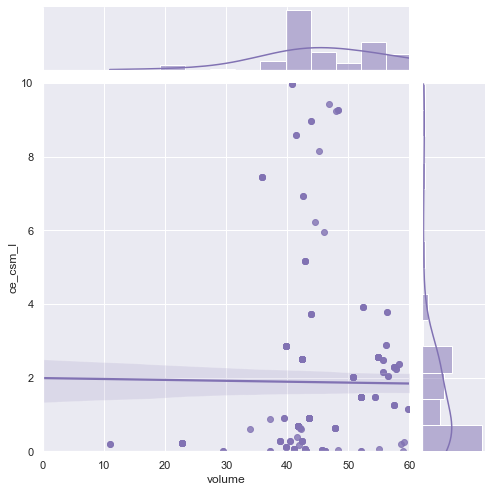

In [56]:
import seaborn as sns
sns.set_theme(style="darkgrid")

tips = dataframe[(dataframe['ce_csm_I']<10)&(dataframe['anionframe_elements']=='S')]
g = sns.jointplot(x="volume", y="ce_csm_I", data=tips,
                  kind="reg", truncate=False,
                  xlim=(0, 60), ylim=(0, 10),
                  color="m", height=7)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



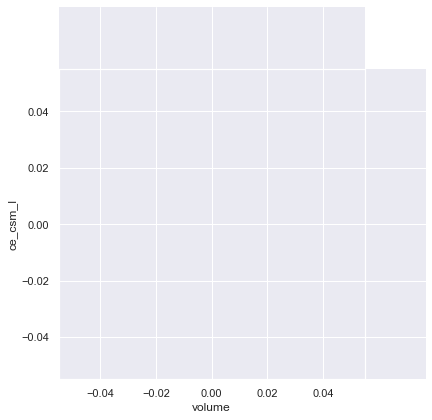

--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):
  File "D:\anaconda\envs\matmining\lib\tokenize.py", line 330, in find_cookie
    line_string = line.decode('utf-8')
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x9c in position 2: invalid start byte

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\anaconda\envs\matmining\lib\linecache.py", line 47, in getlines
    return updatecache(filename, module_globals)
  File "D:\anaconda\envs\matmining\lib\linecache.py", line 136, in updatecache
    with tokenize.open(fullname) as fp:
  File "D:\anaconda\envs\matmining\lib\tokenize.py", line 394, in open
    encoding, lines = detect_encoding(buffer.readline)
  File "D:\anaconda\envs\matmining\lib\tokenize.py", line 371, in detect_encoding
    encoding = find_cookie(first)
  File "D:\anaconda\envs\matmini

In [ ]:
g = sns.JointGrid(data=dataframe, x="volume", y="ce_csm_I", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, clip=((2200, 6800), (10, 25)),
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)